In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('./presentation.mplstyle')



In [ ]:
!sudo apt-get install texlive-full  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  aglfn asymptote asymptote-doc biber chktex cm-super cm-super-minimal context
  context-modules dvidvi dvipng emacsen-common feynmf fonts-adf-accanthis
  fonts-adf-berenis fonts-adf-gillius fonts-adf-universalis
  fonts-arphic-bkai00mp fonts-arphic-bsmi00lp fonts-arphic-gbsn00lp
  fonts-arphic-gkai00mp fonts-baekmuk fonts-cabin fonts-comfortaa
  fonts-croscore fonts-crosextra-caladea fonts-crosextra-carlito
  fonts-dejavu-core fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-baskerville
  fonts-gfs-bodoni-classic fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-didot-classic fonts-g

In [ ]:
#Generic Hyp
batch_size= 64 #Neural Network batch size
n_rnds= 1000 #Global rounds
tau=5 #Local rounds --> not in use since we use local epochs
total_c= 250 #Total no of clients
no_of_c=[5] #participating clients
local_epochs = 5 
plot_local_train_loss = True


#Cluster
K= 55        #try for 5,10,20. Number of clusters is predetermined for static
cluster = 1
clust_mech = 'static' #'static 

#Model
model_type = 'lenet' #shakespeare_lstm' #'shakespeare_lstm'#'cnnmnist'#'cnnmnist' #'r'
dataset = 'cifar10'

#Plotting
plot_every_n = 20


#Learning rate
algo_lr = {  #lr for each algo, length has to be the same for all algos
    0: [1/np.power(10,2.5)],
    1: [1/np.power(10,2)],
    2: [1/np.power(10,2)],
    3: [0.01],
    4: [0.1],
    5: [0.1]
    }

lrfactor = {
    0:1, #factor to reduce lr in scheduler
    1:1,
    2:1,
    3:1,
    4:1,
    5:1
    }

sch_freq = 200 #scheduler every n rounds



#select algos to run
d_algo = {
            0: "MIFA",
            1: "FedVARP",
            2: "FedAvg",
            3: "SCAFFOLD",
            4: "ClusterFedVARP",
            5: "UMIFA dynamic clustering"
        }

d_algo_keys = sorted(list(d_algo.keys()))




In [ ]:
def plot(loss_algo, acc_algo, test_loss_algo,n_c, timestr, algo_lr, learning_rate, global_train_loss_algo = None,n = None, k = None, title = ""):
    colors = ['blue','red','olive','purple','forestgreen','orange']
    linesty = ['--', '-', '-.', '-', '-', '-']
    boxes = ['o','^', 'x', '*', 'v']
    loss_algo = moving_avg(loss_algo,n,k)
    acc_algo = moving_avg(acc_algo,n,k)
    test_loss_algo = moving_avg(test_loss_algo,n,k)
    if global_train_loss_algo:
      global_train_loss_algo =  moving_avg(global_train_loss_algo,k)
    try:
      os.mkdir('./graphs')
    except:
      pass
    pnts = 100/plot_every_n
    #plot accuracy test 
    plt.figure(figsize=(10,8)) 
    plt.ylabel('Test Accuracy')
    plt.xlabel('Communication rounds')
    for algo_i, acc_per_algo in enumerate(acc_algo):
           # algo_lr[algo_i][learning_rate],n_c, total_c, lrfactor[algo_i], local_epochs)) 
        # xo = np.arange(len(acc_per_algo))*config.plot_every_n
        # xnew = np.linspace(xo.min(), xo.max(), 600)
        # spl = make_interp_spline(xo, acc_per_algo) 
        # y_smooth = spl(xnew)
        new_acc = []
        for i,el in enumerate(acc_per_algo):
          if i%pnts ==1:
            new_acc.append(el)

        #find no of rounds to reach acc
        for i, el in enumerate(new_acc):
          if 'ResNet' in title:
            if el>0.60 and new_acc[i-1]<=0.6:
              m, b = np.polyfit([(i-1) *plot_every_n*pnts,i *plot_every_n*pnts],[new_acc[i-1], new_acc[i]],1)
              xline = np.arange((i-1) *plot_every_n*pnts,i *plot_every_n*pnts, 1)
              yline = m*xline + b
              for c, cround in enumerate(yline):
                if cround>0.6:
                  print(xline[c],d_algo[d_algo_keys[algo_i]] )
              print(i *plot_every_n*pnts, d_algo[d_algo_keys[algo_i]])
          elif 'LeNet' in title:
            if el>0.50 and new_acc[i-1]<=0.5:
              m, b = np.polyfit([(i-1) *plot_every_n*pnts,i *plot_every_n*pnts],[new_acc[i-1], new_acc[i]],1)
              xline = np.arange((i-1) *plot_every_n*pnts,i *plot_every_n*pnts, 1)
              yline = m*xline + b
              for c, cround in enumerate(yline):
                if cround>0.5:
                  print(xline[c],d_algo[d_algo_keys[algo_i]] )
          elif 'Shakespeare' in title:
            if el>0.51 and new_acc[i-1]<=0.51:
              m, b = np.polyfit([(i-1) *plot_every_n*pnts,i *plot_every_n*pnts],[new_acc[i-1], new_acc[i]],1)
              xline = np.arange((i-1) *plot_every_n*pnts,i *plot_every_n*pnts, 1)
              yline = m*xline + b
              for c, cround in enumerate(yline):
                if cround>0.51:
                  print(xline[c],d_algo[d_algo_keys[algo_i]] )
              print(i *plot_every_n*pnts, d_algo[d_algo_keys[algo_i]])
        # plt.plot(np.arange(len(acc_per_algo))*plot_every_n, acc_per_algo,  label = d_algo[d_algo_keys[algo_i]], color = colors[algo_i], ls = linesty[algo_i])
        plt.plot(np.arange(len(new_acc))*plot_every_n*pnts, new_acc, boxes[algo_i], color = colors[algo_i], ls = linesty[algo_i], label = d_algo[d_algo_keys[algo_i]])
        # plt.plot(xnew, y_smooth,  label = d_algo[d_algo_keys[algo_i]])
        #plt.plot(np.arange(len(acc_per_algo))*config.plot_every_n, acc_per_algo, label = d_algo[d_algo_keys[algo_i]])
    plt.legend(loc = 'lower right')
    dir_name ="./graphs/testacc{0}.pdf".format(timestr)
    plt.savefig(dir_name)

    #plot loss test 
    plt.figure(figsize=(10,8)) 
    plt.ylabel('Test Loss')
    plt.xlabel('Communication rounds')
    
    for algo_i, tstloss_per_algo in enumerate(test_loss_algo):
        new_tstls = []
        for i,el in enumerate(tstloss_per_algo):
          if i%pnts ==1:
            new_tstls.append(el)
        #plt.title('CIFAR-10 on LeNet-5')# vs Comm Rounds lr = {0:.5f}, clients = {1}/{2}, lr_decay = {3}, local_ep = {4} '.format(
            #algo_lr[algo_i][learning_rate],n_c, total_c, lrfactor[algo_i], local_epochs))    
        # xo = np.arange(len(tstloss_per_algo))*config.plot_every_n
        # xnew = np.linspace(xo.min(), xo.max(), 600)
        # spl = make_interp_spline(xo, tstloss_per_algo) 
        # y_smooth = spl(xnew)
        # plt.plot(xnew, y_smooth,  label = d_algo[d_algo_keys[algo_i]])
        # plt.plot(np.arange(len(tstloss_per_algo))*plot_every_n, tstloss_per_algo,  label = d_algo[d_algo_keys[algo_i]], color = colors[algo_i], ls = linesty[algo_i])
        plt.plot(np.arange(len(new_tstls))*plot_every_n*pnts, new_tstls, boxes[algo_i], color = colors[algo_i], ls = linesty[algo_i], label = d_algo[d_algo_keys[algo_i]])
        #plt.plot(np.arange(len(tstloss_per_algo))*config.plot_every_n, tstloss_per_algo, label = d_algo[d_algo_keys[algo_i]])
    plt.legend(loc = 'upper right')
    dir_name ="./graphs/testlos{0}.pdf".format(timestr)
    plt.savefig(dir_name)

    # from scipy.interpolate import make_interp_spline, BSpline
    #plot train loss (local)
   
    plt.figure(figsize=(10,8)) 
    plt.ylabel('Train Loss')    
    plt.xlabel('Communication rounds')
    plt.title(title)# vs Comm rounds lr = {0:.5f}, clients = {1}/{2}, lr_decay = {3}, local_ep = {4} '.format(
    for algo_i, loss_per_algo in enumerate(loss_algo):
        new_trls = []
        for i,el in enumerate(loss_per_algo):
          if i%pnts ==1:
            new_trls.append(el)
        #plt.title('Train Loss')# vs Comm rounds lr = {0:.5f}, clients = {1}/{2}, lr_decay = {3}, local_ep = {4} '.format(
            #algo_lr[algo_i][learning_rate],n_c, total_c, lrfactor[algo_i], local_epochs))  
        # xo = np.arange(len(loss_per_algo))*config.plot_every_n
        # xnew = np.linspace(xo.min(), xo.max(), 600)
        # spl = make_interp_spline(xo, loss_per_algo) 
        # y_smooth = spl(xnew)
        # plt.plot(xnew, y_smooth,  label = d_algo[d_algo_keys[algo_i]])
        # plt.plot(np.arange(len(loss_per_algo))*plot_every_n, loss_per_algo,  label = d_algo[d_algo_keys[algo_i]], color = colors[algo_i], ls = linesty[algo_i])
        plt.plot(np.arange(len(new_trls))*plot_every_n*pnts, new_trls, boxes[algo_i], color = colors[algo_i], ls = linesty[algo_i], label = d_algo[d_algo_keys[algo_i]])
        # plt.plot(, loss_per_algo)
    plt.legend(loc = 'upper right')
    dir_name ="./graphs/trainloss{0}.pdf".format(timestr)
    plt.savefig(dir_name)

    if global_train_loss_algo:
      #plot global train 
      plt.figure(figsize=(10,8)) 
      plt.ylabel('Global Train Loss')
      plt.xlabel('Communication rounds')
      for algo_i, tstloss_per_algo in enumerate(global_train_loss_algo):
          #plt.title('Global Train Loss')# vs Comm Rounds lr = {0:.5f}, clients = {1}/{2}, lr_decay = {3}, local_ep = {4} '.format(
             # algo_lr[algo_i][learning_rate],n_c, total_c, lrfactor[algo_i], local_epochs))    
          # xo = np.arange(len(tstloss_per_algo))*config.plot_every_n
          # xnew = np.linspace(xo.min(), xo.max(), 600)
          # spl = make_interp_spline(xo, tstloss_per_algo) 
          # y_smooth = spl(xnew)
          # plt.plot(xnew, y_smooth,  label = d_algo[d_algo_keys[algo_i]])
          plt.plot(np.arange(len(tstloss_per_algo))*plot_every_n, tstloss_per_algo,  label = d_algo[d_algo_keys[algo_i]], color = colors[algo_i], ls = linesty[algo_i])
          #plt.plot(np.arange(len(tstloss_per_algo))*config.plot_every_n, tstloss_per_algo, label = d_algo[d_algo_keys[algo_i]])
      plt.legend(loc = 'upper right')
      dir_name ="./graphs/gltrainloss{0}.pdf".format(timestr)
      plt.savefig(dir_name)

   
    plt.savefig(dir_name)
    #plt.close()

In [ ]:
def plot_clusters(bins, final_clusters, timestr):
    plt.figure(figsize = (8,6))
    plt.title("Distribution of Clusters for Shakespeare")
    plt.bar(bins,final_clusters)#,bins = bins, density = False)
    plt.ylabel('Number of clients')
    plt.xlabel('Cluster Number')
    if not os.path.exists("./clusthist"):
            #cwd = os.getcwd()
            os.makedirs("./clusthist")
    plt.savefig("./clusthist/"+timestr+'.pdf')
    plt.show()
    plt.close()

In [ ]:
#shakespeare clusters
clusterno = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
bins = [ 6,  7, 12,  6,  8,  7, 10,  5, 13,  6, 10, 10,  6, 10,  7, 10,  4,  7,
 12,  7,  6,  7,  7,  7,  6,  6,  6,  4,  6,  4,  9,  6,  1,  4,  7,  1,]

In [ ]:
#cifar clusters
clusterno=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
bins = [ 4,  6,  4,  4,  7,  5,  4,  7,  4,  7,  3,  4,  8, 10,  6,  5,  9,  6,
  3,  4,  6,  7,  2,  7,  4,  5,  2,  6,  4,  8,  7,  1,  4,  3,  6,  4,
  5, 10,  4,  1,  3,  9,  5,  2,  1,  3,  5,  4,  3,  2,  1,  2,  3,  1,
  0,]

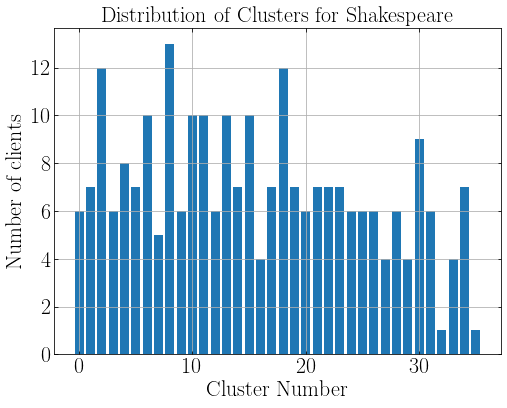

In [ ]:
plot_clusters(clusterno,bins,'0')

In [ ]:
loss_algo= [[2.250185441970825, 2.036592791080475, 1.5368201512098314, 1.0752816233038902, 0.7842651590704918, 0.6840139952301979, 0.8140361189842225, 0.7044646539934911, 0.6070434109866618, 0.5703882758133113, 0.7826706638932228, 0.6582856196910144, 0.5205039769411087, 0.4920514870760962, 0.5987740752939135, 0.6058711806684732, 0.5207625999487936, 0.5628604767471552, 0.377870995849371, 0.5140485446620733],
            [4.134552749006739, 2.5661455801098954, 2.295703972779024, 2.286873409841127, 2.17570591803612, 2.1028063330866535, 2.053177530654505, 2.0664958955405455, 1.941665537737769, 2.0089330803634526, 1.9033046698570253, 1.960055633949511, 1.851482141988519, 1.811459802008017, 1.8414310936019258, 1.754387002254776, 1.7993603283857815, 1.824953072307661, 1.7884006474953071, 1.8140168788201732, 1.7149616933066139, 1.6508161496056448, 1.678080085714658, 1.7175446364325881, 1.644699634161147, 1.6724428868013796, 1.6406062449645167, 1.5908950238492752, 1.633291641846324, 1.6282942719408708],
            [2.250751085281372, 0.7041204327344894, 0.843026927113533, 0.6706820695102215, 0.7573753488063811, 0.7471895229816437, 0.4504629254015162, 0.33703911085845906, 0.7218388774991036, 0.5969877326861024, 0.4949642467871308, 0.6316957427561284, 0.5521288545429706, 0.5137579495459794, 0.5989594328776002, 0.5083810987696051, 0.5717410999163985, 0.3998961128643714, 0.513037212737836, 0.4754184277099557, 0.4078601766750217, 0.422429705359973, 0.35960595564916736, 0.31309003720991313, 0.48471868110820643, 0.5302720402926206, 0.4172096315189265, 0.40131339626852425, 0.4636336610559374, 0.32601083098328676, 0.48760337233543394, 0.33283920786809174, 0.5837496754527092, 0.44465079380199307, 0.3621380366606172, 0.37859608441591264, 0.46164754341647496, 0.3082488780049607, 0.43742357637733226, 0.2626944122381974, 0.25373608673573467, 0.33371183116687464, 0.35082581707276406, 0.2637986796116456, 0.27121165937627667, 0.23764643274014813, 0.3173657682957128, 0.3614428969111759, 0.4129623216018081, 0.3641674773022533], [1.8495809948444368, 0.6837616325193083, 0.8365601301193237, 0.7606801307946445, 0.8163154952228069, 0.9196038834750653, 0.5361779014505738, 0.4756571361422539, 0.9172443658113479, 0.8070056497305631, 0.5877474111318588, 0.7062877007573843, 0.8029598587751389, 0.6260520819574594, 0.7517408649623395, 0.5472290050797165, 0.7219449038803578, 0.4663285771757365, 0.5371131577715278, 0.618573066163808, 0.5377109454572201, 0.4261083805561066, 0.5336238700896502, 0.34238877850119026, 0.6783235140144825, 0.637631980329752, 0.45461647694930446, 0.44505536288954317, 0.5050897791422904, 0.4202699733339251, 0.6304884392023087, 0.4498406645469368, 0.7085084059834481, 0.5636453464627266, 0.39225236106198286, 0.4877762825414539, 0.5534589861077256, 0.35024903768207877, 0.43972324319183825, 0.5517451128549874, 0.320662046817597, 0.3747960846591741, 0.44280341882258656, 0.3865511571057141, 0.29686138550285246, 0.2755247105285525, 0.3975805309880525, 0.5544556538836333, 0.5527973429730627, 0.45459311969578264],
            [2.0752789711952206, 0.7238472003483912, 0.9431309607625007, 0.8345157957077027, 0.8599964457750321, 0.9120618653297425, 0.5167472682480001, 0.4390749305824283, 0.860334400832653, 0.847466899305582, 0.6504276821762323, 0.8138057176768779, 0.7564072942733764, 0.6981962180510163, 0.6940194140002132, 0.638797319829464, 0.8073299421370029, 0.4912016942612536, 0.6495150388608454, 0.6661091010679957, 0.5830921399779618, 0.5010585518507287, 0.5365843236818909, 0.40693048625718803, 0.6077263156045227, 0.6976501844450832, 0.48991215979214753, 0.5281745786871761, 0.5992816166207194, 0.4294075845048065, 0.5961373045295477, 0.4865252374485135, 0.7014797133207321, 0.5860563693381845, 0.4959890638949583, 0.5232046218588948, 0.548784383291495, 0.3503260070027318, 0.5497449113428592, 0.4720645135082305, 0.38547242521075537, 0.3495871965150582, 0.4370922912377864, 0.35987124327570197, 0.3899714270042023, 0.37834599281777626, 0.4242054551467299, 0.5563928272272459, 0.4858165960485349, 0.4826403060741723],
            [1.8405174374580384, 0.718526532179676, 0.9844676220417024, 0.8385136929154395, 0.9045311054587364, 0.9632908594608306, 0.570511583435291, 0.4573301919631194, 0.8985104125738144, 0.8265622809529305, 0.743466462790966, 0.8319194113463164, 0.8067668493092061, 0.6516380584239959, 0.7896058788895608, 0.7000577072240413, 0.8035177341103553, 0.5283160061156377, 0.6219984954129905, 0.7024217875127216, 0.6248080276045949, 0.6704939400404692, 0.5734329405054449, 0.4376867307256907, 0.6758946327865125, 0.7567844114080072, 0.5113285525114043, 0.6553188187126944, 0.6158130276855082, 0.4653196753665725, 0.7164714402891695, 0.57445995118469, 0.805090623497963, 0.7040018977969884, 0.5265998215420404, 0.6408882359415292, 0.6266498713273176, 0.49210207666289535, 0.6598440185189247, 0.5763531345610773, 0.5316400836737012, 0.49111919021874206, 0.5692957558436319, 0.6363469079136849, 0.6423611650097882, 0.5026026536035351, 0.5707358014397323, 0.7367753119464032, 0.6578618812921924, 0.7417679226398468],
            ]

acc_algo= [[(0.0469), (0.1719), (0.1250), (0.1250), (0.1562), (0.3125), (0.4375), (0.4844), (0.3906), (0.4062), (0.4375), (0.4375), (0.4531), (0.4688), (0.4531), (0.4375), (0.4844), (0.5312), (0.5156), (0.5000)],
          [(0.1250), (0.2031), (0.2812), (0.3281), (0.3281), (0.3438), (0.3750), (0.3594), (0.3125), (0.3594), (0.3438), (0.3906), (0.3750), (0.3750), (0.4062), (0.4531), (0.4688), (0.4688), (0.4688), (0.5000), (0.5000), (0.4688), (0.4844), (0.5156), (0.4844), (0.5156), (0.5000), (0.5000), (0.5312), (0.4844)],
           [0.109375,0.09375,0.171875,0.28125,0.21875,0.234375,0.125,0.375
,0.390625,0.265625,0.3125,0.34375,0.421875,0.34375,0.3125,0.46875
,0.3125,0.359375,0.25,0.4375,0.390625,0.4375,0.296875,0.296875
,0.421875,0.46875,0.46875,0.421875,0.4375,0.484375,0.453125,0.4375
,0.453125,0.3125,0.4375,0.515625,0.265625,0.328125,0.4375,0.53125
,0.359375,0.453125,0.46875,0.53125,0.421875,0.515625,0.5,0.453125
,0.515625,0.4375],
        [0.09375,0.046875,0.125,0.34375,0.265625,0.3125,0.234375,0.4375
,0.359375,0.421875,0.375,0.390625,0.453125,0.484375,0.421875,0.484375
,0.40625,0.34375,0.40625,0.5,0.453125,0.46875,0.40625,0.453125
,0.421875,0.4375,0.484375,0.53125,0.46875,0.375,0.515625,0.375
,0.4375,0.390625,0.40625,0.609375,0.390625,0.46875,0.453125,0.546875
,0.453125,0.46875,0.515625,0.578125,0.5,0.609375,0.5625,0.4375
,0.578125,0.4375],
[0.0625 , 0.109375 ,0.140625 ,0.296875 ,0.265625 ,0.234375 ,0.359375 ,0.328125
 , 0.328125 ,0.390625 ,0.421875 ,0.390625 ,0.3125 , 0.40625 ,0.4375 , 0.375
 , 0.375 ,0.390625 ,0.453125 ,0.390625 ,0.421875 ,0.40625 ,0.375 ,0.453125
 , 0.4375 , 0.40625 , 0.375 ,0.4375  ,0.484375 ,0.484375 ,0.46875 , 0.5
 , 0.5 , 0.484375 ,0.4375 , 0.4375  ,0.53125  ,0.53125 , 0.546875 ,0.515625
 , 0.515625 ,0.453125 ,0.515625 ,0.5 , 0.5 , 0.5 , 0.53125 , 0.484375
 , 0.453125 ,0.46875],
 [0.046875,0.15625,0.03125,0.3125,0.171875,0.265625,0.34375,0.265625
,0.375,0.359375,0.34375,0.359375,0.421875,0.328125,0.359375,0.3125
,0.25,0.390625,0.40625,0.265625,0.328125,0.28125,0.25,0.359375
,0.1875,0.296875,0.328125,0.296875,0.28125,0.25,0.25,0.21875
,0.234375,0.296875,0.359375,0.3125,0.359375,0.3125,0.375,0.3125
,0.390625,0.3125,0.359375,0.328125,0.296875,0.3125,0.40625,0.296875
,0.265625,0.359375]
  ]

test_loss_algo= [[2.3178937435150146, 2.3011271953582764, 2.383192300796509, 2.483394145965576, 2.087473154067993, 1.9213268756866455, 1.8200699090957642, 1.739867925643921, 1.7523804903030396, 1.7265723943710327, 1.6964945793151855, 1.6477558612823486, 1.6228619813919067, 1.6085658073425293, 1.599439024925232, 1.6074035167694092, 1.5839345455169678, 1.5068066120147705, 1.5032685995101929, 1.478144645690918],
                [4.600222110748291, 2.5415947437286377, 2.4033737182617188, 2.199152946472168, 2.1593942642211914, 2.096021890640259, 2.0493886470794678, 2.0413825511932373, 2.0453810691833496, 2.0129005908966064, 1.942513346672058, 1.8989919424057007, 1.908199429512024, 1.8480589389801025, 1.8204182386398315, 1.780024766921997, 1.7332862615585327, 1.7298494577407837, 1.7074564695358276, 1.7203125953674316, 1.6835048198699951, 1.6871163845062256, 1.6632990837097168, 1.6550012826919556, 1.6463934183120728, 1.6104270219802856, 1.6046186685562134, 1.6057566404342651, 1.6030192375183105, 1.5999948978424072],
[2.285350799560547, 2.5994327068328857, 2.1590070724487305, 2.1145012378692627, 2.104405641555786, 2.1094415187835693, 2.8284380435943604, 2.071051836013794, 1.9500751495361328, 1.814741849899292, 2.096893787384033, 1.7498787641525269, 1.5805878639221191, 1.8682973384857178, 1.8188259601593018, 1.671040415763855, 1.8153889179229736, 1.8840863704681396, 1.9711754322052002, 1.7391334772109985, 1.7195791006088257, 1.6327288150787354, 2.107832431793213, 2.065335273742676, 1.7828764915466309, 1.4859954118728638, 1.5998194217681885, 1.5714876651763916, 1.771209955215454, 1.528662919998169, 1.3552350997924805, 1.8528424501419067, 1.4241122007369995, 1.740312099456787, 1.7239285707473755, 1.5104176998138428, 1.9534951448440552, 1.8727589845657349, 1.7568303346633911, 1.4859504699707031, 1.857931137084961, 1.7058340311050415, 2.003357410430908, 1.4872928857803345, 1.683064341545105, 1.3676979541778564, 1.4869904518127441, 1.6321215629577637, 1.3920817375183105, 1.7109272480010986], [2.609408378601074, 2.4347496032714844, 2.29837965965271, 1.8501907587051392, 1.9089947938919067, 1.8032513856887817, 2.1210927963256836, 1.6442530155181885, 1.8226392269134521, 1.5433300733566284, 1.757430911064148, 1.8072304725646973, 1.5316314697265625, 1.6589343547821045, 1.4707365036010742, 1.5193309783935547, 1.7460734844207764, 1.7763258218765259, 1.814003348350525, 1.5358293056488037, 1.5734416246414185, 1.6449898481369019, 1.786826252937317, 1.8485273122787476, 1.64457106590271, 1.5616194009780884, 1.4491695165634155, 1.4193198680877686, 1.6791026592254639, 1.58096182346344, 1.3705215454101562, 1.8328421115875244, 1.456339955329895, 1.6320805549621582, 1.630100965499878, 1.4489173889160156, 1.6866217851638794, 1.5589134693145752, 1.518283486366272, 1.263941764831543, 1.6093542575836182, 1.6572072505950928, 1.4630894660949707, 1.2320696115493774, 1.5795550346374512, 1.4387201070785522, 1.262986183166504, 1.4469691514968872, 1.1851937770843506, 1.546431303024292],
                 [2.3041911125183105, 2.3792879581451416, 2.319857120513916, 2.0816330909729004, 2.0408763885498047, 1.9429433345794678, 1.8639976978302002, 1.8736512660980225, 1.9022293090820312, 1.8140826225280762, 1.8149009943008423, 1.7482813596725464, 1.7860674858093262, 1.7200990915298462, 1.6683309078216553, 1.7425261735916138, 1.7102822065353394, 1.6423704624176025, 1.6448537111282349, 1.6193766593933105, 1.5902959108352661, 1.555930495262146, 1.5763182640075684, 1.5480766296386719, 1.5629209280014038, 1.5517573356628418, 1.5443834066390991, 1.5070431232452393, 1.5152288675308228, 1.5111827850341797, 1.5701011419296265, 1.4715583324432373, 1.4437774419784546, 1.4918406009674072, 1.4594484567642212, 1.499413013458252, 1.4736744165420532, 1.3850306272506714, 1.4298198223114014, 1.4306819438934326, 1.4546000957489014, 1.4423120021820068, 1.4356852769851685, 1.4066014289855957, 1.4146838188171387, 1.4262441396713257, 1.3996565341949463, 1.3537993431091309, 1.3782312870025635, 1.3852604627609253],
                 [2.3043816089630127, 2.5872251987457275, 2.470055103302002, 2.0661754608154297, 2.076209545135498, 2.016033887863159, 1.9258008003234863, 1.9144508838653564, 1.913441777229309, 1.7998312711715698, 1.8762720823287964, 1.7804073095321655, 1.8212162256240845, 1.79207181930542, 1.7807477712631226, 1.8154973983764648, 1.7874531745910645, 1.6494228839874268, 1.698923110961914, 1.8242391347885132, 1.9794374704360962, 1.838856816291809, 1.91323721408844, 1.829084038734436, 1.927866816520691, 1.9424242973327637, 1.9510259628295898, 1.875097632408142, 1.8005186319351196, 2.1396679878234863, 2.201300859451294, 2.222487688064575, 1.910516619682312, 2.3239989280700684, 1.9333821535110474, 1.9493398666381836, 1.819145917892456, 1.9149243831634521, 1.904821753501892, 1.9816467761993408, 2.117008924484253, 2.075059175491333, 1.858228325843811, 2.018071174621582, 2.009565830230713, 2.0928494930267334, 1.8916345834732056, 1.905212163925171, 1.9825527667999268, 1.903401494026184]] 
global_train_loss_algo= [[2.293347096809036, 2.2933335703657107, 2.3085275568315744, 2.3452191703459797, 2.0580071558427933, 2.0180918906655765, 1.95158648414685, 1.9088693442551985, 1.8132124316052098, 1.737156463401092, 1.7174152516952865, 1.7059828073472318, 1.6653574839272463, 1.6110829680472079, 1.611404149428658, 1.6001207779740434, 1.5857456922531128, 1.5467907806186725, 1.5651969339536584, 1.5400915048311434],
                         [2.5681109550359, 2.369485750527638, 2.192703879397848, 1.9798330882626116, 1.6496360920884114, 1.5243111098818767, 1.8079455299755496, 1.4192663675074078, 1.4735263212562522, 1.3886498497880024, 1.329122147139381, 1.3409394172146498, 1.3300595524365946, 1.3193832161786305, 1.4924000119004408, 1.245239368485063, 1.2625418008136018, 1.287571001997994, 1.3467530248415134, 1.2785131374893286, 1.4907832827104632, 1.2376368210443756, 1.2720885587775188, 1.3186012383007333, 1.3782438652594682, 1.236111698705522, 1.320474518686914, 1.2490511588428332, 1.258890440549387, 1.2677954932307953, 1.1704973982423164, 1.2300071632465743, 1.1196917268778661, 1.056950182713511, 1.2126366485415212, 1.1226886299717458, 1.1831958344220506, 1.2422959639898041, 1.301120155607648, 1.2543247804007567, 1.247514860709305, 1.1606104075146453, 1.2006083688772549, 1.1856810860621654, 1.1772026110945455, 1.1511086688931946, 1.1537014970846493, 1.1111187803013551, 1.0895642785312574, 1.1125077913179422],
                         [2.313127050619296, 2.718198701548759, 2.3873546733270827, 2.4626120966108864, 2.1007465794873053, 2.185421536950504, 2.4055621977657307, 2.4672679367577635, 2.109319025598219, 1.9217471972755764, 2.141037308041702, 1.786066850585401, 1.9673936746614364, 2.0314957787618613, 2.084376709845365, 1.7893683648170413, 1.6995721892322726, 2.112284838086199, 1.8593177542357189, 2.0781999527645842, 2.1126727002965824, 2.089250533172237, 1.6666597996831245, 2.427712882571208, 1.6378433446750007, 1.5719170869158967, 1.6506810612080958, 1.6186595676500168, 2.0210934549646304, 1.6294488609599336, 1.4443097698414111, 1.6846655895338034, 1.4311492180885257, 2.081161778906117, 1.4696635843237953, 1.4366107608961023, 1.551239703164991, 1.9763728070746907, 1.5247630307741482, 1.6413531164683954, 1.7426458467607913, 1.7250330195097667, 2.0303831248332167, 1.5257286187023154, 1.904719739466372, 1.6443034367793052, 1.5075269330797902, 1.5828681426584874, 1.4741359590874303, 1.7369005465141647], [2.4084554736876425, 2.402089850981827, 2.300442163596678, 2.0279615957413792, 1.836868904130843, 1.9115093611085507, 1.8539090273935166, 1.8513423628209498, 1.9286987606216879, 1.8321602541162534, 1.766756489148835, 1.7736740908049562, 1.6151360575195468, 1.6101894558543135, 1.5632760248830557, 1.4785257596189103, 1.6545952160645019, 2.019210838448361, 1.5771292001390091, 1.7939104143615878, 1.8231555519201565, 1.8247647991265787, 1.487707942343124, 2.2465131654763772, 1.5435032707346066, 1.6041428750128393, 1.435643153727207, 1.5333436593375243, 1.74092260208886, 1.7079876446358078, 1.5218495926283815, 1.8345090065465863, 1.6594612705128273, 1.826515315896105, 1.4971025252281247, 1.5385879246170258, 1.5175873548783305, 1.5830313479504012, 1.5009528162229397, 1.4426662075854932, 1.619252022117605, 2.167339678310677, 1.6256351297163902, 1.5118630267774966, 1.6975096871176034, 1.7789865540116645, 1.4783535072260805, 1.224442282143761, 1.5658732361500831, 1.538248826628146],
                         [2.3068569432134214, 2.3046618264044643, 2.162924311045186, 2.0947389739858524, 2.1062307266323157, 2.1455236902017423, 1.991531876042066, 1.9691086286474067, 1.9881241265160348, 1.889057346774489, 1.8757370567077871, 1.7823126700223255, 1.702260232794925, 1.744750304600162, 1.7602592173134883, 1.6788409469682541, 1.6395474925370472, 1.624849726629379, 1.6165691665981128, 1.5947133535924165, 1.5641895589011405, 1.5684392462910899, 1.5560582431076129, 1.5558777643591546, 1.5547727053732519, 1.5117536463091135, 1.5478146724078967, 1.51667344875043, 1.5687216976109672, 1.5298654822742237, 1.5352890657646883, 1.5076113379824803, 1.4900897698634117, 1.476109565981209, 1.4766113075149028, 1.4644008687390087, 1.520210544319104, 1.5232518650686648, 1.5081545352326025, 1.4662096619301135, 1.4573013017244656, 1.4576979340494747, 1.4887842900307893, 1.4401199738387866, 1.358835378418798, 1.3487369942543146, 1.4141145847032748, 1.3944736766388348, 1.33922284399457, 1.363503291478852],
                          [2.3085484861412926, 2.503264875363206, 2.270970214358376, 2.1478447911074703, 2.123403258945631, 2.149907044437535, 2.0339901968646235, 2.1325975409554094, 2.0485612373522786, 1.9805986126670447, 2.02022965698291, 2.0733103932017256, 2.096503448303398, 2.0316868878691396, 2.1138363073549002, 1.9654342329410641, 1.8841876931812451, 1.8805544103502922, 1.853664349869389, 1.876887312325675, 2.101998085865889, 1.8691983521746858, 1.7366043138686957, 1.8237970145157232, 1.7940964575313851, 1.8523510151811877, 1.7886652065360027, 1.6604884963511202, 1.839964223792181, 2.0371419813321983, 2.076411700614578, 1.9979541981616593, 1.7606874137278408, 2.218889702311562, 1.792464588914076, 1.8793068671470408, 1.8013870917317811, 1.9455420376394716, 1.9644825328951296, 1.9548905263166598, 2.1140705310475187, 2.1814545694824377, 1.8283333095443217, 2.015903753240395, 1.9997478305836163, 1.9405862882619014, 1.9876222162295485, 1.884708498902333, 2.0640361136792564, 1.993263289751604]]






# loss_algo = [[1.5905722874403, 0.6649638326000422, 0.8228766936063767, 0.6203990501537919, 0.6579169327020645, 0.702516353800893, 0.4148768706475766, 0.27606913201627326, 0.7035353372991084, 0.45194116207770996, 0.3960197900887578, 0.4915416484419257, 0.5113032628595828, 0.4523022695444524, 0.421875416431576, 0.34035353823564946, 0.4669293108396232, 0.23745086897368312, 0.3937130091252038, 0.40059116585791343, 0.3339391951682046, 0.24982463573105634, 0.23642124342732132, 0.2833880874707393, 0.3867131445137784, 0.35771988009568306, 0.25826869568962135, 0.21069277999004726, 0.3794219580525533, 0.23154411958872517, 0.3629101856565103, 0.21160236849682407, 0.4237997557781636, 0.3394163223728538, 0.23435678271844154, 0.20276378496550024, 0.30180578275932934, 0.15054096014995594, 0.2566709895094391, 0.21441211685381859, 0.14585861868632494, 0.19230766217754083, 0.24368521918775515, 0.17373615298420192, 0.1506352302945379, 0.15212155154440554, 0.18274998920271174, 0.3073595911728807, 0.24164728735631802, 0.2820625782525167],
#              ]
# acc_algo = [[0.09375,0.125,0.171875,0.296875,0.359375,0.390625,0.46875,0.421875
# ,0.375,0.53125,0.46875,0.5,0.5,0.515625,0.59375,0.453125
# ,0.53125,0.5625,0.53125,0.5,0.53125,0.5625,0.453125,0.609375
# ,0.578125,0.484375,0.53125,0.546875,0.59375,0.546875,0.546875,0.578125
# ,0.5625,0.484375,0.46875,0.5,0.53125,0.5625,0.53125,0.484375
# ,0.5625,0.546875,0.515625,0.578125,0.5625,0.5625,0.59375,0.515625
# ,0.5625,0.546875], ]

# test_loss_algo= [[2.6778602600097656, 2.36613130569458, 2.227344512939453, 1.9982688426971436, 1.773194432258606, 1.6569077968597412, 1.7001121044158936, 1.5314816236495972, 1.7092477083206177, 1.3758760690689087, 1.3916816711425781, 1.3017231225967407, 1.3381097316741943, 1.3451178073883057, 1.2503730058670044, 1.420082688331604, 1.323906660079956, 1.3728721141815186, 1.351675033569336, 1.32662832736969, 1.3945510387420654, 1.3951420783996582, 1.3467227220535278, 1.3044196367263794, 1.3701978921890259, 1.4208204746246338, 1.4051681756973267, 1.3769646883010864, 1.34976065158844, 1.2885353565216064, 1.2957931756973267, 1.3759626150131226, 1.393798589706421, 1.533385157585144, 1.5107516050338745, 1.514690637588501, 1.4874824285507202, 1.3236494064331055, 1.4886136054992676, 1.3891984224319458, 1.2929078340530396, 1.3692022562026978, 1.3997834920883179, 1.3057043552398682, 1.3363947868347168, 1.32844877243042, 1.3426752090454102, 1.5167262554168701, 1.266188621520996, 1.3554918766021729]]
# global_train_loss_algo = [[2.5681109550359, 2.369485750527638, 2.192703879397848, 1.9798330882626116, 1.6496360920884114, 1.5243111098818767, 1.8079455299755496, 1.4192663675074078, 1.4735263212562522, 1.3886498497880024, 1.329122147139381, 1.3409394172146498, 1.3300595524365946, 1.3193832161786305, 1.4924000119004408, 1.245239368485063, 1.2625418008136018, 1.287571001997994, 1.3467530248415134, 1.2785131374893286, 1.4907832827104632, 1.2376368210443756, 1.2720885587775188, 1.3186012383007333, 1.3782438652594682, 1.236111698705522, 1.320474518686914, 1.2490511588428332, 1.258890440549387, 1.2677954932307953, 1.1704973982423164, 1.2300071632465743, 1.1196917268778661, 1.056950182713511, 1.2126366485415212, 1.1226886299717458, 1.1831958344220506, 1.2422959639898041, 1.301120155607648, 1.2543247804007567, 1.247514860709305, 1.1606104075146453, 1.2006083688772549, 1.1856810860621654, 1.1772026110945455, 1.1511086688931946, 1.1537014970846493, 1.1111187803013551, 1.0895642785312574, 1.1125077913179422]]


In [ ]:
#19/02
# loss_algo1 = [[2.2408858609199522, 2.242417171001434, 1.9939406037330627, 1.241684750318527, 1.0518700313568115, 0.917298310995102, 0.6551299649151041, 0.5764079913776368, 0.8616086465120315, 0.9416340988874436, 0.665912933498621, 0.7784053285419941, 0.7743561805784702, 0.5934190614521503, 0.712711523771286, 0.6228138394653796, 0.762353397011757, 0.475539163062349, 0.6653956710034981, 0.6065567307453603, 0.5060095541551709, 0.5250187922269106, 0.5297618664056063, 0.40764569586608557, 0.583137118369341, 0.6436983227729798, 0.505974995191209, 0.4741163673537086, 0.5305294441059233, 0.376355415652506, 0.5412912210077047, 0.4495155202224851, 0.6435800871253015, 0.5495397741347551, 0.41255079426890007, 0.49618491176515817, 0.5122984770432231, 0.29688393903896215, 0.5033773104846477, 0.38882266611268274, 0.3487378199212253, 0.37544643331319094, 0.401599069791846, 0.35107022773474456, 0.3364686531755433, 0.2872788411285728, 0.3788810191303492, 0.5169830407912377, 0.4322110619756859, 0.40032561110332604, 0.38676677424402445, 0.2965194647794124, 0.3923824598011561, 0.3984420384466648, 0.3471062581427396, 0.42512042358517643, 0.3653825615346432, 0.25613718021806564, 0.2129857162339613, 0.21813180260593074, 0.300726137990132, 0.3348286995186936, 0.3346266586187994, 0.3288382859900594, 0.3287043083179742, 0.41009512589313085, 0.34906256054993723, 0.21057670862443048, 0.32496668019390196, 0.2120159532671096, 0.3196843944350257, 0.22277344028465448, 0.3262610669620335, 0.29494748070836063, 0.30171108211390674], [1.727764912247658, 0.7329357042611809, 0.8189399360120296, 0.6227711227349937, 0.6389905671775342, 0.756984702348709, 0.4445192416096688, 0.2477562333567766, 0.6199624444544314, 0.39053616371471433, 0.35293037375900893, 0.469056233484298, 0.4321683935821056, 0.3571505650505424, 0.3281514248950407, 0.21145776913501324, 0.33411405412480233, 0.2061634899646015, 0.3632536812324543, 0.37457424920805354, 0.30731285899470095, 0.18580709501402454, 0.18989844524185173, 0.20474591600843267, 0.24691363600082697, 0.2646628880518256, 0.17950677917484426, 0.15530277901685624, 0.1656945029855706, 0.1673532578204322, 0.17097041443223132, 0.21000835587037728, 0.19129027480725197, 0.18010548735968768, 0.1200558838629513, 0.11490538099082186, 0.1687382509365852, 0.12820609576504155, 0.18750217017251997, 0.16343368843761708, 0.09154753557206277, 0.1580266060558597, 0.11197496902663262, 0.08505410668556578, 0.10990876101903266, 0.11256267190121434, 0.09450213235482806, 0.11765699071211203, 0.13641022273132877, 0.1532991381187458, 0.08883487716273522, 0.09540930034944722, 0.08561835506780882, 0.09421297164342832, 0.09429774611366155, 0.1649732819775818, 0.07875301970692818, 0.09095898110244775, 0.07260450492147356, 0.08434213688575255, 0.07363981757938745, 0.07004112016460567, 0.11179681107181749, 0.09986184149805921, 0.11807446371061814, 0.1155690528752166, 0.08710008568072226, 0.07300808126718948, 0.06768153193814215, 0.0836180429144224, 0.0790758872506558, 0.054318477166234516, 0.10064380984636956, 0.06956091598272905, 0.07193397058406845], [2.241803951263427, 0.6941682334197685, 0.958214213848114, 0.7904977068305015, 0.8615939077734946, 0.831005389392376, 0.5326478751841932, 0.40001826034858823, 0.8056833267211914, 0.6645832005143165, 0.5909131766110659, 0.7009740024805069, 0.6754743838310242, 0.5679941282421351, 0.6356512486934661, 0.5611326314881444, 0.6360776884108781, 0.5044280361151323, 0.5772995659476147, 0.5487860137037932, 0.5256155396252871, 0.4903413394838571, 0.4598966458998621, 0.3517506820755079, 0.5739546189829707, 0.6012291313707829, 0.45869965047459116, 0.440105639899848, 0.5446803330257535, 0.33840931659215134, 0.5514435064978898, 0.4400813917256892, 0.6235372801125051, 0.5192170446179807, 0.408421213272959, 0.4410635245963931, 0.46584441389422865, 0.24494889780704399, 0.45767000211402775, 0.3288450322125573, 0.2729209681059001, 0.3494051167188445, 0.40993644333211704, 0.33120627084746956, 0.34969928044709375, 0.2586392175010406, 0.3680656488053501, 0.45937867661705234, 0.4586455565958749, 0.4140189636871218, 0.4033173285273369, 0.280901783676818, 0.35743863843497825, 0.35010564152151347, 0.37645565025974065, 0.34350909503176813, 0.33877688644453885, 0.2586538805102464, 0.21909972378984094, 0.19968100249534473, 0.3221291811828269, 0.3176617354154586, 0.28789624390425156, 0.3128276746440679, 0.30346979866735635, 0.45848054310306907, 0.30082807652652266, 0.23904054240090772, 0.20518132472177966, 0.17024201770895162, 0.3135134107619524, 0.2930358531605452, 0.34370781466364864, 0.2803713039588183, 0.2989635583781637], [1.8737202268838882, 0.6859471547158319, 0.905848949663341, 0.7820855262130499, 0.836263622790575, 0.9175185245275497, 0.4952963505974185, 0.35106349421665073, 0.8891913983225821, 0.5658456113189458, 0.50870973136276, 0.6087167319655419, 0.7225467655807735, 0.5740666772425174, 0.6144461955875158, 0.4510794384405017, 0.5320903782173991, 0.47763165231794125, 0.5000614728592335, 0.5955163373239338, 0.5159761667624115, 0.42147681947797533, 0.42166593465954066, 0.2781615782342851, 0.5131468410789967, 0.6107621451467276, 0.47229798740998374, 0.3916345719760284, 0.42618000023067, 0.3519986881804652, 0.4131677083671093, 0.44884319802746175, 0.5057541386783123, 0.6235827076435089, 0.3433346450515091, 0.4034961905516684, 0.45454128867830157, 0.2556351219303906, 0.36225233668461443, 0.5248581754602492, 0.31190982650034127, 0.415825063905213, 0.4257136308401823, 0.3345734279416502, 0.3237447663093917, 0.22285326845943926, 0.3137769193947315, 0.5300541098980466, 0.484297455099877, 0.39349628519266844, 0.36802149708382786, 0.34426826298236846, 0.45284110872540617, 0.4977378996275365, 0.34268027041107413, 0.37322115590795873, 0.3183521850407124, 0.23737847179640087, 0.24779485461302103, 0.2466449408885092, 0.29633330029435456, 0.39477580476406726, 0.34575967286364173, 0.3614077913202345, 0.33402198791503906, 0.4537518158601597, 0.42704518107697365, 0.2501369643211365, 0.33397313287016006, 0.2742083856847603, 0.41051545653492216, 0.3088889524154365, 0.4447600461635738, 0.40096619885414836, 0.2696019656490535], [2.066741417646408, 0.77004953095573, 1.08574302315712, 1.0333117425441742, 1.053917308151722, 1.0118123513460158, 0.6639097014674917, 0.6409664557664655, 1.031545559167862, 1.0102545645833014, 0.9699888968467713, 0.9864614111185073, 0.9331972354650496, 0.858149712383747, 1.024769203066826, 0.8521774725615978, 0.9234610331058501, 0.64219598590862, 0.7930352526542265, 0.7475075465044938, 0.7646708086133003, 0.6951116219907999, 0.8700703749805688, 0.636769215669483, 0.848613661825657, 0.9154414132237434, 0.693202046280494, 0.747259913783928, 0.8395713573694229, 0.5666973211173899, 0.8254026964306831, 0.7813171231746674, 0.9274449929594993, 0.8237226769328118, 0.7159814831998664, 0.8278070444613694, 0.7219599756516981, 0.5608261653501541, 0.8680999875068665, 0.6672757741622626, 0.6562340583116747, 0.5925589053984731, 0.6395814990252257, 0.66828323982656, 0.703595436119358, 0.5616013579769059, 0.7181578387320042, 0.7362579173909034, 0.7589932077785487, 0.7302237775921822, 0.7186980012187268, 0.47036459308816114, 0.6328411298943684, 0.8298548561334609, 0.7632671323418617, 0.8744114443659783, 0.8565529750287533, 0.42592712129000565, 0.6157188647054136, 0.5814226693008095, 0.6577811368647963, 0.5622367713134736, 0.6403969123866409, 0.6636632582545281, 0.7419099730253219, 0.898982394039631, 0.7825727561116218, 0.5492522196890786, 0.6870912202331236, 0.48689409470884126, 0.7780002276599407, 0.6837012566626072, 0.6944668340682983, 0.7631282635033131, 0.7475033734738827]]
# acc_algo1 = [[(0.0981), (0.1130), (0.1020), (0.1283), (0.1206), (0.0817), (0.0955), (0.1890), (0.1975), (0.2504), (0.2790), (0.2843), (0.3022), (0.3271), (0.3299), (0.3413), (0.3521), (0.3617), (0.3692), (0.3811), (0.3946), (0.3884), (0.4034), (0.4065), (0.4092), (0.4130), (0.4053), (0.4206), (0.4196), (0.4283), (0.4446), (0.4452), (0.4495), (0.4516), (0.4535), (0.4534), (0.4675), (0.4625), (0.4705), (0.4724), (0.4712), (0.4767), (0.4829), (0.4788), (0.4842), (0.4896), (0.4882), (0.4903), (0.4962), (0.4982), (0.4920), (0.4975), (0.5057), (0.5005), (0.5026), (0.5088), (0.5085), (0.5183), (0.5113), (0.5086), (0.5202), (0.5210), (0.5237), (0.5175), (0.5211), (0.5302), (0.5271), (0.5256), (0.5290), (0.5247), (0.5328), (0.5295), (0.5353), (0.5348), (0.5332)], [(0.0981), (0.1000), (0.1794), (0.2904), (0.3330), (0.3835), (0.4196), (0.4425), (0.3667), (0.4561), (0.4344), (0.4817), (0.4838), (0.4703), (0.4825), (0.4982), (0.4939), (0.5010), (0.4999), (0.5052), (0.5048), (0.5147), (0.5136), (0.5094), (0.5147), (0.5184), (0.5143), (0.5157), (0.5248), (0.5079), (0.5202), (0.5181), (0.5153), (0.5196), (0.5186), (0.5245), (0.5266), (0.5176), (0.5191), (0.5285), (0.5232), (0.5207), (0.5404), (0.5334), (0.5221), (0.5239), (0.5266), (0.5359), (0.5315), (0.5340), (0.5320), (0.5349), (0.5246), (0.5335), (0.5313), (0.5376), (0.5344), (0.5320), (0.5295), (0.5327), (0.5293), (0.5267), (0.5300), (0.5332), (0.5371), (0.5403), (0.5330), (0.5406), (0.5334), (0.5350), (0.5419), (0.5390), (0.5365), (0.5367), (0.5419)], [(0.0981), (0.1011), (0.1408), (0.1656), (0.1821), (0.2181), (0.1507), (0.2100), (0.2520), (0.2053), (0.2513), (0.2670), (0.3055), (0.2602), (0.3014), (0.3234), (0.2987), (0.3004), (0.2799), (0.3063), (0.3642), (0.3749), (0.3411), (0.2404), (0.3616), (0.3943), (0.3652), (0.3978), (0.3896), (0.4063), (0.4411), (0.3111), (0.4123), (0.2735), (0.3641), (0.4554), (0.2939), (0.3001), (0.3606), (0.4229), (0.3716), (0.3577), (0.3734), (0.4641), (0.3748), (0.4464), (0.4421), (0.4482), (0.4182), (0.3872), (0.4371), (0.4092), (0.4531), (0.4681), (0.3978), (0.3235), (0.3860), (0.4100), (0.4698), (0.5181), (0.3929), (0.4598), (0.5131), (0.2464), (0.5176), (0.4811), (0.4826), (0.4432), (0.4106), (0.4623), (0.3857), (0.4480), (0.3249), (0.4668), (0.5000)], [(0.0981), (0.1174), (0.2050), (0.2631), (0.3099), (0.3009), (0.3225), (0.3692), (0.3557), (0.3688), (0.3721), (0.4322), (0.3814), (0.4124), (0.4256), (0.4514), (0.4044), (0.4046), (0.4348), (0.4884), (0.4456), (0.4499), (0.4516), (0.3796), (0.4668), (0.4783), (0.4384), (0.4915), (0.4435), (0.5267), (0.5090), (0.4367), (0.5147), (0.4677), (0.4369), (0.4907), (0.4924), (0.4746), (0.4441), (0.5052), (0.5079), (0.5030), (0.4820), (0.5002), (0.4580), (0.5261), (0.5403), (0.4689), (0.5195), (0.5109), (0.5204), (0.4939), (0.5232), (0.5059), (0.5125), (0.4791), (0.5023), (0.5410), (0.5405), (0.5598), (0.5170), (0.5393), (0.5472), (0.4251), (0.5656), (0.5540), (0.5555), (0.5128), (0.5233), (0.5392), (0.5384), (0.5124), (0.5052), (0.5302), (0.5478)], [(0.0981), (0.1013), (0.1146), (0.1100), (0.1172), (0.1351), (0.1309), (0.1435), (0.1311), (0.1709), (0.1702), (0.1833), (0.2221), (0.2164), (0.2384), (0.2498), (0.2406), (0.2146), (0.2484), (0.2159), (0.2476), (0.2551), (0.2395), (0.2343), (0.2483), (0.2418), (0.2115), (0.2368), (0.2481), (0.2464), (0.2152), (0.2531), (0.2345), (0.2144), (0.2339), (0.2309), (0.2473), (0.2838), (0.2499), (0.2698), (0.2748), (0.2819), (0.2712), (0.2584), (0.2846), (0.2699), (0.2720), (0.2966), (0.2959), (0.2891), (0.2787), (0.2667), (0.2283), (0.2617), (0.2832), (0.2586), (0.2746), (0.2695), (0.2897), (0.2785), (0.2847), (0.2882), (0.2885), (0.2704), (0.2905), (0.2921), (0.2848), (0.2892), (0.2965), (0.2715), (0.2786), (0.2646), (0.3008), (0.2886), (0.2808)]]
# test_loss_algo1= [[2.3053547986753427, 2.3027624780205405, 2.2904063379688626, 2.3916027280175762, 2.5176428579221106, 2.3997392487374083, 2.345150233833653, 2.2076618398071095, 2.2710330068685445, 2.134501409378781, 1.9805427470784278, 1.9466719050316295, 1.9116549112234906, 1.8601380108268397, 1.8457709604008183, 1.823807635884376, 1.7906393025331437, 1.757444995983391, 1.7299078239756784, 1.706810497174597, 1.680647911539503, 1.6858290183316371, 1.6544183545811162, 1.6285175350820942, 1.6220342179012905, 1.6211921918164394, 1.6292288045215, 1.6102479073652036, 1.581375658132468, 1.5679105087450356, 1.5330206375972482, 1.5223315194913536, 1.5191123713353636, 1.528259029054338, 1.5145071023588728, 1.5046139545501418, 1.4850700782362822, 1.4787315327650423, 1.4603935677534456, 1.4591080557768512, 1.4715939980403634, 1.4485256975623453, 1.4428429527647177, 1.4557436271837563, 1.4381732872337292, 1.4204486449053333, 1.4225165327643132, 1.4252029733293374, 1.4125694461688874, 1.4062302029056915, 1.4285958952205196, 1.4083675328333667, 1.388020166166269, 1.3917410024412118, 1.3920133812412334, 1.3776834231273385, 1.3787005213415546, 1.3636552285236918, 1.371581131485617, 1.3827866824569217, 1.3579101623243588, 1.3537592067839994, 1.3436509074678846, 1.3695883189037348, 1.3519642664368745, 1.3313406500846716, 1.3425692031337957, 1.3506892520910616, 1.3461404773080425, 1.3393807931310813, 1.3337585341398883, 1.3310955238949722, 1.3178055309186316, 1.3165893767290056, 1.3331459145637075], [2.3053547986753427, 2.417351283844869, 2.331980220071829, 1.8808834871668725, 1.7979616860675205, 1.646781269911748, 1.59460784143703, 1.5211917936422263, 1.732471415191699, 1.482416558417545, 1.539027153306706, 1.4439780279329628, 1.448414195874694, 1.5653334028401953, 1.5276578224388657, 1.4502763512787546, 1.493180208904728, 1.4804542300048147, 1.4729814187736268, 1.4379613562754006, 1.451845223736611, 1.463820316988951, 1.4743860382942637, 1.520519813914208, 1.479957356574429, 1.4936041668721824, 1.493443606006112, 1.5336645864377356, 1.558254553254243, 1.593043058161523, 1.5447494641990418, 1.5384385065667947, 1.6413479887755813, 1.5937035676020725, 1.6032226252707706, 1.6010591482660572, 1.5628399021306616, 1.7054864433920307, 1.583809048127217, 1.589017098496674, 1.616440555472283, 1.6627275617259323, 1.5845806799876463, 1.6287711019728595, 1.6247739161655401, 1.6944758740200359, 1.7132779124436106, 1.6716078329997457, 1.6749290637909227, 1.6250212982202032, 1.6531742796017106, 1.6556403925464411, 1.7327264851065958, 1.6676257704473605, 1.6925136526678777, 1.6884739277469125, 1.6807928723134813, 1.690823118398144, 1.6726255272604098, 1.681300518619027, 1.706802239843235, 1.7578758661914025, 1.7561918967848371, 1.7603885611151433, 1.735329364515414, 1.7497048704487503, 1.7557689027421792, 1.7529268553302546, 1.813254377644533, 1.7663929644663623, 1.7697018825324478, 1.842103882200399, 1.7893101326219596, 1.8162698571089726, 1.7729660549740882], [2.3053547986753427, 2.871206151452034, 2.584500122981466, 2.5155445230994253, 2.285864801163886, 2.398661934646072, 2.852604014099024, 2.545762672545804, 2.174967061182496, 2.186249606928248, 2.257017928323928, 2.1846742288322205, 1.9271824466195075, 2.127546947473174, 1.9596099944631005, 1.8706468108353342, 1.9795926505592978, 1.9607388403764956, 2.1180200432516205, 2.0720423634644525, 1.994691514665154, 1.8583748826555386, 1.8814039723888325, 2.61794200748395, 1.7683720452011011, 1.7177930424927146, 1.8359517109621861, 1.654089467540668, 1.8032679330011843, 1.6619391099662537, 1.5644260523425546, 2.190897071437471, 1.64541546326534, 2.1632497788994174, 1.8580089541757183, 1.5515982998404534, 1.99442505077192, 2.2637495933824283, 1.9353401919079434, 1.7171681861209263, 1.8408725626149756, 1.9543401830515283, 1.9754147977586005, 1.5650845682545074, 1.8833734085605403, 1.659450130098185, 1.6131503004936656, 1.5671493171886275, 1.7136832407325695, 1.89447984042441, 1.651978658263091, 1.7534995382758463, 1.55158011700697, 1.6125170045597539, 1.88276366747109, 2.198805997326116, 1.9904026871274232, 1.696923201251182, 1.6177530675936656, 1.4025758231521412, 1.9450122201518647, 1.5767611234810701, 1.4208266940086511, 3.259059831594965, 1.387264248671805, 1.4979811436051775, 1.561440021369108, 1.7030446483830737, 1.9494608511590654, 1.6498145738225074, 2.0117371545475757, 1.776000531615725, 2.335499044436558, 1.7177413709604057, 1.5871392754232807], [2.3053547986753427, 2.5455298211164537, 2.1553074463157897, 2.0069235631614735, 1.8109483407561187, 1.9166942546322088, 1.8313437001720356, 1.844839878143019, 1.8021711877956512, 1.8061546831373956, 1.864665633553912, 1.6391630772572414, 1.7368619920341832, 1.7069481451799915, 1.6173156142994096, 1.5511897870689442, 1.719736357403409, 1.7498415792064301, 1.6399274768343397, 1.4793509920691228, 1.695883513256243, 1.738038181499311, 1.549044624255721, 1.9454911385372187, 1.5321207760245936, 1.5674190726249841, 1.5821903731412947, 1.4671113008906127, 1.7617329184416752, 1.3876773794745183, 1.431638526309068, 1.7811732125130428, 1.4281049739023683, 1.5602323234460915, 1.8017069192448998, 1.5153161218971203, 1.4814298980554956, 1.597335911860132, 1.7454923201518453, 1.5152205760311928, 1.42962805784432, 1.4674089289015266, 1.5436483173613336, 1.5399091873958612, 1.6797190532562838, 1.4954321915936317, 1.3741601120894122, 1.5871720412734207, 1.415681307103224, 1.499755629308664, 1.403143968931429, 1.4933958759733066, 1.3916305493397318, 1.605552260283452, 1.5282681572968793, 1.665269206283958, 1.5811762817346366, 1.397713639933592, 1.3855608458731585, 1.3153085127757613, 1.5099362962564844, 1.3867468006291968, 1.3922239037076378, 2.190183545373807, 1.2803402057119235, 1.3966445406531072, 1.3575018913882553, 1.4996898576712152, 1.4136835351871078, 1.3563363825439647, 1.417529515020407, 1.523985111030044, 1.5920003622200838, 1.5141003955701353, 1.3910319945614809], [2.3053547986753427, 2.3122172401209546, 2.3479925401651176, 2.299893429324885, 2.306725731321201, 2.279685274051253, 2.2772197146324595, 2.257927319046798, 2.246981598009729, 2.207586853367508, 2.1917093954268534, 2.168396652883785, 2.155704158126928, 2.1378089591955685, 2.1097395792128935, 2.1029967244263665, 2.091076430241773, 2.0897963479825648, 2.0723440647125244, 2.0970685831300773, 2.0617657413907873, 2.0504433030535463, 2.0558092381544175, 2.050644034792663, 2.032885884023776, 2.0404851877006, 2.044997966213591, 2.026258635672794, 2.039405364899119, 2.0327253569463255, 2.064197072557583, 2.0324361635621186, 2.052304216251252, 2.066371163744835, 2.046370796337249, 2.0278457342439395, 2.009555031539528, 1.9937304546878596, 2.0531674266620805, 2.023518087757621, 2.0230629588388336, 1.9887110944006854, 2.005462069420298, 2.0111335720985557, 1.9793475015907531, 2.0062109930500105, 2.0210115241396958, 1.9681633004717007, 1.9588993969996265, 1.9963165415320427, 2.036425712002311, 2.051976143934165, 2.0856166956531013, 1.9880362384638208, 1.9680463470471132, 2.0731040869548822, 2.0085434192305156, 2.003023480154147, 1.940276026725769, 1.966035078285606, 1.9705111175585703, 1.9547833545952087, 1.9492401036487264, 1.970188972296988, 1.9576181013872669, 1.950752301580587, 1.97118316182665, 1.9843465241656941, 1.9353568903200187, 2.042178570844565, 1.9627101353019665, 2.0244574394955, 1.9476989150806596, 1.9666411975386795, 1.9395238107936397]]

# loss_algo2 = [[2.266605930328369, 0.7268936070986092, 0.8262085914611816, 0.7278584766387939, 0.789262431114912, 0.8328173357248305, 0.4864991550380364, 0.39781104219146074, 0.7963750839233399, 0.6060823075845838, 0.5346481820195914, 0.6540009770914913, 0.6000230658054352, 0.5791857862845063, 0.601682240627706, 0.5190603889152408, 0.5686144001036882, 0.3752458044723608, 0.5238422186486422, 0.5128258825093507, 0.4091419728193433, 0.40845248263329265, 0.3796430809050798, 0.3013287895149552, 0.5125403020903467, 0.5991131212748586, 0.42233779141388367, 0.4361695684376173, 0.5032469877973199, 0.32608761260868047, 0.5282123374938965, 0.3950447229295969, 0.5774009934067726, 0.46566474655643103, 0.3646327123069205, 0.46415614344179623, 0.48778910474386067, 0.2545838783669751, 0.4572430377453565, 0.32971935802372176, 0.3245800571789732, 0.3327472523745382, 0.3493784692324698, 0.32167371020186697, 0.33286477030196693, 0.2957916100276634, 0.349626142103225, 0.39972871131263676, 0.39174779985914937, 0.4350884895399213, 0.3715547561389394, 0.26866615810780786, 0.3496144967258442, 0.32577093903440985, 0.35413724374026057, 0.33965593559667473, 0.32831785692833365, 0.25175643964787014, 0.20672295935451981, 0.19863504536915572, 0.28091858461964875, 0.34502744917088424, 0.268632475467748, 0.3027701299916953, 0.28329219892155383, 0.3964059149939566, 0.2668914383533411, 0.20437563372426668, 0.2600222816795576, 0.1959657436172711, 0.3295389977656305, 0.21123826382681726, 0.2802377519570291, 0.28684747384861115, 0.3034199068276212]]
# acc_algo2 = [[(0.1000), (0.1056), (0.1872), (0.1866), (0.2155), (0.2241), (0.1755), (0.2340), (0.2766), (0.2977), (0.2559), (0.2974), (0.3096), (0.3258), (0.3258), (0.3277), (0.3496), (0.3169), (0.3304), (0.3346), (0.3913), (0.3696), (0.3772), (0.2539), (0.3769), (0.4161), (0.4115), (0.4104), (0.4146), (0.3947), (0.4595), (0.3623), (0.4409), (0.3122), (0.4084), (0.4400), (0.3362), (0.3241), (0.3737), (0.4400), (0.3795), (0.3463), (0.3892), (0.4604), (0.3772), (0.4576), (0.4635), (0.4242), (0.4319), (0.4137), (0.4535), (0.4158), (0.4581), (0.4535), (0.4190), (0.3505), (0.4129), (0.4549), (0.4668), (0.5215), (0.3873), (0.4955), (0.5014), (0.2476), (0.5168), (0.4649), (0.4898), (0.4505), (0.3990), (0.4018), (0.4180), (0.4426), (0.2972), (0.4725), (0.4873)]]
# test_loss_algo2= [[2.303871118339004, 2.6260714849848656, 2.4120719280971845, 2.409005051205872, 2.182197004366832, 2.2427911735644006, 2.7619217368447857, 2.352934918585856, 2.045297640144445, 1.8935333437221065, 2.3420700191692183, 2.091948390766314, 1.8934061990422049, 1.9135446829401004, 1.8467614757027595, 1.8377963076731203, 1.81701025461695, 1.9897786735729048, 1.9364540470633538, 1.982912877562699, 1.9462405222996024, 1.9037779850564944, 1.7602778787066222, 2.4196130895310906, 1.7387240084872884, 1.6801124120214184, 1.6817812767757732, 1.6299497974905999, 1.7231184479537283, 1.7008798874107895, 1.5081710071320746, 2.0188621388878794, 1.5689433987732906, 2.0384149969003764, 1.698885802250759, 1.5789897722803103, 1.875636939030544, 2.1590435770666523, 1.8913457044370614, 1.6488587286821597, 1.8806824752479603, 2.057405424725478, 1.9556179684438524, 1.5971620978823133, 1.9155669273084897, 1.6665107239583494, 1.5615776093902103, 1.632922878690586, 1.6873853889999875, 1.8008693889447838, 1.5817927653622474, 1.772542264810793, 1.5359481922380485, 1.7144343268339801, 1.7403066537942096, 2.055244419225462, 1.9417891669425236, 1.571626900867292, 1.6192392346205984, 1.3945775001671663, 1.966594428013844, 1.4353576587263945, 1.4407802045724953, 3.4662667186396896, 1.3770995010995561, 1.589984660695313, 1.5800997254195486, 1.7329540920865005, 2.066873349961202, 1.911852010496103, 1.8351701270243166, 1.8370396377174718, 2.6644384291521304, 1.708401631397806, 1.631705492165438]]


#20/02
loss_algo1 = [[2.1641824758052826, 0.679903041627258, 0.8442165119946002, 0.6703794477321207, 0.7602621139585971, 0.7793908587098122, 0.4342514027375728, 0.3047540643357206, 0.7262851790338753, 0.5427592182531953, 0.4299494856037199, 0.548766844458878, 0.5317899409867823, 0.39406567383091895, 0.428567181667313, 0.3699571460206062, 0.49236093979328877, 0.3275122245958482, 0.4496563454973511, 0.419184678667225, 0.32282588821835817, 0.2939789543347433, 0.230189665844664, 0.25846741360590386, 0.38193835674319415, 0.40863495591329413, 0.2505611116124055, 0.28233054457632534, 0.3859869722090661, 0.21714493308783855, 0.26967035052366556, 0.20148450312088242, 0.34274881433695553, 0.27000652823597193, 0.2063663958880352, 0.18828718244563786, 0.27775073544249607, 0.12828477365750587, 0.19717017805203793, 0.15871887195506135, 0.16515887939138335, 0.226844662057556, 0.20533704124449287, 0.12459055669605731, 0.18110554323597172, 0.1061865624858183, 0.14827838785364295, 0.21802614952204746, 0.20653475960571085, 0.22338842528872194, 0.15713305099401623, 0.16404383982044238, 0.17265316177872592, 0.1728773363679647, 0.14568395901762415, 0.2816897634143243, 0.12577954851090906, 0.13582873773484608, 0.1190069790976122, 0.0847077386530873, 0.14868213625275528, 0.11747215796814998, 0.11557837282249239, 0.1424217503517866, 0.1362685735756531, 0.16803180148825048, 0.14137233509216457, 0.09110695837458478, 0.11017260141767111, 0.08974384497482787, 0.154099217687035, 0.0964466946106404, 0.14560584078892133, 0.12588753198739142, 0.1327317975681217]]
acc_algo1 = [[(0.1022), (0.1260), (0.1577), (0.2628), (0.2938), (0.3418), (0.3637), (0.4111), (0.3403), (0.4304), (0.4470), (0.4434), (0.4544), (0.4547), (0.4807), (0.4908), (0.5008), (0.4732), (0.5107), (0.4953), (0.5198), (0.5189), (0.5184), (0.5101), (0.5367), (0.5225), (0.5354), (0.5266), (0.5237), (0.5369), (0.5249), (0.5242), (0.5391), (0.5353), (0.5388), (0.5460), (0.5450), (0.5390), (0.5297), (0.5430), (0.5452), (0.5460), (0.5453), (0.5438), (0.5449), (0.5417), (0.5432), (0.5487), (0.5483), (0.5480), (0.5470), (0.5443), (0.5449), (0.5421), (0.5519), (0.5480), (0.5560), (0.5421), (0.5504), (0.5528), (0.5453), (0.5453), (0.5500), (0.5501), (0.5433), (0.5487), (0.5567), (0.5400), (0.5506), (0.5543), (0.5493), (0.5558), (0.5497), (0.5555), (0.5514)]]
test_loss_algo1= [[2.30606231416107, 2.4754030628568806, 2.341848621702498, 2.061267620438983, 1.8642810583114624, 1.7776108744797434, 1.7463626109870376, 1.6093194013947894, 1.7456689480763332, 1.556109947004136, 1.5203452307707186, 1.5498626695317068, 1.4854562988706455, 1.525312942304429, 1.4385671976265635, 1.4294318021482724, 1.4150115669153298, 1.4824283836753505, 1.4169426685685564, 1.4578599049027559, 1.3879555330914297, 1.3779944276354115, 1.3767144941979912, 1.4298180531544291, 1.3528565711276546, 1.3941193044565285, 1.3719439088918601, 1.3675329373900298, 1.4058805263725815, 1.3735705914011427, 1.436697191873174, 1.5673608734349536, 1.4090134573590225, 1.421831666284306, 1.4106061762305582, 1.3996459929047116, 1.3909636470162945, 1.4128545480928603, 1.4965892096233975, 1.4134908504546828, 1.4086879214663415, 1.3777022092205704, 1.3971325094532814, 1.4030429766436292, 1.3981167484240926, 1.4492304473166253, 1.4418697288841198, 1.415443693756298, 1.4151042437857124, 1.4325927260575022, 1.4650540367053573, 1.4476283431812456, 1.4376472454921456, 1.4755787720346147, 1.4387895882509316, 1.4409540128556027, 1.4323977816636395, 1.4656213472603232, 1.434239455469095, 1.448970399085124, 1.5363176609300504, 1.5383918482786532, 1.5237394036001461, 1.5597219186223996, 1.5532451564339316, 1.5299147113113647, 1.514402507217067, 1.593685999797408, 1.5235902188689845, 1.519247679573715, 1.5471604447455922, 1.5334362987500088, 1.5475551022845468, 1.5416284325016532, 1.5504385274686632]]
global_train_loss_algo = [[]]

loss_algo = [[2.067584252357483, 0.8674177215165674, 0.9680086743831634, 0.9134296745061874, 0.8897245886921883, 0.8768037116527557, 0.5338796673784965, 0.4036750140809454, 0.8335846853256225, 0.5853332031518221, 0.509696180569008, 0.6213686397299171, 0.5947182069718837, 0.49688482218422003, 0.5072797490097583, 0.4482140947785229, 0.5529833967611194, 0.37735117086791437, 0.4345012361020781, 0.44845071646326684, 0.40162103341892363, 0.3506052773911506, 0.32835808327421545, 0.281859276771429, 0.44237725686281915, 0.49009206198155875, 0.3159942979289917, 0.28322072722199665, 0.3947976315533742, 0.323716261325535, 0.3970180484093725, 0.2620455713849515, 0.44806978791952135, 0.3381129226181656, 0.22628017225211808, 0.2907690514437854, 0.35155787203169897, 0.16494317861745914, 0.2914999059587717, 0.25536669841632825, 0.1795064804541471, 0.24589737418860746, 0.2505418724997435, 0.165314980619587, 0.17346325815771707, 0.12239111186412628, 0.20811528726189862, 0.25772368686040864, 0.23157531887864935, 0.2196276963595301, 0.23460692214335724, 0.19081719924915888, 0.25649818260426394, 0.1935530118038878, 0.17950266180676405, 0.22676930567366074, 0.24778416014742105, 0.13192452363195115, 0.09262444447329472, 0.1009686564077856, 0.18617810344863756, 0.16310277895987382, 0.15525876620174128, 0.1566564155346714, 0.14012188749737106, 0.17646710151806472, 0.1668044591177022, 0.10900495661655443, 0.14957419403439415, 0.09189895728028205, 0.1902691153646447, 0.13136050449320463, 0.1697618414927274, 0.20175479745958, 0.1659830898710061], [1.5936298656463623, 0.6693601841438793, 0.7712141117453575, 0.57290493439883, 0.6033890210837125, 0.6977276314981282, 0.41395211430935885, 0.1995486696437001, 0.5842922013252974, 0.42309321984648707, 0.311937525710091, 0.4262559999071528, 0.46288780139759184, 0.37089913966134186, 0.35070303168380634, 0.23125452887965364, 0.3245295446261298, 0.21525946969632065, 0.2963977019375307, 0.263207219732285, 0.3989287072024308, 0.3281926556886174, 0.19086412643431688, 0.16962456265289802, 0.32896190934465264, 0.21965767299057912, 0.2269230479452017, 0.17411332852600028, 0.17846110046142713, 0.1720417295196603, 0.25840822831960397, 0.13390681421151385, 0.3926001334004104, 0.161190470836591, 0.1922486623705481, 0.1613387945073191, 0.18650899707688948, 0.16244825905587276, 0.1951819423364941, 0.1055901793319208, 0.10429423725960078, 0.09516019863011024, 0.1180941768968478, 0.09688687289017253, 0.1308981727861101, 0.115155955543687, 0.15670104120799805, 0.16265826113640286, 0.11153748659970006, 0.11071932208258657, 0.15215595967412782, 0.10843895954458276, 0.10439445069645445, 0.1138882679597009, 0.09264447051682509, 0.17660198409110306, 0.07976520427386276, 0.10153199196412972, 0.07545281632046681, 0.07856600792089011, 0.08153580754904396, 0.08634771371368513, 0.08715861340698212, 0.09017393938614987, 0.11170715221225691, 0.09391590593411821, 0.18139434771612287, 0.07127157247217837, 0.06650588304311895, 0.07427885871453327, 0.07521041935018728, 0.09910935274026995, 0.08659245467744767, 0.13923396383253023, 0.09598017432668712], [1.9484060138463974, 0.661732844633516, 0.7821358008682728, 0.6218637532740832, 0.7034912561625243, 0.6671235800534486, 0.4017410212825053, 0.285709969123709, 0.6940541182458401, 0.44280272207222876, 0.3776646717032418, 0.46104034481570116, 0.45217981852591044, 0.4457778836973011, 0.43776986483950164, 0.4086147519899532, 0.4170421821903437, 0.3226972503995057, 0.44582007341086866, 0.3614027049479773, 0.3619843916676473, 0.263724071145989, 0.23146596021251753, 0.21426134389766954, 0.34008743017911913, 0.3513124448363669, 0.21749878775051915, 0.24606635477059174, 0.30350900516845286, 0.2584175163631153, 0.28488909875275564, 0.21334837361471726, 0.37912878992035987, 0.24718953471630808, 0.17322864148329248, 0.16897740660235286, 0.25279074383637634, 0.13486109213961756, 0.18793352132430302, 0.2112955329497345, 0.10212602808780502, 0.16596297953801695, 0.17224466579034925, 0.1688185749319382, 0.1341896080947481, 0.13666026303631953, 0.14513746091281066, 0.19586875077853622, 0.1607001378240966, 0.1607878590025939, 0.14248625067877582, 0.11522498855258163, 0.11147680448455503, 0.12740951123618288, 0.1784042941237567, 0.14696248485939575, 0.16010079742991365, 0.11721201445470797, 0.08792191146640108, 0.10961723775748396, 0.08972740781639003, 0.13705802619226232, 0.12623242579778887, 0.09440570560283959, 0.09302185761043803, 0.18290063102089335, 0.11832345351140247, 0.09013009966132814, 0.06404482761514374, 0.10397520097816595, 0.08927416021411774, 0.10829966887453338, 0.17477381615666673, 0.1258847506705206, 0.25219184782006776], [1.662949773669243, 0.686858780970797, 0.8375533500313759, 0.6770112473517658, 0.8185885656252502, 0.8678648580610753, 0.6164279263518984, 0.3544281360437162, 0.8201488046348094, 0.6746516934223473, 0.5214031137526035, 0.6311753467470409, 0.7238523750007152, 0.5660381230339409, 0.6819769562035799, 0.43185081547126175, 0.6179681983031332, 0.5084440187830478, 0.5818404974322766, 0.504854992198525, 0.46574062686413525, 0.470930754467845, 0.4396593760326505, 0.258104213012848, 0.5693875134736299, 0.5938630461320281, 0.4295653182984097, 0.5112324691098183, 0.4204576284997166, 0.3679565839935094, 0.5818578665703534, 0.3914268098771572, 0.5505025870352984, 0.5122730550169944, 0.36599642619490624, 0.4331801947182976, 0.4887752631632611, 0.2464077745564282, 0.4096427162922919, 0.3622771032527089, 0.2762527024094016, 0.341207522302866, 0.35640468468889597, 0.3737314352858812, 0.2511496107745915, 0.25569104655645786, 0.34186406969092786, 0.4697286862597684, 0.47587921483769613, 0.3975776781514287, 0.4157025296729989, 0.2879014599969378, 0.36091831073863434, 0.45413744946010415, 0.29374501943588255, 0.46560089217498896, 0.33417579608969394, 0.24701539784669876, 0.21681485881097612, 0.24010022500413472, 0.300579450649675, 0.28667824160773303, 0.2977994295360986, 0.48353246546583256, 0.3366308085620403, 0.3698697426775471, 0.41176787488628175, 0.23499227856751528, 0.2629772172262892, 0.24651746890231152, 0.38533903184346857, 0.3154223245475441, 0.405008236404974, 0.32710638642311096, 0.3158419576566666], [1.6075367361307145, 0.6212186256720451, 0.8290887833386661, 0.5676124840974808, 0.5821267318725586, 0.7423343849182129, 0.3622568617378602, 0.19920675596658838, 0.61474795229733, 0.41205435281619424, 0.3092602422088385, 0.44117313544265924, 0.47006374496966596, 0.392271383353509, 0.3436386223556474, 0.3271563716651872, 0.34820387122221297, 0.2256485092702496, 0.33716899153776464, 0.2668904164369451, 0.2807098674157169, 0.22661851891782137, 0.15628928244812415, 0.22124214699128064, 0.318863323868718, 0.3357892830204219, 0.21303586390102286, 0.2152307380606726, 0.2787473092996515, 0.17933280469067542, 0.23623522970825434, 0.11455335751175881, 0.327837681057863, 0.2051369308517314, 0.189280612467046, 0.2030708779930137, 0.19508384487256988, 0.20327271928634216, 0.1752292581484653, 0.1510478766164124, 0.09345608446325059, 0.12447188573021777, 0.21986399516579694, 0.09836675669415854, 0.13080232244708895, 0.10278956168354605, 0.16043043825309722, 0.10123111205932218, 0.16408062450267608, 0.17458004736807198, 0.12127235927589937, 0.13190103048022137, 0.21719582047313452, 0.11679266865598037, 0.10547874157637124, 0.15892400785814972, 0.08154772194335237, 0.09687219674020525, 0.07456253405252937, 0.07887894255982246, 0.11231330842820626, 0.18477045345838178, 0.1191511941511999, 0.09835756897111422, 0.10018169571980251, 0.1710747948481003, 0.1283805204456439, 0.07242966954579969, 0.07578599426429719, 0.09297721173782747, 0.08951800044975243, 0.16156904564006253, 0.10977760612498969, 0.3273176857008366, 0.1445469866762869]]
acc_algo = [[(0.1000), (0.1225), (0.1080), (0.1893), (0.2198), (0.2534), (0.2669), (0.2759), (0.3376), (0.3487), (0.3510), (0.3824), (0.4153), (0.4226), (0.4383), (0.4484), (0.4552), (0.4691), (0.4802), (0.4713), (0.4779), (0.4905), (0.5037), (0.5041), (0.5073), (0.5090), (0.5083), (0.5102), (0.5172), (0.5154), (0.5203), (0.5260), (0.5222), (0.5303), (0.5238), (0.5285), (0.5284), (0.5332), (0.5318), (0.5336), (0.5346), (0.5422), (0.5493), (0.5440), (0.5480), (0.5488), (0.5459), (0.5471), (0.5486), (0.5483), (0.5482), (0.5478), (0.5470), (0.5477), (0.5540), (0.5521), (0.5518), (0.5478), (0.5487), (0.5501), (0.5493), (0.5471), (0.5498), (0.5499), (0.5486), (0.5480), (0.5518), (0.5547), (0.5455), (0.5482), (0.5518), (0.5492), (0.5470), (0.5459), (0.5471)], [(0.1000), (0.1069), (0.1851), (0.3410), (0.3544), (0.3957), (0.4399), (0.4635), (0.4299), (0.4950), (0.4976), (0.5010), (0.4896), (0.5098), (0.5148), (0.5157), (0.5119), (0.5194), (0.5293), (0.5157), (0.4783), (0.5253), (0.5100), (0.5289), (0.5310), (0.5242), (0.5254), (0.5332), (0.5364), (0.5325), (0.5381), (0.5344), (0.5272), (0.5388), (0.5374), (0.5394), (0.5352), (0.5317), (0.5336), (0.5407), (0.5297), (0.5402), (0.5318), (0.5364), (0.5367), (0.5371), (0.5296), (0.5384), (0.5378), (0.5395), (0.5264), (0.5346), (0.5346), (0.5362), (0.5306), (0.5338), (0.5329), (0.5344), (0.5334), (0.5371), (0.5357), (0.5367), (0.5407), (0.5344), (0.5410), (0.5309), (0.5329), (0.5432), (0.5430), (0.5389), (0.5453), (0.5423), (0.5401), (0.5407), (0.5362)], [(0.1000), (0.1306), (0.2206), (0.2579), (0.2843), (0.3221), (0.2484), (0.3474), (0.3721), (0.3786), (0.3687), (0.4147), (0.4148), (0.4028), (0.4505), (0.4482), (0.4292), (0.3989), (0.4232), (0.4234), (0.4702), (0.4751), (0.4484), (0.3813), (0.4765), (0.4923), (0.4840), (0.5124), (0.4979), (0.5083), (0.5274), (0.4516), (0.5209), (0.4577), (0.4785), (0.5312), (0.4657), (0.4626), (0.4784), (0.5255), (0.4750), (0.4814), (0.4746), (0.5429), (0.5037), (0.5413), (0.5340), (0.5342), (0.5279), (0.4830), (0.5259), (0.5195), (0.5419), (0.5292), (0.5158), (0.4563), (0.5121), (0.5368), (0.5396), (0.5571), (0.4954), (0.5577), (0.5467), (0.3651), (0.5592), (0.5453), (0.5501), (0.5396), (0.5033), (0.5356), (0.4979), (0.5176), (0.4501), (0.5477), (0.5529)], [(0.1000), (0.1408), (0.2486), (0.3027), (0.3749), (0.3583), (0.2844), (0.3693), (0.3755), (0.4214), (0.3467), (0.4279), (0.4405), (0.4253), (0.4245), (0.4406), (0.4465), (0.4410), (0.4323), (0.4538), (0.4515), (0.4636), (0.4205), (0.3913), (0.4610), (0.4847), (0.4858), (0.4625), (0.4806), (0.5023), (0.5134), (0.4270), (0.5264), (0.4479), (0.4248), (0.5077), (0.4851), (0.4991), (0.4861), (0.5125), (0.4922), (0.4368), (0.4484), (0.5189), (0.4628), (0.4810), (0.5438), (0.5029), (0.5275), (0.4641), (0.5091), (0.4998), (0.5161), (0.4949), (0.5121), (0.4129), (0.4890), (0.4776), (0.5327), (0.5177), (0.5219), (0.5682), (0.5355), (0.3495), (0.5015), (0.5358), (0.5462), (0.5026), (0.5120), (0.5217), (0.5013), (0.4701), (0.4637), (0.5372), (0.5166)], [(0.1000), (0.2386), (0.3101), (0.3740), (0.4063), (0.4188), (0.4372), (0.4571), (0.4710), (0.4820), (0.4986), (0.5014), (0.5065), (0.5043), (0.5076), (0.5006), (0.5052), (0.5039), (0.5161), (0.5139), (0.5182), (0.5123), (0.5194), (0.5158), (0.5190), (0.5263), (0.5251), (0.5284), (0.5244), (0.5242), (0.5307), (0.5271), (0.5290), (0.5202), (0.5301), (0.5106), (0.5219), (0.5230), (0.5272), (0.5342), (0.5316), (0.5353), (0.5266), (0.5362), (0.5354), (0.5348), (0.5388), (0.5374), (0.5278), (0.5358), (0.5323), (0.5298), (0.5244), (0.5348), (0.5367), (0.5400), (0.5324), (0.5318), (0.5261), (0.5285), (0.5376), (0.5286), (0.5427), (0.5375), (0.5328), (0.5394), (0.5411), (0.5479), (0.5366), (0.5355), (0.5415), (0.5322), (0.5258), (0.5319), (0.5326)]]
test_loss_algo= [[2.3044349190535818, 2.6108130102704283, 2.3841263427855863, 2.27557007826058, 2.174575532317921, 2.0236169304817344, 2.040185654998585, 1.918037363678027, 1.8382318680453453, 1.7930319567394863, 1.7427927065806783, 1.6870642452482965, 1.6222915178651263, 1.58073218005478, 1.5370907221630121, 1.5268233688014328, 1.5150883645768378, 1.4939959846484434, 1.4616683812657738, 1.4822956353995451, 1.4666064514476023, 1.4315118713743369, 1.3980622116927128, 1.4036133684170473, 1.3911552808846637, 1.3907650283947113, 1.3813476756120184, 1.3936619173948932, 1.3762915498891455, 1.3862650303324318, 1.3852630474005536, 1.364776974650705, 1.3818888649059708, 1.3733307259857275, 1.370182944710847, 1.3673690599241075, 1.3696577176926241, 1.3743149125651948, 1.3628780553295354, 1.3779335952108833, 1.390173054045173, 1.3501802675283638, 1.3609128267901718, 1.3690215869314353, 1.3600767137138707, 1.3611022735097607, 1.3983306588640638, 1.3693728553261726, 1.3836099961001402, 1.3872480829050586, 1.381796140579661, 1.386569839374275, 1.3899169807221479, 1.4057635380204316, 1.403063491651207, 1.3969245017713803, 1.4161623837841544, 1.4240242994515, 1.4252119808439996, 1.4175293141869223, 1.4273934364318848, 1.422161089766557, 1.4597461421018953, 1.4491078952315506, 1.474357395035446, 1.457671742150738, 1.4643344560246558, 1.462666242745272, 1.4892070046655692, 1.4931981290221974, 1.4838665059417675, 1.4759623469061154, 1.467409597080984, 1.5210709199783907, 1.4699875306171977], [2.3044349190535818, 2.5412629485889604, 2.1557013692369886, 1.7948718405073616, 1.7413573416934651, 1.6331244335053072, 1.5515548522305336, 1.4895963562521966, 1.570315517437686, 1.4001709055748714, 1.4017612152038865, 1.3984168251608586, 1.4170327277699852, 1.3735184274661314, 1.4102167601038695, 1.3836978267712199, 1.3999292759379005, 1.3880702446980082, 1.362338328817088, 1.4611553659864291, 1.5305452483474828, 1.3885223428914502, 1.4865207246914032, 1.4534117962904036, 1.4062118887142012, 1.446387709705693, 1.4380609131163093, 1.4221786351720238, 1.4492600704454313, 1.4416372684916114, 1.4363893908300218, 1.5057251442010235, 1.4924144198180764, 1.4614532870851504, 1.4997633684212994, 1.4463115000421074, 1.4856735908301772, 1.494203500686937, 1.5574766583503432, 1.5291928098459913, 1.4936447067625205, 1.5926774341589327, 1.527426727638123, 1.5524474967057538, 1.5315315563967273, 1.5780982937023138, 1.6082246580700965, 1.5471240156775068, 1.5898065916292228, 1.588257922488413, 1.6410576545508804, 1.623906438138075, 1.5936544624863156, 1.6576441408722264, 1.6830714599342103, 1.5675032089470298, 1.5687126350250973, 1.6352945049856877, 1.5832911289421616, 1.5585359224847928, 1.5757592540637704, 1.6961990594863892, 1.674412135485631, 1.644007882115188, 1.6016225165622249, 1.7412608133000174, 1.6390521913577036, 1.6367873416584768, 1.6344468996023676, 1.6680096775103526, 1.6595912564332318, 1.6451092248509644, 1.7264007246418365, 1.7001984700275834, 1.6360701235236637], [2.3044349190535818, 2.6068041430916757, 2.246968178992059, 2.0662479780282186, 1.8737243102614287, 1.9931448265245766, 2.278163799055063, 2.0625977812299303, 1.8194778618539216, 1.7573963434073576, 2.004240177239582, 1.7593244610318712, 1.6125802803950704, 1.754200099380153, 1.5791956057214434, 1.5629508901553548, 1.6271279754152723, 1.7459925952231048, 1.701884604563379, 1.784663214045725, 1.781990033046455, 1.6768929479987758, 1.6812185041464058, 2.195350737328742, 1.5741392282923317, 1.5770732544030353, 1.5948161585315777, 1.4801434437940075, 1.5940562752401752, 1.4941501981893164, 1.4117651836127991, 1.9260151021799463, 1.4510649829913096, 1.7883428023878936, 1.7310139191378453, 1.5191292956376532, 1.7410994274601055, 1.9043337159855351, 1.7467990635306971, 1.5656398432269978, 1.8363659298344024, 1.7397698536040678, 1.9161172102970683, 1.5531584472413276, 1.7291252848449026, 1.6009378486378179, 1.5539798288588311, 1.5384035702723606, 1.6339233529036212, 1.9238801746611383, 1.633677035380321, 1.6983427492676266, 1.496868636577752, 1.7157368318290467, 1.6701667396126278, 1.9951818847352532, 1.8514924580883827, 1.559701385771393, 1.6521505565400336, 1.480695730941311, 1.840823591894405, 1.465851810707408, 1.5475613357155187, 3.194356473388186, 1.514371605435754, 1.5781942670512352, 1.6624394651431187, 1.6967870369079008, 1.9469572039926129, 1.6792616646760588, 1.905036941455428, 1.7766248504067683, 2.2239205928365138, 1.6526479884317726, 1.5659600473513269], [2.3044349190535818, 2.3986612581143714, 2.1474885682391514, 1.9408223811228564, 1.691303493110997, 1.812196800663213, 1.8827704510111718, 1.8823475981973539, 1.72741994280724, 1.5825093582177618, 2.0968247371114743, 1.6690856081664942, 1.5765833368726596, 1.5908709513913295, 1.6789308004318528, 1.6288772396221283, 1.545065066617006, 1.5694245555598265, 1.6624775661784372, 1.6612529132016904, 1.7277886738443071, 1.615685796282094, 1.7201429567519266, 1.9586116052736902, 1.583796856509652, 1.5440424073273968, 1.535308882309373, 1.6087393229174767, 1.6249066932945495, 1.457169927988842, 1.441285238144504, 1.8562078020375246, 1.4087777661669785, 1.728080574873906, 1.862423258981887, 1.5271342757401194, 1.5211453612442989, 1.5150632622894968, 1.6154609159299522, 1.4747328826576283, 1.4871569887088363, 1.8423688624315202, 1.813908412957647, 1.4385384192132646, 1.7191131600908414, 1.887173010285493, 1.3630657355496838, 1.4995445529366755, 1.5513296620860981, 1.7046499601594962, 1.5159104994148205, 1.5710246821118008, 1.4907306956637436, 1.7831639765174525, 1.5077243751021707, 1.9423699804172394, 1.739410152101213, 1.6265282638513359, 1.4843842459332413, 1.44125263174628, 1.475246398312271, 1.2639278856812008, 1.5154336425149517, 2.6017814851870202, 1.5610528379488902, 1.4621958838906257, 1.4199820794876974, 1.723703890089776, 1.5979047672004456, 1.552327926751155, 1.6586407643214913, 1.9093279314648575, 1.8763630952045416, 1.5420651614286338, 1.5538301475488456], [2.3044349190535818, 2.174160500240933, 1.8604879652618602, 1.7200682110087886, 1.6331874299201237, 1.6133455440496942, 1.570389916183083, 1.5034255062698558, 1.4748856269629897, 1.4377064218946323, 1.4206235788430377, 1.4076150951871447, 1.413002474292828, 1.444354351159114, 1.411517371797258, 1.4409426769633202, 1.4531031535689238, 1.538532379326547, 1.419713901106719, 1.4632408079827668, 1.4306905201286266, 1.4706958053977626, 1.4725256281293881, 1.4288105053506839, 1.4626670525332166, 1.4167728834091478, 1.4346392409057374, 1.4532136218563008, 1.4280026160228025, 1.4829237768604497, 1.5002733746152015, 1.503439996272895, 1.4325293070951086, 1.499722570750364, 1.5212849830366244, 1.6364683398775235, 1.5157054708262159, 1.528272620811584, 1.4888229415674878, 1.529712483002122, 1.5461161303672062, 1.5120277397192208, 1.5534400947534355, 1.595736520685208, 1.5227618570540362, 1.6253363759654342, 1.5520048251577243, 1.534986269701818, 1.5557601049447516, 1.5870387147945964, 1.5235220102747535, 1.6389964336802245, 1.5312347761385001, 1.5506776111900427, 1.6251290789835013, 1.5755058606718755, 1.5566003436495544, 1.588166169300201, 1.6058923757759629, 1.594499903879348, 1.5499501103048872, 1.5715431244509994, 1.6117118934916843, 1.5571029228009996, 1.6415947330225804, 1.559200766739572, 1.575058988704803, 1.6368138736979976, 1.6118945923580486, 1.641761700818493, 1.6320077142897684, 1.5717283570842377, 1.742885525059548, 1.617395389611554, 1.6453661501027976]]

loss_algo2 = [[2.1300592017173767, 0.6440152448951266, 0.8411787034571171, 0.6726971950381995, 0.6932356064021588, 0.7522769394516945, 0.43159911730443123, 0.31780386983766223, 0.7404397335648536, 0.5324715492269024, 0.4247321613784879, 0.61061350251548, 0.5175841689109802, 0.46876258562318984, 0.5169665686413646, 0.4055085642216727, 0.49052733376622204, 0.26682854727238003, 0.45770595704263545, 0.38952707949734755, 0.3728624138329178, 0.31913396742194894, 0.2458509512874298, 0.22809822489740322, 0.3669503444933798, 0.41969057701528073, 0.227193431815831, 0.3105134754988103, 0.3436766386497766, 0.24218196055195224, 0.2704352899268269, 0.22485542631708091, 0.37795402145944534, 0.2454060902632773, 0.23833322364051127, 0.22872791077475996, 0.2700464354458381, 0.12293909713858739, 0.23994299791753293, 0.15524675595032023, 0.14675597678933175, 0.18999763769985292, 0.23190571006154642, 0.16835325910476967, 0.21078495315186957, 0.12401082658325321, 0.17427386524155736, 0.18620376484643203, 0.1960896570084151, 0.21696001413860358, 0.14921539472037693, 0.1720510024621035, 0.17999907710036495, 0.19804510961170307, 0.1885832753311843, 0.170162208203692, 0.12650455539973335, 0.16623266560302, 0.09897811750648543, 0.10510525781952311, 0.19967102820344734, 0.15094748058247204, 0.1397151262015177, 0.1460846225055866, 0.13303664886683692, 0.2740595022658817, 0.15076160481665285, 0.1230976794657181, 0.11170927154598757, 0.11610312773555051, 0.12164584068348631, 0.1372997315879911, 0.1667295335512608, 0.14688027864089234, 0.16923572903499007]]
acc_algo2 = [[(0.1059), (0.2012), (0.2663), (0.2783), (0.3638), (0.3709), (0.3842), (0.4110), (0.4192), (0.4268), (0.4468), (0.4579), (0.4592), (0.4554), (0.4820), (0.4959), (0.4969), (0.5001), (0.4921), (0.4959), (0.5063), (0.5049), (0.5109), (0.5162), (0.5172), (0.5247), (0.5135), (0.5235), (0.5243), (0.5264), (0.5168), (0.5316), (0.5306), (0.5375), (0.5389), (0.5318), (0.5409), (0.5482), (0.5492), (0.5554), (0.5494), (0.5480), (0.5441), (0.5538), (0.5408), (0.5456), (0.5452), (0.5417), (0.5407), (0.5474), (0.5547), (0.5519), (0.5464), (0.5453), (0.5493), (0.5575), (0.5357), (0.5479), (0.5536), (0.5460), (0.5549), (0.5482), (0.5510), (0.5502), (0.5595), (0.5434), (0.5563), (0.5542), (0.5517), (0.5491), (0.5588), (0.5546), (0.5527), (0.5569), (0.5506)]]
test_loss_algo2= [[2.3055405267484628, 2.214986660677916, 1.9846083700277244, 1.9001303820093727, 1.7489920080087746, 1.7050786314496569, 1.677756727880733, 1.6178970944349933, 1.5937490220282489, 1.5956405135476666, 1.5106078371120866, 1.4996561912973976, 1.5002143944904303, 1.5247090136169628, 1.4453319379478504, 1.4113587589020942, 1.4117014848502578, 1.4156693865539163, 1.4336063094959137, 1.4222464272930364, 1.4019788169557121, 1.4475678843297777, 1.4008208186763107, 1.378771841905679, 1.422910068445145, 1.3658281864633985, 1.419327023682321, 1.4088220683632382, 1.4005880758261224, 1.4055769265077676, 1.5183655391832827, 1.4261835540176198, 1.4384740993475458, 1.4075017510705692, 1.4256893047101937, 1.4561186899804766, 1.4131132189635258, 1.4128667138944007, 1.3946893720110511, 1.3946279131682815, 1.4052850668597374, 1.396966810439043, 1.4318179123720545, 1.4161113306974908, 1.4541342607728995, 1.382645489303929, 1.4606343355907756, 1.4373072829975444, 1.440513420636487, 1.392650723077689, 1.4084740918912706, 1.4260634161104822, 1.4453223446372208, 1.4379238528051195, 1.433764836590761, 1.4306793121775245, 1.4772314501416153, 1.4481344405253223, 1.4325291339758854, 1.4678548965484473, 1.4477776106755444, 1.4912038851695455, 1.4979356242592927, 1.4882770381915342, 1.4750802904177622, 1.5187934538361374, 1.47467340785227, 1.5314748712406037, 1.470995400361954, 1.5494571882448378, 1.4883609379932379, 1.4796001641613663, 1.524540720851558, 1.5050756608604625, 1.5023629931127949]]

loss_algo3 = [[2.19827118396759, 0.6761816814029589, 0.8924677079916, 0.7792641597986221, 0.864126550257206, 0.9126187154650689, 0.5611096837368678, 0.4728921604715287, 0.878605218231678, 0.7655937330424785, 0.5595643836259842, 0.8445559115707872, 0.7939454731345178, 0.6544683860987426, 0.8586664362996815, 0.6128309333696962, 0.7829837967827917, 0.5051936350390316, 0.6271967504732311, 0.6967638291977346, 0.5340585181489587, 0.5397020540386438, 0.4906444013863803, 0.3849724775645882, 0.6456674582138657, 0.7939707508683205, 0.6273834678070853, 0.5938036641420331, 0.6377970467694103, 0.41211925680283457, 0.6289005596190692, 0.4404292196780443, 0.7261176565289497, 0.5922925968468189, 0.40771367195993663, 0.536293551493436, 0.5421481236629189, 0.30620861259289084, 0.5169597996212543, 0.5224316334724427, 0.4175834860466421, 0.4152506756689399, 0.526631465703249, 0.4015693249739706, 0.3601416309736669, 0.3311925114318728, 0.43513676010072233, 0.5555526808463037, 0.6620449500126415, 0.5209610337764025, 0.49036592543736324, 0.42078819280141033, 0.5059413172258064, 0.6661807915195823, 0.4858904106542468, 0.5817597334831953, 0.3934127629175782, 0.30754301563836633, 0.2665573588758707, 0.3095146105228923, 0.357256593676284, 0.3749489341425942, 0.5175120185822015, 0.45617593321949235, 0.44134907515719535, 0.5774828047677875, 0.5476479136012495, 0.2843919304339215, 0.4720589974476025, 0.2509737502411008, 0.5207614274835215, 0.44854089692234994, 0.5338402252271772, 0.5706777653470635, 0.47639223404228687]]
acc_algo3 = [[(0.1000), (0.1361), (0.1698), (0.2228), (0.2265), (0.2783), (0.2674), (0.3327), (0.3157), (0.3633), (0.3421), (0.3969), (0.3474), (0.3622), (0.3776), (0.3910), (0.4037), (0.3445), (0.3837), (0.3668), (0.4038), (0.4152), (0.3951), (0.3362), (0.4194), (0.4522), (0.4335), (0.3865), (0.4182), (0.4429), (0.4643), (0.4101), (0.4775), (0.4111), (0.3980), (0.4548), (0.3803), (0.3921), (0.4201), (0.4613), (0.4446), (0.4241), (0.3691), (0.4826), (0.4057), (0.4681), (0.5086), (0.4344), (0.4439), (0.4449), (0.4793), (0.4098), (0.4873), (0.4657), (0.4755), (0.3990), (0.4586), (0.4740), (0.4615), (0.4523), (0.4321), (0.5183), (0.4998), (0.3517), (0.5336), (0.4798), (0.5027), (0.4575), (0.4701), (0.4718), (0.4588), (0.4776), (0.4729), (0.4936), (0.5086)]]
test_loss_algo3= [[2.3037125563165946, 2.5862964490416704, 2.3104615735400253, 2.1052620539999314, 2.0532097543121144, 2.0303016255615622, 2.018086393168018, 1.9007614797847285, 1.890770968358228, 1.744027294930379, 1.9459621314030544, 1.8514535670067853, 1.7765766108871266, 1.7795363588697592, 1.7065383674232824, 1.6936613997076726, 1.6448374819603695, 1.8088684112403044, 1.7315602682198687, 1.8019155256307808, 1.7634806617809708, 1.6134525970288902, 1.6649212859998084, 1.9615153142601063, 1.578408736332207, 1.5879958192254329, 1.5623590323575742, 1.6586015793927915, 1.782143989186378, 1.5741343961399832, 1.5537038107586514, 1.8032687925229407, 1.4528303837320606, 1.6450718944999063, 1.8685688220771255, 1.6015076493002047, 1.725338420290856, 1.773220092627653, 1.7102859141720328, 1.5545041811694005, 1.5549780502440824, 1.6834734731419072, 1.9996101537327857, 1.4819413241307446, 1.7908805084835953, 1.6153282306756183, 1.426099096893505, 1.5791035867800378, 1.6331523611287402, 1.621595995441364, 1.4564395687382692, 1.6344429626586332, 1.3907700898541007, 1.6185860223830886, 1.5556159156143285, 1.7004763396682254, 1.6431882259952035, 1.478399053500716, 1.7040506039455439, 1.6321889336701412, 1.7725949910036318, 1.398865115870336, 1.5077791965691147, 2.1673683968319257, 1.2962863885672988, 1.5043670022563569, 1.46640675159017, 1.6442215070603, 1.6285598589356538, 1.538403132159239, 1.6227828059226843, 1.53539982874682, 1.549692290603735, 1.436723914495699, 1.394775873536517]]

loss_algo4 = [[1.9828376626968385, 0.6608445010264404, 0.9148770552873613, 0.8193864039331675, 0.913153685964644, 0.9399601757526398, 0.54228660161898, 0.4658571270201355, 0.8222696167230608, 0.7032997545599937, 0.5846896795928479, 0.7352006004005671, 0.7310492453724147, 0.6238421675562859, 0.7135591991245747, 0.5368179670721293, 0.706121452972293, 0.46300722781568765, 0.5572456698678433, 0.5820639425027184, 0.46410195937380194, 0.45690121471881867, 0.4328120928257704, 0.3458378884114791, 0.5392802214249969, 0.7093739147111774, 0.4449454684823285, 0.4237591261335183, 0.4598988355323672, 0.3704390377551317, 0.4610700647905469, 0.38434410716406997, 0.5743253717944027, 0.5357588109746575, 0.3594707187078893, 0.410044841663912, 0.5094740544445813, 0.2610579302720725, 0.4306663428619504, 0.45386225297115745, 0.37450045472942295, 0.441349267559126, 0.46172482769936324, 0.37272014282643795, 0.36881057862425226, 0.3078638032451272, 0.42097070533782244, 0.4935303322039545, 0.5414285477274098, 0.4742939573898911, 0.4202487961668521, 0.31507724668830633, 0.44735640640836205, 0.4611076209694147, 0.37556443011388185, 0.48961999587714666, 0.30424609273672104, 0.2727283614792395, 0.24576633244752882, 0.35101933244615796, 0.29818816132843495, 0.3368704149965197, 0.3830586376192514, 0.4287656592950225, 0.39019107639789585, 0.538639999255538, 0.4125707486085594, 0.24407772459380794, 0.3324617396015674, 0.2672048971522599, 0.4949506508838386, 0.361629843050614, 0.508355960790068, 0.4608214838989079, 0.4699250585399568]]
acc_algo4 = [[(0.1000), (0.1156), (0.1773), (0.2178), (0.2796), (0.2721), (0.2868), (0.3461), (0.3263), (0.3552), (0.3523), (0.3736), (0.3954), (0.4364), (0.3925), (0.4118), (0.4236), (0.3871), (0.3946), (0.4229), (0.4250), (0.4643), (0.3987), (0.3728), (0.4708), (0.4663), (0.4307), (0.4457), (0.4337), (0.4693), (0.5108), (0.3969), (0.5160), (0.4184), (0.3909), (0.5004), (0.4393), (0.4034), (0.4401), (0.5216), (0.4850), (0.4873), (0.4743), (0.5364), (0.4869), (0.5173), (0.5240), (0.5239), (0.5221), (0.4904), (0.4812), (0.5033), (0.5213), (0.5207), (0.4999), (0.4101), (0.4983), (0.5300), (0.5212), (0.5403), (0.4943), (0.5498), (0.5562), (0.4332), (0.5710), (0.5281), (0.5407), (0.4948), (0.4920), (0.5414), (0.5263), (0.5449), (0.4968), (0.5550), (0.5586)]]
test_loss_algo4= [[2.3033660840077004, 2.3999551451130277, 2.360944178453676, 2.1510168063412807, 1.9504365609709624, 2.025947338456561, 1.9452540806144665, 1.9438265782253, 1.833032024893791, 1.7433928517019672, 1.9335070028426542, 1.8242181903997046, 1.6936668263878791, 1.5971396736278656, 1.6328047643041914, 1.6135308788080884, 1.6585830951192577, 1.6783825341303638, 1.7232509365506992, 1.7864065117137446, 1.7732505403506529, 1.5439686091842166, 1.6660659343573698, 2.0332719102786605, 1.5502120218459208, 1.6001034215757042, 1.6484390527579436, 1.6119744473961508, 1.7166298711375825, 1.6016359587383877, 1.4414533976536648, 1.9209560239390961, 1.3672463734438465, 1.7599986055094725, 2.119270476565999, 1.4601970068208732, 1.6044530686299512, 1.8589973935655728, 1.6255780261033659, 1.3821937612667206, 1.5091244445484915, 1.5066967784978782, 1.6694943472078652, 1.366671819216127, 1.4796750909963232, 1.5297210922666415, 1.3883256152936607, 1.3838260363621318, 1.4141172527507613, 1.5117942284626567, 1.4718438865272863, 1.4747039007533127, 1.3857451700101233, 1.4350701198456393, 1.4985122657885217, 1.7796512940886673, 1.5062540883471252, 1.367069221985568, 1.461308891606179, 1.3338146395744033, 1.5485072561130402, 1.3196156446341496, 1.3144264240173777, 1.845545408072745, 1.2340121060419993, 1.3630805030749862, 1.3778987492725348, 1.5602944383196011, 1.5892664368744869, 1.3533935782256399, 1.3785920864457537, 1.3643167413723696, 1.4883670776512972, 1.330950946564887, 1.3313799375181745]]


loss_algo[1] = loss_algo1[0]
acc_algo[1] = acc_algo1[0]
test_loss_algo[1] = test_loss_algo1[0]

loss_algo[4] = loss_algo2[0]
acc_algo[4] = acc_algo2[0]
test_loss_algo[4] = test_loss_algo2[0]

loss_algo[3] = loss_algo4[0]
acc_algo[3] = acc_algo4[0]
test_loss_algo[3] = test_loss_algo4[0]

# loss_algo[3] = loss_algo3[0]
# acc_algo[3] = acc_algo3[0]
# test_loss_algo[3] = test_loss_algo3[0]

# loss_algo[2] = loss_algo2[0]
# acc_algo[2] = acc_algo2[0]
# test_loss_algo[2] = test_loss_algo2[0]
# for i, el in enumerate(loss_algo):
#   if i == 'nan':
#     print(el)
#   loss_algo[i] = (loss_algo[i-1] + loss_algo[i])/2


In [ ]:
# loss_algo = [[4.286243175814462, 2.930396880841567, 2.4303657343345555, 2.391191677995835, 2.227160694814843, 2.169519340988213, 2.0761625354477005, 2.080366828012463, 1.9625075933792413, 1.97565348872707, 1.9461428980032605, 1.9989428074107027, 1.8783095086618133, 1.9012064520671803, 1.8754969713591827, 1.7863897679114182, 1.8596745763101112, 1.8747157780660928, 1.8404127561999304, 1.9032426805018108, 1.7832094311707496, 1.7351486086845398, 1.7747814385758507, 1.8005213450241704, 1.7235259851074538, 1.7508205702640374, 1.7416832992592313, 1.7174522667782646, 1.7153959138050467, 1.712381975446019], 
#              [4.134552749006739, 2.5661455801098954, 2.295703972779024, 2.286873409841127, 2.17570591803612, 2.1028063330866535, 2.053177530654505, 2.0664958955405455, 1.941665537737769, 2.0089330803634526, 1.9033046698570253, 1.960055633949511, 1.851482141988519, 1.811459802008017, 1.8414310936019258, 1.754387002254776, 1.7993603283857815, 1.824953072307661, 1.7884006474953071, 1.8140168788201732, 1.7149616933066139, 1.6508161496056448, 1.678080085714658, 1.7175446364325881, 1.644699634161147, 1.6724428868013796, 1.6406062449645167, 1.5908950238492752, 1.633291641846324, 1.6282942719408708],
#              [4.199640227042115, 2.344163584785446, 2.014385108618309, 2.012271763522856, 1.893348093299401, 1.8821223592212868, 1.8165763644389077, 1.8563741093708976, 1.7749860808773152, 1.8756567146185166, 1.8035995465876564, 1.848916057915399, 1.7441314103920358, 1.8743296501945366, 1.7546463424989294, 1.7116446724819496, 1.7870537547565675, 1.7963852335482813, 1.7780081448554994, 1.8570758442726312, 1.7582280887536659, 1.7073474653429455, 1.7407019026853419, 1.7951720845367702, 1.7321702335994509, 1.730005256067141, 1.8026845475105613, 1.7532015055361245, 1.7485642188054875, 1.7430869481875575], [4.198819604465124, 2.356259880074255, 2.053947977873895, 2.064522126924314, 1.9108288809471237, 1.9473081319801355, 1.8811417779694586, 1.911256699851418, 1.8066593077649138, 1.781607687444638, 1.7959232988376463, 1.919343078317064, 1.7927288625587194, 1.8182524354157543, 1.8297333548169312, 1.7599029112585942, 1.8089112820175661, 1.8509364622658744, 1.8159507344750796, 1.8894880455215226, 1.7560955214364113, 1.7274373463392259, 1.753486014240318, 1.8269621927760973, 1.730088555329014, 1.783558457289272, 1.7209544115152144, 1.7694428003307372, 1.778952881533013, 1.775483103199487]]
# acc_algo = [[(0.0156), (0.2969), (0.3125), (0.2812), (0.3750), (0.3438), (0.4375), (0.4375), (0.4219), (0.4531), (0.4375), (0.4531), (0.4531), (0.4531), (0.4531), (0.4531), (0.4531), (0.4531), (0.4531), (0.4688), (0.4531), (0.4688), (0.4688), (0.4688), (0.4688), (0.5000), (0.5000), (0.5000), (0.5156), (0.5000)], 
#             [(0.1250), (0.2031), (0.2812), (0.3281), (0.3281), (0.3438), (0.3750), (0.3594), (0.3125), (0.3594), (0.3438), (0.3906), (0.3750), (0.3750), (0.4062), (0.4531), (0.4688), (0.4688), (0.4688), (0.5000), (0.5000), (0.4688), (0.4844), (0.5156), (0.4844), (0.5156), (0.5000), (0.5000), (0.5312), (0.4844)], 
#             [(0.1875), (0.3281), (0.3438), (0.4688), (0.4531), (0.4688), (0.4688), (0.4375), (0.5000), (0.4844), (0.4688), (0.4688), (0.4844), (0.4844), (0.4844), (0.4844), (0.4688), (0.4844), (0.4688), (0.4688), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844), (0.4844)], [(0.1875), (0.3281), (0.4219), (0.4375), (0.4219), (0.4219), (0.4375), (0.4219), (0.4531), (0.4375), (0.4531), (0.4688), (0.4688), (0.4688), (0.4844), (0.5156), (0.5000), (0.5000), (0.5000), (0.5000), (0.4844), (0.5000), (0.5000), (0.5000), (0.5000), (0.5000), (0.5156), (0.5156), (0.5000), (0.5000)]]
# test_loss_algo= [[4.822512626647949, 2.823087215423584, 2.511751651763916, 2.399254560470581, 2.173642158508301, 2.0814707279205322, 1.9803847074508667, 1.9498270750045776, 1.9287647008895874, 1.8733065128326416, 1.8529603481292725, 1.8259309530258179, 1.8183468580245972, 1.8171966075897217, 1.8045101165771484, 1.7959083318710327, 1.7685060501098633, 1.7541704177856445, 1.7538543939590454, 1.7420785427093506, 1.733562707901001, 1.7297958135604858, 1.723642349243164, 1.740310788154602, 1.7283605337142944, 1.7080481052398682, 1.712976336479187, 1.714592456817627, 1.7156214714050293, 1.7089612483978271], 
#                  [4.600222110748291, 2.5415947437286377, 2.4033737182617188, 2.199152946472168, 2.1593942642211914, 2.096021890640259, 2.0493886470794678, 2.0413825511932373, 2.0453810691833496, 2.0129005908966064, 1.942513346672058, 1.8989919424057007, 1.908199429512024, 1.8480589389801025, 1.8204182386398315, 1.780024766921997, 1.7332862615585327, 1.7298494577407837, 1.7074564695358276, 1.7203125953674316, 1.6835048198699951, 1.6871163845062256, 1.6632990837097168, 1.6550012826919556, 1.6463934183120728, 1.6104270219802856, 1.6046186685562134, 1.6057566404342651, 1.6030192375183105, 1.5999948978424072], [4.102962017059326, 2.183919668197632, 2.0007450580596924, 1.8530426025390625, 1.7678982019424438, 1.7289447784423828, 1.73031747341156, 1.7061549425125122, 1.712780237197876, 1.6904547214508057, 1.698217749595642, 1.681588053703308, 1.7009559869766235, 1.67496657371521, 1.6961318254470825, 1.702756404876709, 1.7014302015304565, 1.6780707836151123, 1.6887261867523193, 1.6995923519134521, 1.7086691856384277, 1.6958211660385132, 1.6901347637176514, 1.6927562952041626, 1.6981749534606934, 1.7019245624542236, 1.6896746158599854, 1.6975308656692505, 1.6851155757904053, 1.6909747123718262], [4.105473518371582, 2.195810317993164, 1.9865025281906128, 1.8874192237854004, 1.8361382484436035, 1.8003228902816772, 1.7874959707260132, 1.7616735696792603, 1.7587096691131592, 1.7446742057800293, 1.7449275255203247, 1.7345393896102905, 1.718125820159912, 1.7227492332458496, 1.7230041027069092, 1.7189630270004272, 1.7140370607376099, 1.7083791494369507, 1.7092280387878418, 1.7092843055725098, 1.7067606449127197, 1.7024669647216797, 1.7029709815979004, 1.7022068500518799, 1.7029465436935425, 1.7040655612945557, 1.7007180452346802, 1.7021780014038086, 1.702632188796997, 1.7015169858932495]]
# global_train_loss_algo = [[], [], [], []]

In [ ]:

#Lenet cifar
k=3
n=6
title = "CIFAR-10 on LeNet-5"

plot_every_n = 20

loss_algo = [[2.117619149684906, 0.6945017414866818, 0.9832335099577904, 0.8659937511384488, 0.8895133209228515, 0.8982271042466163, 0.513179152928933, 0.39556472886702976, 0.8589348253607749, 0.6233591710031032, 0.48086518127471206, 0.6136366066522897, 0.609881688989699, 0.5227583387121559, 0.5365004208497702, 0.43982880745083086, 0.5723422130197287, 0.3284678578423336, 0.4613690464838873, 0.4511335880216212, 0.3966185031877831, 0.3655436790501699, 0.3572524302173406, 0.26297765178198457, 0.4052254579681903, 0.40645030030980706, 0.2988498876616359, 0.3026005834924581, 0.3848664891067893, 0.24964751343690295, 0.4379587980732322, 0.2849388268124312, 0.41924743145704263, 0.34297197098378096, 0.2182074827255201, 0.23975159130059182, 0.34820795756329287, 0.14895952421531547, 0.2721642828173935, 0.23445984309393678, 0.18622515726863642, 0.19779197954667324, 0.24283774963405444, 0.2478475580038503, 0.1727138024897613, 0.13202501857522292, 0.2553494271216914, 0.2066268625477096, 0.26778027255204506, 0.23695596342091446, 0.20798873063693463, 0.21566731958962465, 0.20636637914500172, 0.19158383799716833, 0.22703848071862015, 0.21778574337949977, 0.15666214302764275, 0.16810614586742303, 0.11038870337884873, 0.09164520431746496, 0.11175683803463472, 0.16662050655319036, 0.16263435906250379, 0.1288883890910074, 0.14897272292524574, 0.19898454437265173, 0.15227702310075983, 0.08181312630800676, 0.1642469394251384, 0.09405622115480697, 0.1513141760439612, 0.09543671358871507, 0.1618810783213121, 0.13292938774917273, 0.12365684733900709], [2.1198636686801913, 0.6374776046373881, 0.7923859857022763, 0.6305087928473949, 0.7255257842689753, 0.7425891628861427, 0.4090910755872027, 0.31408373754355123, 0.682014004290104, 0.5026101655513049, 0.45102847545407715, 0.5656984983757138, 0.5022840198874474, 0.43792106922715907, 0.48085429524071516, 0.37374743527499954, 0.47387388736009595, 0.2751681515702512, 0.4839442630822305, 0.41032145480625337, 0.38128289001295346, 0.3367517416761257, 0.23685415067709986, 0.24249613686741217, 0.3706576581555418, 0.3749046001769602, 0.2020837363332976, 0.26336832758592205, 0.3268184759328142, 0.222907807478332, 0.2837712600082159, 0.2389707964751869, 0.3276387792825699, 0.2531836671568453, 0.2125334578709226, 0.19392590607516466, 0.2977727715635046, 0.11316011313101626, 0.23752129653468726, 0.18292827552824747, 0.20863912573287963, 0.21787289770058127, 0.17670115990884372, 0.1681143750541378, 0.201810486027789, 0.11177249626722185, 0.21541859146935166, 0.20727964392150167, 0.22018401544388327, 0.18223799393745138, 0.17733792434039058, 0.18744451345280821, 0.24173463440451087, 0.21294710505870168, 0.17969966864679007, 0.15820758490590378, 0.14483400236349553, 0.11678088215436219, 0.09976208053412847, 0.09853549350984395, 0.1527176424959907, 0.13328734153688854, 0.11438868443659884, 0.1555669465707615, 0.15067531719570978, 0.1554124587844126, 0.13260402438463645, 0.08920421509588776, 0.1400267798279674, 0.09355531776374847, 0.1260200778860599, 0.10898655908880757, 0.14138786018127575, 0.11112032868433745, 0.10757772011304041], [2.1174573874473572, 0.6503958106925711, 0.746756592541933, 0.60466127499938, 0.7392491395771503, 0.722143781632185, 0.44844162251596575, 0.3329846056667156, 0.7140188208222389, 0.4642954560741782, 0.49169180877506735, 0.5564196529984474, 0.5114953917264938, 0.4701098210434429, 0.5058979203458875, 0.45363180635496975, 0.440713201155886, 0.3311111192591488, 0.45212015474913636, 0.3962895715655759, 0.3760705390386283, 0.29634697147645056, 0.27492169995792215, 0.2552645390351245, 0.44878895482048387, 0.4212698054045904, 0.2749518747509865, 0.2882246377703268, 0.3800285419356078, 0.25110252778598807, 0.365825024060905, 0.2159258792269975, 0.4152705390006304, 0.2521278361603618, 0.2659863133902399, 0.3079822868760675, 0.3621745272757835, 0.12704182230751032, 0.26465177458710964, 0.17362245975818952, 0.172540152904985, 0.26089449643390256, 0.19032595888711512, 0.18535791704664006, 0.15505686293690815, 0.1616348446480697, 0.2587447828368749, 0.22127838740940206, 0.22301915765157898, 0.20853128065355123, 0.24622607618221082, 0.14710940637844033, 0.13030020824371605, 0.1780332278693095, 0.16639298606838565, 0.1331268930155784, 0.1508381865080446, 0.135582976903097, 0.09178469661885173, 0.11189128487487324, 0.1718662994308397, 0.13905654057444963, 0.17618960889376467, 0.15951890925178308, 0.1434642608161084, 0.21484977401560174, 0.1227630983508425, 0.11703331644355786, 0.1005246567784343, 0.14100685058656381, 0.1256552400405053, 0.08687182838504669, 0.12084853044245392, 0.1683904032471764, 0.14146156132221224], [2.1953017091751095, 0.6611596769583412, 0.8746509471535683, 0.7411225339397788, 0.8811177416890859, 0.982591258585453, 0.5778751230207491, 0.4678379174508155, 0.8978160333633424, 0.7508801624923944, 0.5539601067826151, 0.7328159175068139, 0.8018372872099281, 0.5951358024030924, 0.7336261366307736, 0.5992003808170556, 0.7977118118479847, 0.5183859446644783, 0.661426109559834, 0.850518727293238, 0.5703405077010394, 0.5559677784889937, 0.5259543980658055, 0.3570563510409556, 0.6641100119799376, 0.8960077683627606, 0.5332824263349176, 0.560264133705059, 0.6236984027177096, 0.40959354586200786, 0.6219038277119397, 0.5736623705551029, 0.7315351757407188, 0.6778908610716462, 0.4747071351739578, 0.5772937430441379, 0.5976335143228061, 0.33738056537113154, 0.5493013325147331, 0.441357405865565, 0.4040033937618136, 0.43123414183384734, 0.48122406372800464, 0.43427485514432196, 0.44442744510481136, 0.3622681998834014, 0.4301894040033221, 0.569717455097707, 0.530076273912564, 0.5227129124850035, 0.45839262697845695, 0.3962541818257887, 0.4902993549243547, 0.7097604134678841, 0.512623536400497, 0.5179544194415211, 0.4930058398284018, 0.3410580551205203, 0.41236928906291725, 0.30435307096689934, 0.42693028654903176, 0.4088007562072017, 0.47769907307578247, 0.4274906467460096, 0.4423083642870188, 0.5813861723709852, 0.4729366668034344, 0.3029391754977405, 0.4352824479900301, 0.30947172699321523, 0.4843276779539883, 0.30786251613870264, 0.46306942142546176, 0.4416125268489123, 0.45620999023318287], [2.1196481347084046, 0.636131418683799, 0.791514931321144, 0.6637168330699206, 0.6883060216903687, 0.772621642947197, 0.41479955678223634, 0.2878621657640906, 0.7456820417940617, 0.48837527457624674, 0.4441942715737969, 0.5201782808126882, 0.558968687132001, 0.4704402933362871, 0.4259725727885962, 0.41610972588881856, 0.5121522890403867, 0.26758598860469646, 0.4065098355530063, 0.39941325021209195, 0.4073223708430305, 0.28348136457614603, 0.20849907370749862, 0.2239261967584389, 0.3931608598120511, 0.4254447651281953, 0.2805799302692321, 0.3245008346514078, 0.407077148812823, 0.30266644173156243, 0.30916518783196806, 0.24440300375223162, 0.36973903093487026, 0.2773706814972684, 0.24169023837370332, 0.237433934151195, 0.2745856549142627, 0.13595817773748423, 0.2645034733973443, 0.16974373385572109, 0.17872355430667083, 0.19084519475010894, 0.24641906936303712, 0.15387541772332042, 0.20244748861063272, 0.13868638857442422, 0.2036247718334198, 0.17547353317553643, 0.19814049008418808, 0.20228213614784182, 0.21633870569319696, 0.21017597982441655, 0.18142414295281925, 0.21280449581798164, 0.17185262594372033, 0.21728575181216003, 0.13523143925354816, 0.16206128217199875, 0.08868614249862732, 0.09631713460636092, 0.20317579625174406, 0.15250805270303316, 0.1509812910949404, 0.13742095419671385, 0.14011789644602685, 0.264242593338713, 0.16491552072533522, 0.11702304091078988, 0.13507882562407758, 0.11038099699220764, 0.14560339349642165, 0.12697463476331902, 0.1422912032227032, 0.11791192877339199, 0.19586074182880114]]
acc_algo = [[(0.1043), (0.1211), (0.1381), (0.1984), (0.2159), (0.2726), (0.2928), (0.3248), (0.3633), (0.3553), (0.3748), (0.4081), (0.4125), (0.4202), (0.4202), (0.4417), (0.4547), (0.4642), (0.4687), (0.4667), (0.4743), (0.4783), (0.4870), (0.4952), (0.4976), (0.5033), (0.5062), (0.5032), (0.5111), (0.5085), (0.5200), (0.5221), (0.5236), (0.5213), (0.5210), (0.5321), (0.5295), (0.5342), (0.5375), (0.5321), (0.5401), (0.5415), (0.5381), (0.5421), (0.5431), (0.5435), (0.5451), (0.5413), (0.5426), (0.5475), (0.5492), (0.5481), (0.5447), (0.5493), (0.5537), (0.5517), (0.5500), (0.5447), (0.5480), (0.5508), (0.5539), (0.5499), (0.5480), (0.5510), (0.5544), (0.5508), (0.5522), (0.5559), (0.5501), (0.5459), (0.5488), (0.5534), (0.5529), (0.5492), (0.5500)], [(0.1043), (0.1466), (0.2000), (0.2751), (0.3274), (0.3399), (0.3789), (0.3939), (0.3799), (0.4447), (0.4429), (0.4524), (0.4482), (0.4619), (0.4730), (0.4836), (0.4868), (0.4847), (0.4959), (0.5073), (0.4895), (0.5114), (0.5190), (0.5192), (0.5013), (0.5263), (0.5276), (0.5370), (0.5265), (0.5283), (0.5411), (0.5298), (0.5379), (0.5337), (0.5352), (0.5461), (0.5440), (0.5453), (0.5377), (0.5510), (0.5516), (0.5466), (0.5547), (0.5525), (0.5551), (0.5522), (0.5605), (0.5525), (0.5546), (0.5471), (0.5595), (0.5531), (0.5495), (0.5582), (0.5579), (0.5607), (0.5549), (0.5505), (0.5603), (0.5634), (0.5479), (0.5544), (0.5520), (0.5662), (0.5622), (0.5537), (0.5659), (0.5572), (0.5655), (0.5601), (0.5555), (0.5616), (0.5631), (0.5611), (0.5676)], [(0.1043), (0.1257), (0.2189), (0.2194), (0.3308), (0.2647), (0.2283), (0.3091), (0.3578), (0.3726), (0.3462), (0.3976), (0.3693), (0.3610), (0.3854), (0.3856), (0.4023), (0.3883), (0.4034), (0.4223), (0.4353), (0.4533), (0.4440), (0.3374), (0.4616), (0.4834), (0.4590), (0.4828), (0.4776), (0.4717), (0.5153), (0.4406), (0.5013), (0.4284), (0.4596), (0.5279), (0.4446), (0.4282), (0.4637), (0.5002), (0.4594), (0.4761), (0.4817), (0.5293), (0.4664), (0.5099), (0.4981), (0.5046), (0.5090), (0.4753), (0.5091), (0.4864), (0.5226), (0.5155), (0.4967), (0.4395), (0.4855), (0.5295), (0.5194), (0.5490), (0.4807), (0.5385), (0.5238), (0.3415), (0.5436), (0.5193), (0.5202), (0.5146), (0.4674), (0.4933), (0.4823), (0.5087), (0.4193), (0.5291), (0.5266)], [(0.1043), (0.1381), (0.1820), (0.2312), (0.2608), (0.2921), (0.2697), (0.3141), (0.3274), (0.3090), (0.3339), (0.3664), (0.3563), (0.4049), (0.3968), (0.3841), (0.4034), (0.3433), (0.4029), (0.4114), (0.4095), (0.4196), (0.4069), (0.3373), (0.4386), (0.4371), (0.4041), (0.4321), (0.4280), (0.4746), (0.4773), (0.3710), (0.4294), (0.2818), (0.3958), (0.4722), (0.4862), (0.4126), (0.4015), (0.4979), (0.4589), (0.4028), (0.4461), (0.5022), (0.4399), (0.4697), (0.4796), (0.4528), (0.5013), (0.4051), (0.4830), (0.4364), (0.5063), (0.4911), (0.4607), (0.3979), (0.4700), (0.4814), (0.5102), (0.4983), (0.4277), (0.5109), (0.5179), (0.4081), (0.5411), (0.4819), (0.5030), (0.4575), (0.4434), (0.5357), (0.4804), (0.4903), (0.4499), (0.5226), (0.5143)], [(0.1043), (0.1937), (0.2878), (0.3139), (0.3863), (0.3837), (0.3819), (0.4342), (0.4329), (0.4129), (0.4401), (0.4495), (0.4580), (0.4541), (0.4577), (0.4643), (0.4772), (0.4838), (0.4807), (0.4914), (0.4776), (0.4962), (0.4990), (0.5006), (0.4951), (0.5123), (0.5126), (0.4874), (0.5120), (0.5226), (0.5066), (0.5267), (0.5383), (0.5340), (0.5404), (0.5407), (0.5356), (0.5363), (0.5438), (0.5448), (0.5277), (0.5428), (0.5380), (0.5419), (0.5436), (0.5433), (0.5486), (0.5462), (0.5247), (0.5501), (0.5364), (0.5460), (0.5437), (0.5450), (0.5439), (0.5415), (0.5528), (0.5512), (0.5518), (0.5483), (0.5514), (0.5486), (0.5504), (0.5503), (0.5617), (0.5551), (0.5579), (0.5543), (0.5519), (0.5605), (0.5650), (0.5544), (0.5560), (0.5568), (0.5599)]]
test_loss_algo= [[2.3040034057228427, 2.555565250906975, 2.3332144242183417, 2.2261714791036713, 2.1357349544573743, 2.0162236576627013, 1.9200359279183066, 1.8560772504016851, 1.7647784257390697, 1.7624404377238765, 1.7379333441424523, 1.6496818619928542, 1.6351677574169863, 1.6109258331310976, 1.5826426425557227, 1.5601927626664471, 1.5196564713860774, 1.4949685859072739, 1.472882693740213, 1.4620430507477682, 1.475844674049669, 1.4473596568320208, 1.4540984159821917, 1.4264235306697286, 1.413910829337539, 1.406410230572816, 1.3898872175034445, 1.4075109484089408, 1.3820737869876205, 1.4162567967821837, 1.372903301837338, 1.362330089708802, 1.3727960689052654, 1.3826759423419928, 1.3800497848516817, 1.3639902745842174, 1.3879632854917248, 1.364537275141212, 1.3899227384549038, 1.380293201868701, 1.3624415154669696, 1.3851035465100767, 1.377063215538195, 1.3947336669940098, 1.361296558076409, 1.3756171567424846, 1.3841807587890869, 1.3818041818916418, 1.3936007288610859, 1.4005361153821276, 1.3954679931804632, 1.408952410054055, 1.4071508384054634, 1.426712344786164, 1.4059935838553557, 1.4257453486418268, 1.4331685266676981, 1.4458265000847494, 1.4295622467235396, 1.4460426363975378, 1.452661845334776, 1.4355730919321632, 1.4540670840603531, 1.4765558573091107, 1.438122333994337, 1.44594000820901, 1.477878546259206, 1.462177778505216, 1.471300374930072, 1.5097285824216855, 1.473791672165986, 1.4950662729846445, 1.5033327876382572, 1.5151133127273269, 1.5176430671078385], [2.3040034057228427, 2.4051745621262084, 2.18176110231193, 1.9266170893505121, 1.7931399550407556, 1.7674495232333043, 1.6834035542360537, 1.6514873223699582, 1.6664738062840359, 1.5159456046523563, 1.5150437332262658, 1.5045392315858488, 1.495213775118445, 1.4659093056514765, 1.4454756580340635, 1.422947503958538, 1.4329390632119148, 1.4155380900498409, 1.3932030041506336, 1.37474124446796, 1.4531368571481886, 1.3884282138696902, 1.3565918753860862, 1.3648756932301127, 1.419981404094939, 1.3526478728670983, 1.3560886371667218, 1.344037991800126, 1.3799691762134527, 1.3577967908731692, 1.3666975972758737, 1.3953174500708367, 1.4168483793355857, 1.4421679609140772, 1.460163333993049, 1.392772198862331, 1.4021777449899417, 1.3879022123707327, 1.4688624219529947, 1.3688112565666248, 1.3626762936069707, 1.3925791310656601, 1.3932913481050235, 1.3942818641662598, 1.372247569500261, 1.374637365720834, 1.3729484031914145, 1.4392735677160275, 1.3877745517499886, 1.4445483141643987, 1.405669836102018, 1.4541954971422815, 1.4245400128850512, 1.3997287063082313, 1.430720774231443, 1.4216892252302473, 1.44606069584561, 1.5113387100256173, 1.4434507181689997, 1.4251889438386176, 1.5240708824935232, 1.5264241976343143, 1.5117200104294308, 1.499739103256517, 1.501877393312515, 1.5259203861473472, 1.518662152016998, 1.5177662205544247, 1.4957117373776283, 1.5012152631571338, 1.5506049322474533, 1.5065722837569608, 1.5126816098857079, 1.5279570142174983, 1.5141164394700604], [2.3040034057228427, 2.490447580434714, 2.1632683018969883, 2.241286138060746, 1.8086782428109722, 2.1847692204129165, 2.3163317882331316, 2.205801860542054, 1.8493625958254383, 1.7213953930860872, 1.9706980680963795, 1.7407812388839237, 1.7346955552981917, 1.8229494914887057, 1.7630704413553713, 1.7667498725235082, 1.733216882511309, 1.7826802009230207, 1.7219474915486233, 1.695665506040974, 1.8510717844507496, 1.7207247307346125, 1.6578913691696848, 2.282712825544321, 1.589596222920023, 1.5295483299121735, 1.6180981450779424, 1.5264948067391755, 1.6188971768518923, 1.592643563155156, 1.470965183464585, 1.9830279433803193, 1.4700631472715147, 1.8373775861825152, 1.7817979276559914, 1.4432273677959564, 1.7078101042729275, 2.0012503065121403, 1.7959308442036817, 1.635878076219255, 1.848512531086138, 1.6927095849043245, 1.8189927013057052, 1.5723621116322317, 1.909943288298929, 1.7318895166846597, 1.6095871743123242, 1.6093282502168302, 1.6510932468304969, 1.8821305522493497, 1.6152023046639314, 1.8660784883863608, 1.601760678230577, 1.7163274720975548, 1.7077905979885417, 2.054609887159554, 1.9046643068835993, 1.5211208682910653, 1.7021324900305195, 1.4946732798199744, 1.8146677024804863, 1.5224498597679623, 1.5634951974935591, 3.2552431662371206, 1.4712249704986622, 1.6576965956171608, 1.7351313419402785, 1.7852396870115002, 2.0923289425054175, 1.8380640031425817, 1.9493890879260507, 1.91303874352935, 2.3672195650210046, 1.702951103259044, 1.7434227569088054], [2.3040034057228427, 2.4974384717880542, 2.2880130444362665, 2.073210550721284, 1.9386323576520204, 1.970946960388475, 1.953381712269631, 1.8862927696507448, 1.8315904117693567, 1.8449959390482324, 1.845175435588618, 1.9134159877801398, 1.6897191682438941, 1.6358721939621457, 1.6259503311412349, 1.6940458101831424, 1.6090509162586966, 1.8083454529950573, 1.6033837058741576, 1.6409741966587723, 1.68153352114805, 1.6416182373739352, 1.6802296881463117, 2.007525992241635, 1.5386236063234366, 1.541920697613127, 1.695773407152504, 1.5573542581242361, 1.6805323552174174, 1.5060513444766876, 1.5352792861355338, 1.8259653748979994, 1.579073968207001, 2.2313094625047816, 1.786138817762873, 1.47214241620082, 1.429392447137529, 1.6835166405720317, 1.820743859193887, 1.3981129728305113, 1.5799405043292198, 1.7168660361296053, 1.6829737235026754, 1.412412424755704, 1.6120383822993867, 1.5569472373670834, 1.480407925927715, 1.524364976366614, 1.5224703098558316, 1.7194159600385435, 1.4967210402913913, 1.6663377740580565, 1.3748176500296136, 1.4832684621689425, 1.5845612894957233, 1.7894556841273217, 1.5391687450894884, 1.4537991900352916, 1.4200932076022883, 1.424847609677892, 1.7688610644856835, 1.3857622651537513, 1.3703206663678407, 1.8456039284444918, 1.29060898920533, 1.4971566268592884, 1.5025622920625528, 1.6047953291303794, 1.8920361714757932, 1.33444280571239, 1.5077614723497135, 1.514512858573039, 1.6502490385322814, 1.4508932601114748, 1.3849449415875088], [2.3040034057228427, 2.2121378426339215, 1.915469386015728, 1.8134124521996564, 1.6985797046855757, 1.6863293845182772, 1.6740392347809616, 1.5706846539381962, 1.5519022561941938, 1.5946658287838007, 1.5227766044580253, 1.5106037900706006, 1.5021691572893956, 1.4976008705272796, 1.4934421489193181, 1.5012734118540576, 1.4663303680480666, 1.4504307933673737, 1.4623015800099464, 1.4342842679114858, 1.4751595706696723, 1.4305345222448846, 1.4414245262267484, 1.4206992478886986, 1.4464634983402909, 1.3971245076246321, 1.3916661002833373, 1.504205248158449, 1.4125462341460453, 1.3826279032761883, 1.556099122496927, 1.4376242927684906, 1.4018243999238227, 1.4001263645803852, 1.3708807017393172, 1.3555546505436016, 1.4122606276706526, 1.437974139383644, 1.3707827515662856, 1.3800175535451076, 1.4488241323240243, 1.410392095328896, 1.4109923061291882, 1.4153797922620348, 1.4194019330534966, 1.4311576181915915, 1.404768782436468, 1.401433696033089, 1.4782895859639356, 1.3884119144670524, 1.4234249534880279, 1.398167987917639, 1.410486025035761, 1.4378042091989214, 1.4346172373006298, 1.4421430883134247, 1.4182687599188204, 1.4086768107049783, 1.4361723258996466, 1.4436916507733095, 1.4149135981395746, 1.4861367401803376, 1.4750120412012575, 1.4787483560811183, 1.4410818989869136, 1.4984689237205846, 1.4628412970312081, 1.4754743940511328, 1.4796939606119872, 1.4638847970658806, 1.4852880220504323, 1.478703213345473, 1.518416332211464, 1.4796736240386963, 1.4665861718214241]]

#static umifa for cifar
loss_algo1 = [[2.1111612915992737, 0.6163505236478523, 0.8213755673170089, 0.6329877150058747, 0.7235510012507438, 0.7423724003136158, 0.4384709576435853, 0.25858245583774986, 0.6989473433792591, 0.5118693321105092, 0.3942814986500889, 0.49137928513344387, 0.5499578309245408, 0.44962646653410043, 0.4845207744184882, 0.3394484510459006, 0.489706637300551, 0.28823975717416034, 0.430060427240096, 0.41053490490536204, 0.38181781901075734, 0.3480943712592125, 0.2404784063762054, 0.25007637783885006, 0.45792512867948965, 0.41316203622147435, 0.28775283095747, 0.2911636837408878, 0.3259988600015641, 0.23993957179045539, 0.30202478867955507, 0.19991920203901828, 0.33230780333280563, 0.2615125674381852, 0.25429183530159205, 0.22014127789181653, 0.26136278038524324, 0.1318081778771011, 0.22742315771989524, 0.20870126246780277, 0.1304926507534401, 0.1985552301176358, 0.23485785142052915, 0.14254518478875983, 0.15859021948039298, 0.10463862708493252, 0.20193298181053249, 0.19347035108919952, 0.2251389092343743, 0.1731441778736189, 0.2001591045824898, 0.1605833936219278, 0.15830338519615908, 0.21438531173393133, 0.15834994985256343, 0.1923290935950354, 0.19399634855915796, 0.10297288300011131, 0.09433265273459254, 0.1009167592866288, 0.18927163716871293, 0.15824025641049957, 0.11094887503197241, 0.16202430069446563, 0.1319138801191002, 0.2719219292118214, 0.14886812597862445, 0.09218955803014069, 0.09967564497714193, 0.1026127929543145, 0.1360487346095033, 0.10573437078041023, 0.18653670405503361, 0.11364275509491564, 0.16616036369232462]]
acc_algo1 = [[(0.1000), (0.2015), (0.2830), (0.3089), (0.3666), (0.4022), (0.3814), (0.4372), (0.4427), (0.4498), (0.4603), (0.4556), (0.4673), (0.4949), (0.4969), (0.4838), (0.4753), (0.4899), (0.4900), (0.5096), (0.4990), (0.5133), (0.5201), (0.5157), (0.5157), (0.5214), (0.5280), (0.5258), (0.5127), (0.5254), (0.5087), (0.5240), (0.5301), (0.5330), (0.5347), (0.5316), (0.5407), (0.5476), (0.5330), (0.5445), (0.5432), (0.5406), (0.5396), (0.5410), (0.5477), (0.5438), (0.5437), (0.5469), (0.5367), (0.5545), (0.5428), (0.5340), (0.5482), (0.5476), (0.5450), (0.5464), (0.5508), (0.5405), (0.5460), (0.5480), (0.5530), (0.5508), (0.5498), (0.5460), (0.5496), (0.5464), (0.5560), (0.5558), (0.5530), (0.5579), (0.5518), (0.5491), (0.5361), (0.5541), (0.5539)]]
test_loss_algo1= [[2.3043088821848485, 2.167672712332124, 1.9653579596501247, 1.875108678629444, 1.7443708409169676, 1.6247779115749772, 1.6726863870195523, 1.5417717467447756, 1.5169237054836977, 1.5030463888387011, 1.4750449581510703, 1.5092000930931917, 1.4867979121056332, 1.4250182460068137, 1.4124896898391142, 1.4364292257151026, 1.4726972982382318, 1.4075878118253817, 1.4429479890568242, 1.3824980463951257, 1.4028049487217216, 1.3856884279068868, 1.3800037256471671, 1.3700402576452608, 1.3726742043616666, 1.3761603790483656, 1.3725157380104065, 1.3776164354792066, 1.4374182695036481, 1.3729073363504591, 1.506561171477008, 1.4377259760145928, 1.3862381258587928, 1.4197750809086356, 1.4021143613347582, 1.4016384079957465, 1.3927547335624695, 1.3875860795853243, 1.4169854244608788, 1.4130212030592997, 1.4119538869827417, 1.3955705401244436, 1.3970171220742973, 1.4241171490614581, 1.4217919380801498, 1.4262456521866427, 1.4420103104251205, 1.4247359124718197, 1.4479681967170375, 1.413261361182875, 1.4134427365983369, 1.4677335407323897, 1.4199360434416752, 1.4349528422021562, 1.4334401651552529, 1.445755218244662, 1.4208098122268726, 1.4620444581007501, 1.428808197474024, 1.4944670204144375, 1.4997148039234671, 1.5295988435198546, 1.4841735355413643, 1.5362269654395475, 1.5303339195099606, 1.5481840641635238, 1.5152207783832672, 1.4949650426579129, 1.5240953777246415, 1.5125715687016772, 1.5242082446244112, 1.5266345822887055, 1.5735517197353825, 1.544428113919155, 1.5212673279130535]]



#exp 2

loss_algo_n = [[1.8832127702236179, 0.840946051739125, 0.9276031193137169, 0.8109068682417273, 0.8193751560151578, 0.908358288705349, 0.4972746150378953, 0.38274129867961165, 0.7910000517964362, 0.580015331208706, 0.43903016751632096, 0.5286509211221709, 0.5643646785616875, 0.4777971834316849, 0.5479314173571765, 0.38407625853084026, 0.5319189081341028, 0.2980379146244377, 0.4174709415563848, 0.4235968773707282, 0.36940868137404326, 0.31046655545011165, 0.2646224264265038, 0.21388378407988054, 0.3876926461653784, 0.33621514221362303, 0.2715735246188706, 0.2826846659179864, 0.32625487154815347, 0.24656283092042938, 0.33075390219688416, 0.2216434388863854, 0.3555274303257465, 0.2905760884529445, 0.21317693617093028, 0.21060715967905708, 0.3177710794393352, 0.17116745571399408, 0.23534874372184275, 0.23323543983194212, 0.20545330992521485, 0.19450964736694004, 0.17455761861987412, 0.1450413845735602, 0.14435980623180514, 0.12199559670174494, 0.1683618571131956, 0.2548191978569957, 0.15588003548808044, 0.1799368809349835, 0.16429071078367996, 0.1865528536934471, 0.2729541457418418, 0.14921158544020727, 0.16016684773931048, 0.13871116324327887, 0.19144886219059115, 0.0951517372572789, 0.08024327314924448, 0.08208518849263782, 0.22984490254286358, 0.11389970789583459, 0.09417854795407862, 0.1421980141638778, 0.15069825916783883, 0.1664020309213083, 0.15367995093343778, 0.1251186138371122, 0.09441386307363245, 0.09284110995082302, 0.20924755796091632, 0.12469259180768859, 0.12567417197918984, 0.11872062440495938, 0.15431707396171987], [1.888524835705757, 0.6848854722862598, 0.8050417365133763, 0.5974165320023894, 0.6565312412381172, 0.7177699337899683, 0.41046194565547917, 0.243318163362419, 0.6887886558473111, 0.4375538349559065, 0.3763893514126539, 0.5019932491704822, 0.45168832562863825, 0.3730589160695672, 0.41094897965900606, 0.2717836364288814, 0.4089411417255178, 0.26899142132373527, 0.3895693530107383, 0.3527496083339793, 0.29596654409077017, 0.20341860877815635, 0.15704620137345046, 0.16675735623270155, 0.33374293091474094, 0.3231254353001714, 0.21357945837575248, 0.22282815391896288, 0.20454397531575524, 0.21812688528945726, 0.2148368234746158, 0.21039691408514044, 0.358765722354874, 0.24553282840177415, 0.1342833415440873, 0.1537706562835956, 0.22586238882940962, 0.22436485594708305, 0.16072989170206708, 0.2073693476723565, 0.17047936256116375, 0.2463603528833846, 0.1641509453847539, 0.10644770185230298, 0.12505210055656787, 0.079584797515854, 0.09873780296416954, 0.1523058836178825, 0.22819706096148815, 0.2126155004277825, 0.20833740186613797, 0.09605993532921274, 0.13853718400221623, 0.1870870876481058, 0.08522026308346539, 0.13706434619380162, 0.11062341461190954, 0.09583080770285504, 0.1202537239427329, 0.07996578420104923, 0.23151450863594164, 0.08121126207989164, 0.10019543414644431, 0.10316100824391469, 0.12476859670307021, 0.16671533675660613, 0.08387024497627864, 0.07520930631582246, 0.13991842989425093, 0.08692388136332738, 0.08457320436398733, 0.07538524175237399, 0.18014717301761268, 0.1362609356979374, 0.15990799171151596], [1.8849254781007765, 0.7032476277765818, 0.7514708659052849, 0.5820670107379555, 0.7041747265681625, 0.7344015529751777, 0.4185275137744611, 0.2745804279623553, 0.6056544730067254, 0.4596929393615573, 0.3645141313783825, 0.4632245062291623, 0.4357239663042128, 0.40323776543140405, 0.39852471512276677, 0.35227270724950355, 0.36413459451403474, 0.24202987129800024, 0.36100391358835626, 0.316646465776721, 0.30422540049185043, 0.24976449650945143, 0.17794532172847538, 0.20392954704060684, 0.28618752085138116, 0.2908077391143888, 0.28486626275494925, 0.25595477553597445, 0.2595171414420474, 0.24549139306272988, 0.23122653768863527, 0.16240502664586529, 0.25019395512994375, 0.17874525753781198, 0.1926903903404309, 0.18368608732926078, 0.19422105035599085, 0.11870886836113641, 0.1615130517468788, 0.11868691368988948, 0.12607434787365493, 0.2428651009064197, 0.15730849373969252, 0.18430002786219118, 0.13163462487413197, 0.12778071407781683, 0.14158122075954452, 0.17435816454410086, 0.13319106271751907, 0.2507689737249166, 0.13679588097817033, 0.12631597603271075, 0.17874679727538023, 0.13010531108127904, 0.12743373483535833, 0.13607241170830092, 0.09757411756087095, 0.10193250408796302, 0.07431094012223184, 0.09938015103572981, 0.0931871639608289, 0.18698951529470037, 0.12438776950730243, 0.09801394418347627, 0.09573154719313606, 0.17899513775715606, 0.08624045825679787, 0.08326254035660895, 0.06444218896287565, 0.09101795935363043, 0.07713328090263531, 0.09276148091506911, 0.1402917548379628, 0.08017279269639403, 0.1024417606071802], [1.886868155002594, 0.7152369093813468, 0.8196201027929784, 0.7046257395297288, 0.8260430306196213, 0.8781417603790761, 0.5333176408580039, 0.39689056637696923, 0.8479046423733234, 0.6021974615007639, 0.5228378745540977, 0.6220719127357006, 0.7298007892817259, 0.5619786779209972, 0.6259061830490827, 0.49240922488272193, 0.7170579091459512, 0.4987390934163704, 0.5481568365637213, 0.557549970713444, 0.5090494523383676, 0.4241801656782627, 0.4920338248834014, 0.279635362457484, 0.5657970882579685, 0.6283174296468497, 0.43078665314766107, 0.44026895012706524, 0.4643322102166712, 0.358032330898568, 0.48035629376769073, 0.3593893048539758, 0.5655392394959927, 0.6304924201220274, 0.33697993676178156, 0.4767181105073542, 0.511863448395161, 0.2748825891816523, 0.41133015982806687, 0.4538818298466504, 0.3216844456270337, 0.33592073029838504, 0.3987334057874977, 0.38430672364309426, 0.3460884479572997, 0.30657228430733086, 0.3919904303364456, 0.47583117013331505, 0.4611618861546595, 0.4229956727661192, 0.395597654011799, 0.36457816455280406, 0.468899834472686, 0.5329798378050328, 0.36929913280531756, 0.4913996294327081, 0.44337094161659485, 0.2797722430713475, 0.2648832276277243, 0.2598424507252639, 0.3142271765042096, 0.31595965475164123, 0.3599420610349625, 0.446149243041873, 0.3330039043538272, 0.46518865051679315, 0.3632025646162219, 0.20456941566662862, 0.4464616482902784, 0.2421549542678986, 0.4049113827804104, 0.31513498410582547, 0.41384693227708336, 0.3702115670777858, 0.34420415846630925], [1.8833178812265394, 0.6098019522021059, 0.7884778038412332, 0.5645832073688507, 0.7076267459988594, 0.8725295895338057, 0.35057934601136365, 0.2776972604327602, 0.6697501502931118, 0.4875380299426616, 0.3932994560524821, 0.4509771163598634, 0.531729275798425, 0.4144373082555831, 0.3818691651895642, 0.31627557417377833, 0.41828106590546665, 0.24026263888459648, 0.3356491624331102, 0.31972008172422645, 0.3148370531597175, 0.30545092015061526, 0.22261794092773926, 0.1859604280790518, 0.3711679254518822, 0.30512394529767334, 0.25636104863815484, 0.2808451308028089, 0.2971932011190802, 0.24123089824337512, 0.26829222252767065, 0.1607603988610208, 0.36939462580718097, 0.20418888788204642, 0.1701457956534432, 0.2225351423071697, 0.25009340353368315, 0.1534653598062141, 0.18000234288803768, 0.15774780328090857, 0.14454338650975843, 0.2618742194601146, 0.16728571343177465, 0.15888094226247632, 0.14826834120565763, 0.1150751522911014, 0.31397994420491154, 0.1637674853090721, 0.17230806609499266, 0.2158699672948569, 0.1665248720867021, 0.1468539578968921, 0.1416499962071248, 0.1360865748062497, 0.10357535657472909, 0.12386535047204235, 0.10708943187957631, 0.08340713622294971, 0.11611465834081174, 0.1046140988965999, 0.14710858373233351, 0.1609420414543274, 0.0974678974537619, 0.10288887061644347, 0.0932050481857732, 0.16661624862346797, 0.11424896931392141, 0.07901991585153154, 0.08433087845070986, 0.09032625862404528, 0.09473245075816522, 0.11402967651258225, 0.14081248609232716, 0.14284941435063958, 0.15454964536707846]]
acc_algo_n = [[(0.0916), (0.1113), (0.1005), (0.2080), (0.2235), (0.2793), (0.3123), (0.3026), (0.3420), (0.3675), (0.3952), (0.4217), (0.4333), (0.4465), (0.4552), (0.4558), (0.4595), (0.4725), (0.4773), (0.4827), (0.4914), (0.4896), (0.4899), (0.4968), (0.4974), (0.4988), (0.4979), (0.5068), (0.5086), (0.5026), (0.5165), (0.5130), (0.5103), (0.5206), (0.5243), (0.5097), (0.5221), (0.5156), (0.5179), (0.5191), (0.5208), (0.5245), (0.5184), (0.5282), (0.5293), (0.5214), (0.5249), (0.5232), (0.5186), (0.5264), (0.5357), (0.5223), (0.5216), (0.5261), (0.5308), (0.5343), (0.5281), (0.5208), (0.5203), (0.5316), (0.5321), (0.5280), (0.5289), (0.5346), (0.5305), (0.5285), (0.5335), (0.5333), (0.5273), (0.5288), (0.5314), (0.5291), (0.5304), (0.5273), (0.5294)], [(0.0916), (0.1655), (0.1941), (0.3155), (0.3094), (0.3996), (0.4407), (0.4405), (0.4170), (0.4784), (0.4910), (0.4814), (0.4964), (0.4968), (0.5123), (0.5081), (0.5143), (0.5200), (0.5215), (0.5282), (0.5255), (0.5256), (0.5361), (0.5337), (0.5332), (0.5157), (0.5128), (0.5393), (0.5333), (0.5372), (0.5216), (0.5304), (0.5381), (0.5354), (0.5375), (0.5345), (0.5294), (0.5231), (0.5341), (0.5396), (0.5401), (0.5392), (0.5409), (0.5376), (0.5437), (0.5446), (0.5473), (0.5330), (0.5352), (0.5344), (0.5384), (0.5515), (0.5568), (0.5468), (0.5375), (0.5396), (0.5481), (0.5448), (0.5422), (0.5399), (0.5321), (0.5372), (0.5413), (0.5414), (0.5460), (0.5401), (0.5474), (0.5418), (0.5398), (0.5484), (0.5466), (0.5452), (0.5393), (0.5465), (0.5434)], [(0.0916), (0.1237), (0.2330), (0.2762), (0.3796), (0.3151), (0.2359), (0.3281), (0.3920), (0.3991), (0.3710), (0.4343), (0.4342), (0.4015), (0.4504), (0.4531), (0.4428), (0.4015), (0.4112), (0.4151), (0.4622), (0.4792), (0.4604), (0.3724), (0.4715), (0.4915), (0.4599), (0.5067), (0.4901), (0.4788), (0.5146), (0.4461), (0.5037), (0.4453), (0.4720), (0.5229), (0.4656), (0.4466), (0.4839), (0.5130), (0.4775), (0.4553), (0.4720), (0.5280), (0.4925), (0.5109), (0.5177), (0.5135), (0.5004), (0.4907), (0.5105), (0.4997), (0.5190), (0.5239), (0.4860), (0.4462), (0.4992), (0.5027), (0.5232), (0.5450), (0.4796), (0.5388), (0.5310), (0.3734), (0.5464), (0.5114), (0.5346), (0.5273), (0.4748), (0.5143), (0.4961), (0.5144), (0.4330), (0.5250), (0.5248)], [(0.0916), (0.1477), (0.2029), (0.2961), (0.3372), (0.3304), (0.3095), (0.3922), (0.3866), (0.4058), (0.3854), (0.4113), (0.4233), (0.4482), (0.4325), (0.4599), (0.4576), (0.3761), (0.4027), (0.4547), (0.4371), (0.4746), (0.4591), (0.3641), (0.4538), (0.4808), (0.4366), (0.4563), (0.4676), (0.4779), (0.4831), (0.4262), (0.4884), (0.4302), (0.4190), (0.4778), (0.4644), (0.4281), (0.4521), (0.4826), (0.4809), (0.4918), (0.4536), (0.5270), (0.4590), (0.4923), (0.4774), (0.4811), (0.4549), (0.4696), (0.4635), (0.4893), (0.4992), (0.5074), (0.4576), (0.4711), (0.5155), (0.4803), (0.4837), (0.5047), (0.4489), (0.4791), (0.5342), (0.4243), (0.5456), (0.4843), (0.4759), (0.4803), (0.4731), (0.5056), (0.5138), (0.4792), (0.4067), (0.5232), (0.5168)], [(0.0916), (0.2116), (0.3075), (0.3523), (0.3980), (0.4127), (0.4074), (0.4532), (0.4566), (0.4628), (0.4654), (0.4545), (0.4773), (0.4746), (0.4891), (0.5034), (0.4915), (0.5126), (0.4982), (0.5104), (0.5066), (0.4967), (0.5161), (0.5238), (0.5178), (0.5182), (0.5207), (0.5193), (0.5100), (0.5161), (0.5216), (0.5224), (0.5248), (0.5249), (0.5137), (0.5237), (0.5351), (0.5357), (0.5299), (0.5396), (0.5362), (0.5328), (0.5236), (0.5344), (0.5347), (0.5362), (0.5263), (0.5312), (0.5209), (0.5416), (0.5358), (0.5309), (0.5304), (0.5347), (0.5355), (0.5382), (0.5328), (0.5252), (0.5403), (0.5336), (0.5360), (0.5368), (0.5465), (0.5412), (0.5397), (0.5401), (0.5474), (0.5534), (0.5373), (0.5363), (0.5501), (0.5375), (0.5334), (0.5514), (0.5474)]]
test_loss_algo_n= [[2.3058489599045675, 2.5918991292358204, 2.2940573479719224, 2.232237326111763, 2.0820898880624465, 1.9897440785815002, 1.8762870844762036, 1.8787362712204076, 1.806337922242037, 1.6942892719985574, 1.6504921799252747, 1.604066103127352, 1.5652710973836814, 1.5404094062793028, 1.5126111499822823, 1.5147715829739905, 1.5026200083410663, 1.4755906754997885, 1.4659926511679486, 1.456642502432416, 1.4518399800464605, 1.4508330844769812, 1.4460701950036796, 1.4322650880570624, 1.4325403278800333, 1.4385440433101289, 1.432445286945173, 1.4297523122684213, 1.4338921923546275, 1.4510615821097308, 1.4501852472876287, 1.4391750492108095, 1.4423891438800058, 1.4635460703236283, 1.4712465124525083, 1.457012437711096, 1.5113462923438685, 1.4934033736301835, 1.4762983253807018, 1.495259310789169, 1.492961744973614, 1.4695452706069703, 1.5007494744981171, 1.5160128128756383, 1.5018050746553262, 1.499366688500544, 1.5294735929009262, 1.5587565075060366, 1.5330139876930577, 1.5628933310508728, 1.5314592024323288, 1.550228476524353, 1.5706899371116785, 1.557335025185992, 1.5840566093754616, 1.5366079818670917, 1.5435599175987729, 1.5825423913396848, 1.5630701787912162, 1.5623002249723787, 1.6121566029870587, 1.5798934971451, 1.6175926468174928, 1.6027626664775192, 1.5723679627582525, 1.5799108458932039, 1.5833176465550804, 1.5825096406754415, 1.6466771500885107, 1.605154971787884, 1.609560304006953, 1.7171393055824717, 1.6578459845986335, 1.654110090368113, 1.6418057201774257], [2.3058489599045675, 2.2292127062560647, 2.1821781723362625, 2.011456241273576, 1.8379309777241604, 1.6227362125542513, 1.5645949635536047, 1.5332287398113567, 1.5820543310444826, 1.4357504578912335, 1.4188648150984648, 1.4578043564110046, 1.412656893396074, 1.4005208448239952, 1.3845213887038503, 1.4106428573845298, 1.3831140471112198, 1.3762235948993902, 1.3981310622707295, 1.365821801173459, 1.385316572371562, 1.3731807732278374, 1.3493308007337486, 1.3958924431709727, 1.3650522885049226, 1.4364919875078141, 1.4540892725537538, 1.3885915321149644, 1.380581063070115, 1.3902743511898503, 1.4685153759968508, 1.427374119591561, 1.404690657451654, 1.4024780145875968, 1.4497778066404305, 1.4884938719166312, 1.5127066882552616, 1.4857887940801633, 1.4908561566073424, 1.4434064247046308, 1.4477969438407072, 1.4737760246179665, 1.518149260502712, 1.510562424067479, 1.4877510488412942, 1.492746749121672, 1.555436248612252, 1.5300767171155116, 1.5310048836811332, 1.477293713077618, 1.5055541324008042, 1.5011698030362464, 1.5519017823942147, 1.483216683196414, 1.5082859264057913, 1.5129868866531713, 1.5077349125959312, 1.4962421283600436, 1.5311586872027938, 1.6106571672828334, 1.5658741274457069, 1.6202053803547172, 1.540416857998842, 1.5857128888178782, 1.5165353592034359, 1.6664291198845882, 1.6762346257070067, 1.6295255900947911, 1.5585449026648406, 1.5735979239652111, 1.593778426100494, 1.6359911302852024, 1.6436240521206218, 1.6377020261849566, 1.5613554681941961], [2.3058489599045675, 2.4652652451946477, 2.178292112745297, 2.04989965933903, 1.698001634543109, 1.9538665220236322, 2.4002157662324843, 2.1981090550210065, 1.771905887658429, 1.6879112333249136, 2.0388322825644427, 1.6451971667587377, 1.6322097451823532, 1.7457765796381957, 1.6359732280111616, 1.6017574033919413, 1.6206128103717876, 1.8126691534261035, 1.7841611637431345, 1.8824777390546859, 1.7947946604649732, 1.7075132078425899, 1.6543823298375318, 2.283031084734923, 1.6402408302209939, 1.6068665267555577, 1.647864179626392, 1.517827122834078, 1.6709225200543738, 1.61173223082427, 1.4894206987065115, 2.0951883625832335, 1.5804725513336764, 1.9256094770067056, 1.7816068830004164, 1.5358607655118226, 1.7452916985104798, 1.9341812688074294, 1.8215431627953889, 1.6928110251760786, 1.7809459973292745, 1.903117987760313, 1.9378951203291583, 1.5546186892849625, 1.8121938781373819, 1.7090716301255924, 1.6851027771166176, 1.6032665109938118, 1.8298810348389254, 1.7848276727518457, 1.7012442562990129, 1.7935536910014547, 1.6011395872018899, 1.753164319475745, 1.8532491580695862, 2.0591735581683506, 1.9122479865505437, 1.6748939175514659, 1.7893143505047842, 1.5755145462455264, 1.9167117191727754, 1.5682283643704311, 1.6637477290098834, 3.1149701373592302, 1.5883594679225022, 1.7192440458164093, 1.7640058736132969, 1.7528524391210762, 2.087301203399707, 1.6769244799948042, 1.9319935824461043, 1.8443404026092238, 2.350730160239396, 1.8171953209646188, 1.7852665223893087], [2.3058489599045675, 2.344899141105117, 2.275320836692859, 2.006910284613348, 1.78010405704474, 1.898394667418899, 1.832718394364521, 1.7102655688668513, 1.7034780652659713, 1.618072223511471, 1.8349318094314284, 1.7946571058528438, 1.6758463246047877, 1.5530966326689264, 1.6325635811325852, 1.5125968494233053, 1.5038796556983025, 1.7389684384036217, 1.721659213114696, 1.6283311456631704, 1.7468863793998768, 1.5455581564812144, 1.5133310510854052, 1.9481999114820152, 1.5752309325394358, 1.5038422771320221, 1.6825445222247177, 1.6218105919042212, 1.6267985189036958, 1.6175971638624835, 1.6576745942899376, 1.8592004320424074, 1.5233603396992774, 1.6661185443780984, 1.9443218867490246, 1.619094612492118, 1.5338786043179262, 1.7150456867400248, 1.6985225920464582, 1.5070115229126755, 1.6042297630553033, 1.5244778971763173, 1.6803883382469227, 1.3989030733989303, 1.6065124455530932, 1.6321409272540146, 1.6056146257242578, 1.5149234472566349, 1.7245070926702706, 1.727648616596392, 1.5650447481756757, 1.566972485773123, 1.4690610671498974, 1.5035068950835306, 1.735885339557745, 1.5889940269433769, 1.4633626186164321, 1.5103557527444924, 1.6688766775617174, 1.4797072524477721, 1.8243593994978886, 1.7499513960188362, 1.411604098073996, 1.8303681976476294, 1.3656466728562762, 1.7001593864647446, 1.804054870726956, 1.7967298053632117, 1.7914632786611082, 1.579800951253077, 1.4830802139962556, 1.7791726384193274, 2.0475133133542007, 1.4708639182102907, 1.4821947869981171], [2.3058489599045675, 2.1649572727786506, 1.898522602524727, 1.7414150488604405, 1.6349382332176159, 1.6229285419366921, 1.65248399479374, 1.5150870836464463, 1.5030498117398305, 1.474754299327826, 1.4757377569842491, 1.5503249866947246, 1.4618306942046828, 1.4959661186121072, 1.4809228257768472, 1.4229409216315883, 1.4645211013259403, 1.3840937341094777, 1.4517316992875118, 1.4426905304003672, 1.432516687235255, 1.4864228531053871, 1.4334754541421393, 1.4027157744784264, 1.395122637794276, 1.4224023029303094, 1.4317310934613465, 1.4446649183133604, 1.503780711608328, 1.4617700903279007, 1.5104187187875153, 1.4491136810582155, 1.4818338611323363, 1.5123673912825857, 1.5091017727639264, 1.4836881760579006, 1.5107777559073867, 1.4671283967935356, 1.4727532749722718, 1.462393040110351, 1.5125392379274794, 1.4366357296135774, 1.5400222334892126, 1.528620171698795, 1.5032310041652364, 1.4941550671674644, 1.5122926159269492, 1.5858505835199053, 1.5901931311674178, 1.4878501614947228, 1.486844033951972, 1.5290548285101628, 1.541055033161382, 1.583998760599999, 1.5171787879269594, 1.5404423148768722, 1.530989717526041, 1.7090996807547891, 1.5046218971537937, 1.5912571211529385, 1.569031333467763, 1.542523791455919, 1.5647317277398078, 1.5648210659907882, 1.5787053434712113, 1.5363644304548858, 1.5595231033434533, 1.549932418735164, 1.5664945427019885, 1.5826506424861349, 1.6208977463898386, 1.6327680038039092, 1.6476110212362496, 1.5916729751665881, 1.5486330249506957]]


loss_algo[4] = loss_algo1[0]
acc_algo[4] = acc_algo1[0]
test_loss_algo[4] = test_loss_algo1[0]

loss_algo = (np.array(loss_algo)+np.array(loss_algo_n))/2
acc_algo = (np.array(acc_algo)+np.array(acc_algo_n))/2
test_loss_algo = (np.array(test_loss_algo)+np.array(test_loss_algo_n))/2

In [ ]:
#shakespeare
k=2
n=2
title = "Shakespeare on RNN"

plot_every_n = 20

loss_algo = [[4.066511004456486, 2.628551954984091, 2.5266945487907746, 2.209736940736348, 2.265826809517606, 2.0280278066262913, 1.9239789971802648, 1.9518975581601854, 1.8285649010763574, 1.936700700231627, 1.811474856953121, 1.8350668394342222, 1.838917041951254, 1.7400822048114128, 1.7470634377300294, 1.7191708234636223, 1.7577130085349542, 1.6878885768293366, 1.6449313520406463, 1.6238504208077031, 1.6146770204210275, 1.5340150254518368, 1.6474016506147007, 1.633591796149584, 1.580219965491116, 1.5463191458459886, 1.6276803969026727, 1.5760657125149926, 1.5396045526683455, 1.4485065887597406, 1.5596762146932381, 1.6077901622896082, 1.625676306999398, 1.462230208819059, 1.5245669157467059, 1.5680202457855938, 1.5628829507949547, 1.5080780485734457, 1.5312116256678543, 1.550476210936235, 1.5215287698094848, 1.5008985999624096, 1.4498994402050849, 1.5306464772458082, 1.4678057442477428, 1.5323161547324238, 1.4538530264263658, 1.6521736017028537, 1.4814294580432263, 1.541362167846621], [4.070457433976718, 2.14537354542629, 2.000344582595534, 1.7865843399093824, 1.8697977721264103, 1.6276195279019106, 1.5520103322253949, 1.5108710420858917, 1.426746586275881, 1.5381423369279872, 1.4158178424554992, 1.4871519751034743, 1.3770477550280722, 1.3613572512497645, 1.339649386526278, 1.3244734316642575, 1.3482624874737907, 1.269499118400783, 1.2956189871119428, 1.2236127112870894, 1.2430185196569972, 1.1216938948338249, 1.2644545420815099, 1.2428722113122164, 1.1751733741929695, 1.1391863396224522, 1.204727457814393, 1.2383507997047223, 1.1469970621445587, 1.0348695108379364, 1.224391721561782, 1.200162939898503, 1.254114726386103, 1.101024572969353, 1.1709631214027365, 1.2257670817980368, 1.1934643065474173, 1.1511621768284261, 1.1865580835102807, 1.1719146410102925, 1.1600371719961067, 1.164530441018056, 1.0490884179752573, 1.1775044791082874, 1.0773819775437734, 1.1609011086523533, 1.100570711280319, 1.2663370785231773, 1.1247098205328534, 1.1690616404538041], [4.0665234269685815, 2.1433359455932792, 1.978950976349331, 1.786847319029708, 1.8671805869439608, 1.6269525869596493, 1.560788803323042, 1.529000958554161, 1.4537741323165057, 1.5165715518878176, 1.410350609540174, 1.4768522285505947, 1.4135908973351454, 1.3816343227935086, 1.3114188725965117, 1.3658594868566865, 1.4052337687206427, 1.2721043695618466, 1.3378577870717598, 1.270584437711598, 1.2423065213326583, 1.1519674399296442, 1.293028598672779, 1.2634943082356318, 1.2381497036671054, 1.2051449392996136, 1.2609140845980062, 1.244750862107082, 1.1287429029378, 1.0851613319296587, 1.253647162240268, 1.2693701466402, 1.2704934735580897, 1.1342145297797674, 1.2161299555286385, 1.2554710388806072, 1.20805566594082, 1.164304622191598, 1.2339362737285142, 1.2267877751286655, 1.197040781486567, 1.1857011459247482, 1.129481777554271, 1.2193124441142063, 1.129596139036508, 1.1819179924399243, 1.1454822067934973, 1.3358866453460294, 1.1675451192966722, 1.2076404547407464], [4.070434352607885, 2.134616883978147, 2.011390717379669, 1.8510400698323832, 1.8413436187287917, 1.7609315923057298, 1.6929838733931213, 1.6687673760793071, 1.5657205959331761, 1.666636782384386, 1.5252820357725043, 1.6750509531956461, 1.481202377334872, 1.597546435888582, 1.61736346548876, 1.5662229807043777, 1.484936314086319, 1.4611316727331984, 1.52824482556371, 1.4910284301403993, 1.4576722844756511, 1.3471427039337587, 1.5507236771383295, 1.5334161752614408, 1.467512915474598, 1.4211143648018913, 1.5123640212579648, 1.53151184641186, 1.4437372799432677, 1.3187885063503946, 1.523499530754927, 1.5198958162146465, 1.6093970218354532, 1.4101546124537285, 1.4935619481325548, 1.5774445053993709, 1.484366524104951, 1.4682038790691003, 1.47437306616, 1.4683354246530271, 1.4519152170018115, 1.5100459607507521, 1.4049622075039516, 1.5415561456182063, 1.404481422834607, 1.539189135516391, 1.422517718403483, 1.6595434494795043, 1.479103505020509, 1.5739280241283469], [4.06736608285492, 2.1121848840881845, 1.9777057352961207, 1.7670874860633146, 1.8344888458294257, 1.6410047492202124, 1.5706055109062764, 1.5470121903620715, 1.434680524135785, 1.527977543223138, 1.4435768871208523, 1.486972992418675, 1.4149039779375667, 1.390868754776982, 1.3584281468397688, 1.3998245855928246, 1.4078377274411378, 1.3829891822977765, 1.354803093450677, 1.2860988496463048, 1.2932414331468374, 1.1794691123377863, 1.2663586675555278, 1.3160269844367198, 1.287079625391169, 1.250528533019717, 1.302347247739042, 1.2891451414963704, 1.1964085814495193, 1.1485549265611525, 1.27207521019366, 1.302106817036661, 1.327409833847756, 1.1561675410925616, 1.2672889496614466, 1.2614423211516257, 1.24120845685473, 1.1751091434550849, 1.2789420612706028, 1.238947134327042, 1.224529359731087, 1.2458695543485352, 1.1651367126177594, 1.2398827907071515, 1.2125029924729742, 1.2239565895655578, 1.177909263962572, 1.368628847549778, 1.2076385149886861, 1.259182754990771]]
acc_algo = [[(0.0104), (0.2390), (0.2256), (0.3204), (0.3483), (0.3851), (0.4025), (0.4130), (0.4270), (0.4404), (0.4399), (0.4467), (0.4588), (0.4627), (0.4709), (0.4726), (0.4777), (0.4805), (0.4779), (0.4856), (0.4794), (0.4886), (0.4924), (0.4956), (0.4974), (0.4992), (0.4990), (0.5024), (0.5039), (0.5060), (0.5057), (0.5068), (0.5068), (0.5078), (0.5094), (0.5084), (0.5105), (0.5123), (0.5148), (0.5146), (0.5154), (0.5152), (0.5167), (0.5177), (0.5181), (0.5188), (0.5186), (0.5198), (0.5202), (0.5202)], [(0.0104), (0.3795), (0.4148), (0.4518), (0.4636), (0.4821), (0.4924), (0.4961), (0.5080), (0.5134), (0.5160), (0.5202), (0.5234), (0.5269), (0.5278), (0.5314), (0.5324), (0.5325), (0.5355), (0.5342), (0.5371), (0.5384), (0.5381), (0.5399), (0.5386), (0.5413), (0.5417), (0.5412), (0.5394), (0.5423), (0.5417), (0.5412), (0.5422), (0.5423), (0.5427), (0.5431), (0.5428), (0.5439), (0.5426), (0.5426), (0.5440), (0.5455), (0.5455), (0.5442), (0.5437), (0.5446), (0.5461), (0.5440), (0.5438), (0.5444)], [(0.0104), (0.3776), (0.4195), (0.4509), (0.4567), (0.4783), (0.4873), (0.4985), (0.5016), (0.5093), (0.5133), (0.5165), (0.5164), (0.5220), (0.5176), (0.5254), (0.5264), (0.5254), (0.5313), (0.5303), (0.5301), (0.5350), (0.5291), (0.5320), (0.5319), (0.5333), (0.5328), (0.5384), (0.5332), (0.5322), (0.5378), (0.5309), (0.5328), (0.5352), (0.5384), (0.5357), (0.5395), (0.5384), (0.5407), (0.5395), (0.5407), (0.5403), (0.5392), (0.5394), (0.5390), (0.5407), (0.5395), (0.5390), (0.5432), (0.5399)], [(0.0104), (0.3829), (0.4181), (0.4513), (0.4572), (0.4754), (0.4820), (0.4907), (0.4962), (0.5019), (0.5051), (0.5063), (0.5097), (0.5115), (0.5101), (0.5127), (0.5147), (0.5119), (0.5154), (0.5129), (0.5147), (0.5156), (0.5170), (0.5164), (0.5138), (0.5162), (0.5186), (0.5188), (0.5141), (0.5175), (0.5170), (0.5155), (0.5178), (0.5192), (0.5227), (0.5179), (0.5203), (0.5187), (0.5193), (0.5167), (0.5188), (0.5190), (0.5175), (0.5153), (0.5161), (0.5149), (0.5177), (0.5163), (0.5192), (0.5137)], [(0.0104), (0.3858), (0.4221), (0.4531), (0.4595), (0.4670), (0.4801), (0.4868), (0.4986), (0.5057), (0.5047), (0.5065), (0.5093), (0.5113), (0.5136), (0.5141), (0.5094), (0.5136), (0.5217), (0.5240), (0.5250), (0.5277), (0.5245), (0.5290), (0.5144), (0.5241), (0.5305), (0.5326), (0.5253), (0.5229), (0.5275), (0.5251), (0.5239), (0.5213), (0.5294), (0.5265), (0.5314), (0.5316), (0.5332), (0.5320), (0.5346), (0.5366), (0.5317), (0.5306), (0.5295), (0.5347), (0.5370), (0.5297), (0.5313), (0.5243)]]
test_loss_algo= [[4.848340158240872, 3.2173317097864502, 2.9091223859815405, 2.5270324645472937, 2.3357280884581897, 2.213299404132636, 2.1261012237319217, 2.0573320524307483, 2.008172657052155, 1.9621071464185635, 1.9713882153700588, 1.931062753120253, 1.8965141332760471, 1.8665941744083727, 1.8564315434185625, 1.8342978108732009, 1.8184150560393806, 1.8092560826204673, 1.8091402712219236, 1.7963790400519843, 1.795960404733651, 1.7793732119260157, 1.760017770319218, 1.7506425909795693, 1.7465747648825662, 1.738738212934268, 1.7380960712451332, 1.72695833863746, 1.7218522704223058, 1.7167441852577252, 1.7139849093197639, 1.707943754015364, 1.7107577332261066, 1.706080465958286, 1.7043476579300127, 1.6989600596698589, 1.6941081246136909, 1.6901108265473674, 1.6878215746068272, 1.6818745065662517, 1.683624966414168, 1.682687543279295, 1.6757965610141692, 1.6744133371224847, 1.671118337034966, 1.6721731007401082, 1.6691238323006783, 1.6663440747788183, 1.6645696569895716, 1.6658826669738034], [4.848340158240872, 2.2144378454594276, 2.072679236140524, 1.9134129563588493, 1.8702309613112755, 1.80305412447211, 1.7632542274386152, 1.7383719960114385, 1.7054144574753292, 1.6856888410711885, 1.670838588788768, 1.6627819119587417, 1.6470817455109452, 1.6350771209782298, 1.6302788318517807, 1.6197176613313222, 1.61918535073764, 1.6172420091669522, 1.608398045096835, 1.6085188415643001, 1.60093585960345, 1.5984292252164631, 1.6021448350439338, 1.597529012652134, 1.6000935519658055, 1.5971267883520444, 1.5933595707948642, 1.596587081489745, 1.608595684863387, 1.5976016091025202, 1.594647757096285, 1.5970475163057678, 1.6010623677090894, 1.5936223350030163, 1.5930011145086767, 1.6014607950814148, 1.5969794337705434, 1.5958836134500953, 1.5973629358449908, 1.5978782378998502, 1.5999436144394017, 1.5966959407595258, 1.5949636814722856, 1.601408846081369, 1.602202358525757, 1.599967863974611, 1.5988727159025558, 1.5998745981128764, 1.6008973598782155, 1.6032075807807413], [4.848340158240872, 2.2130201678097037, 2.0218113691005435, 1.9069630672202775, 1.8811468295886207, 1.8171127239981482, 1.7794992404416008, 1.745455408852916, 1.7238318950328555, 1.6988688637996459, 1.6867026613761047, 1.6749642798865794, 1.6772532437764844, 1.6663268388330013, 1.659933836333658, 1.6446027617914885, 1.6397901593537665, 1.650267246617748, 1.6210963002298386, 1.6312702134145032, 1.6321897266590268, 1.6171440248232205, 1.6359940860087454, 1.6169948146564173, 1.6309866601150567, 1.6178091514824542, 1.6214048458935961, 1.6072919410392552, 1.62811130855379, 1.6288316675125487, 1.6199251054758395, 1.6262460231994134, 1.6246748387778047, 1.623307927670368, 1.611400239782339, 1.6121257162065699, 1.608329663543792, 1.6026917078995164, 1.6018817874029083, 1.610748872604927, 1.6011651963954603, 1.5973690798654885, 1.6068764270080145, 1.6050287178751965, 1.6154662177357402, 1.606576915666088, 1.6097297224796714, 1.6133266448068817, 1.5927442770464628, 1.6098341155481992], [4.848340158240872, 2.2035944648664243, 2.0354286560320314, 1.9116313928678295, 1.9072713531171892, 1.825381457041927, 1.797184375830714, 1.7680552790076856, 1.749536072770944, 1.7338052819859284, 1.7207711663305831, 1.7203021415545914, 1.7093082103474206, 1.704931813082408, 1.7135849062073643, 1.69309625718676, 1.6897394911111894, 1.701262570020695, 1.6906107016733634, 1.7007005055200783, 1.6991720908233747, 1.6948541952152787, 1.6957401646405494, 1.6868151361133827, 1.7019368191477227, 1.69187121174972, 1.6869943719423854, 1.6865209958230782, 1.704189825301304, 1.6893576643606192, 1.689470190896749, 1.6935923497000525, 1.6885651688094787, 1.6858415410846153, 1.675446000247661, 1.6831108259483372, 1.6811455729482996, 1.6861702344769942, 1.6852958896269532, 1.7025317917172758, 1.6899224564308772, 1.6920542105392988, 1.6953883802027612, 1.701140924959629, 1.7031620732365405, 1.7060961541370072, 1.6933479338031845, 1.6975257799686494, 1.6885890111025241, 1.703940281797649], [4.848340158240872, 2.1892612275264542, 2.048993795222122, 1.9066899324344366, 1.8833284497225526, 1.8489798080260478, 1.8043214703274, 1.7855651637403842, 1.7395760241687226, 1.7150932093982332, 1.7236898022840361, 1.7082938710327513, 1.7065420023235576, 1.698388127598987, 1.6918318567528912, 1.6881631985839558, 1.7028865768564188, 1.6902475002908877, 1.6660096030393716, 1.6569110619013017, 1.651348859196056, 1.6440846061109786, 1.663822931331872, 1.6349010345425026, 1.6952760992693816, 1.652678569723298, 1.6321229220360198, 1.631216471906001, 1.6577870144161337, 1.664134680914012, 1.6392887626664716, 1.6844146950381305, 1.6572999292906903, 1.6614798244901436, 1.6424692210800174, 1.645996848851691, 1.635681299268489, 1.6273721212496775, 1.6193286866322605, 1.6356523625632577, 1.6200289096820908, 1.6179221557792947, 1.6315668900902423, 1.6287589685212158, 1.6440454857230755, 1.6212343037643506, 1.628130462975269, 1.6498814968922852, 1.6242024561876478, 1.6666051401302697]]

#static umifa
loss_algo1 = [[4.069304594040284, 2.097229052949365, 1.9641644949623835, 1.7662346507035362, 1.8260953739084074, 1.6329654529665683, 1.5577002741859167, 1.5455893007904649, 1.4432493084583726, 1.5329873538017273, 1.4345574234536786, 1.4900524386218224, 1.4520113894335906, 1.3960320748219612, 1.3865492196354505, 1.3957314901067541, 1.4234605963851452, 1.3464878776354519, 1.3509761166223075, 1.2976565416807453, 1.299804882318222, 1.1914450140129798, 1.301578169372786, 1.3144220714088193, 1.3122161006226511, 1.2478096624045145, 1.305522276929262, 1.2934146219625153, 1.202579904834593, 1.1365045980953035, 1.2722621899052708, 1.3058470964705404, 1.3235043007755323, 1.1648071371039852, 1.2588692129539354, 1.268568217223433, 1.2652495114699733, 1.1756965791969882, 1.263175327925115, 1.2392236836776434, 1.2547879841054619, 1.2513534180909034, 1.1726438338746596, 1.261066848451204, 1.209673080201369, 1.2400413125379413, 1.1881336154669513, 1.3650832282687462, 1.205212460062533, 1.2660749024490152]]
acc_algo1 = [[(0.0009), (0.3850), (0.4258), (0.4578), (0.4575), (0.4721), (0.4796), (0.4841), (0.4974), (0.5024), (0.5031), (0.5035), (0.5053), (0.5095), (0.5136), (0.5111), (0.5119), (0.5169), (0.5214), (0.5229), (0.5239), (0.5279), (0.5223), (0.5306), (0.5163), (0.5247), (0.5294), (0.5335), (0.5253), (0.5244), (0.5304), (0.5268), (0.5208), (0.5238), (0.5318), (0.5349), (0.5327), (0.5308), (0.5354), (0.5325), (0.5326), (0.5345), (0.5323), (0.5377), (0.5274), (0.5374), (0.5359), (0.5331), (0.5379), (0.5284)]]
test_loss_algo1 = [[4.8619947091757325, 2.183694238191708, 2.0303674523715327, 1.8999801970423333, 1.8856856493152794, 1.8489148287864066, 1.8057442782036028, 1.7910865599797934, 1.753674804533835, 1.7275096900112865, 1.7265774046600362, 1.719211246272165, 1.725958768957704, 1.71095573326686, 1.6936690766226692, 1.6919355120363337, 1.7123465956731547, 1.6922172857304154, 1.6687831713932348, 1.6532887223757209, 1.6602263317062687, 1.6382644948803768, 1.6663802459889288, 1.6342506889027406, 1.6969249015130077, 1.6510782867883187, 1.6321310765943595, 1.6267739362721647, 1.6547484448417151, 1.6576218940894851, 1.6321168643676625, 1.6560981830624204, 1.6574398535653434, 1.6613143300448896, 1.635202012547648, 1.6307932155049174, 1.6387256900197134, 1.635566927563661, 1.6124041181710393, 1.634484817936608, 1.6172310250042021, 1.6173004736686492, 1.6214465108190588, 1.6120812265519875, 1.6479418600539768, 1.619079793149581, 1.625101457006954, 1.6396825363564265, 1.6019030177745972, 1.6561933723994318]]

loss_algo[4] = loss_algo1[0]
acc_algo[4] = acc_algo1[0]
test_loss_algo[4] = test_loss_algo1[0]



In [ ]:
#resnet
k=3
n=2
title = "CIFAR-10 on ResNet-18"
plot_every_n = 50
loss_algo = [[1.4323235511779786, 1.0193147477507591, 0.8870093649625778, 0.7610920365154744, 0.6707073079049587, 0.6410533542092891, 0.6426650713384151, 0.44077692828141163, 0.5152809267863632, 0.5840876819193364, 0.5836311116069556, 0.40425392080098393, 0.5324672330357135, 0.48177644282579424, 0.40112196926027543, 0.42534910291433337, 0.2926447826030198, 0.42606053546071043, 0.20845223104930483, 0.31614823613315823, 0.3114536259230226, 0.2346081865392625, 0.3186159344948828, 0.23836153064330579, 0.27463148947281296, 0.13340345306089146, 0.40695538993924857, 0.31812668688595297, 0.25282684247009457, 0.27409828450297935], [1.441729494333267, 0.9023054793477059, 0.7734378063678742, 0.6686540473252536, 0.48196303591132167, 0.4892143716325517, 0.4149981657043099, 0.323335906630382, 0.4052242753002793, 0.3900489072408527, 0.504252516888082, 0.2599142006598413, 0.4257843962684274, 0.3549666083045304, 0.3002143020229414, 0.32736595744267105, 0.24729579413804456, 0.3526051107048988, 0.1823416567465756, 0.27023250070400534, 0.26159259519597977, 0.16953477818518875, 0.295371787622571, 0.2195598469133256, 0.21283544062811416, 0.11114877640269696, 0.3338667978346348, 0.2665175911132246, 0.21220428363420069, 0.2120738046849146], [1.4571068584918976, 0.877361164689064, 0.752941752076149, 0.6780663537979127, 0.4765587389841676, 0.4669453539885581, 0.4581440212577582, 0.3872263790539, 0.44022491998970514, 0.48218024060130116, 0.4809228485636413, 0.3487508703954518, 0.47200436394661666, 0.3806757835112512, 0.3371613517496735, 0.38563427571207287, 0.21774794280296192, 0.42942948020063343, 0.1868776663811877, 0.2956193067319691, 0.2685051471611951, 0.2313168272841722, 0.25737485791556536, 0.2406198860699078, 0.2008120886934921, 0.11825315320398659, 0.3737515675229952, 0.2640598673839122, 0.18586774736410006, 0.2744403407629579], [1.4010459131002426, 0.8954004153609276, 0.7889626947045325, 0.63959547534585, 0.46056748133152725, 0.49811901429900896, 0.4328096711076796, 0.348173520732671, 0.39674973381683226, 0.41712321782484646, 0.46620185426436367, 0.27903032019734386, 0.4624330481141806, 0.36343121461570266, 0.3212842750735581, 0.32453829453326766, 0.22933503381762424, 0.38198669349774717, 0.1619586546981009, 0.23705825260840357, 0.30095541328541, 0.14646289853379132, 0.2751215163106099, 0.26370921585126783, 0.2335482042613876, 0.14061003907583655, 0.3453812936949544, 0.3023939717654139, 0.24636956830043344, 0.23544363277731462]]
acc_algo = [[(0.0008), (0.1875), (0.2330), (0.2837), (0.3033), (0.3399), (0.3454), (0.3814), (0.4135), (0.4126), (0.4270), (0.4430), (0.4608), (0.4713), (0.4949), (0.5014), (0.4983), (0.5072), (0.5194), (0.5348), (0.5411), (0.5443), (0.5640), (0.5585), (0.5844), (0.5861), (0.5966), (0.6056), (0.6081), (0.5949)], [(0.0008), (0.1618), (0.3276), (0.4006), (0.4148), (0.4228), (0.4194), (0.4627), (0.4860), (0.4797), (0.4914), (0.4965), (0.5175), (0.5406), (0.5486), (0.5475), (0.5675), (0.5798), (0.5750), (0.5794), (0.5811), (0.5774), (0.6317), (0.6327), (0.6216), (0.6254), (0.6592), (0.6228), (0.6376), (0.6637)], [(0.0008), (0.1279), (0.2828), (0.2863), (0.3336), (0.3988), (0.3595), (0.3811), (0.4067), (0.3570), (0.4641), (0.4364), (0.4914), (0.4498), (0.4923), (0.3536), (0.4576), (0.4554), (0.5139), (0.4772), (0.5413), (0.4800), (0.4631), (0.5803), (0.5349), (0.5418), (0.5865), (0.5068), (0.5480), (0.6472)], [(0.0008), (0.2868), (0.3566), (0.3881), (0.3884), (0.4354), (0.4314), (0.4540), (0.4624), (0.4944), (0.4808), (0.5124), (0.5325), (0.5340), (0.5340), (0.5161), (0.5239), (0.5356), (0.5962), (0.5803), (0.5935), (0.5615), (0.6124), (0.6131), (0.6133), (0.6104), (0.6294), (0.6365), (0.6138), (0.6437)]]
test_loss_algo= [[4.712584960232874, 2.2577119906237173, 2.066732847007217, 1.9868467727284522, 1.8829973875337345, 1.7871983362610933, 1.765380803187182, 1.6675095785954954, 1.6008017237778682, 1.6248343886843153, 1.6014622001890924, 1.5427323192547842, 1.5055756523351, 1.439717079423795, 1.4008278087445885, 1.400401403949519, 1.4023323074267928, 1.3621433479770733, 1.3579678801214619, 1.3042088454696024, 1.2797753769121352, 1.2882493977334089, 1.2343484607471782, 1.2749407181314603, 1.205548046121172, 1.1786283277402259, 1.15552059935916, 1.128683248902582, 1.12576556281679, 1.1722627210009628], [4.712584960232874, 2.2287592432301517, 1.8332267961684305, 1.6540480996393094, 1.6106420520004954, 1.6190113558131418, 1.7278904239083552, 1.480092744159091, 1.4183338645157542, 1.4349977863822014, 1.447537458626328, 1.465616460818394, 1.4150706734626917, 1.311214051428874, 1.2918752257231694, 1.314674132568821, 1.2432496323706999, 1.201734263046532, 1.2284522493174121, 1.1625094330234893, 1.2131463581589377, 1.1935912484575988, 1.067363638407106, 1.0540859581558568, 1.0892413330685562, 1.0920475280968247, 0.9898348067216812, 1.0923190781265308, 1.0448943486638889, 0.988098732605102], [4.712584960232874, 2.6941026320123367, 2.120507409618159, 2.2012550367671215, 2.0445232155976023, 1.6370799647774665, 1.9548641253428853, 1.7622779607772827, 2.054668383233866, 1.9043697308582865, 1.5611974327427567, 1.7295258789305474, 1.4517227153109897, 1.6073569689586664, 1.5206825118155995, 2.6132528022596033, 1.7014718777055193, 1.6776440940844786, 1.523049408463156, 1.5789326224357458, 1.3823848381923263, 1.6446323523855513, 1.678253309741901, 1.2406466565314371, 1.4149219374747792, 1.4215017538161794, 1.2550730272463173, 1.5215306004900842, 1.3830306237670267, 1.0730692516466616], [4.712584960232874, 1.9445894083399682, 1.78426135649347, 1.7280338250907363, 1.6609182881701523, 1.5477027422303606, 1.5896990063843455, 1.4949120624809509, 1.494162457763769, 1.4225403563991474, 1.5171846325989742, 1.38257911023061, 1.3205922553493719, 1.3134193355870094, 1.3257369080166908, 1.4818135014005527, 1.4508263282715135, 1.3474304900047884, 1.15385123233127, 1.2185051019783992, 1.1919595868724167, 1.2748725061204023, 1.1183683895001746, 1.107577633705868, 1.1474147898376368, 1.117143232731303, 1.0792953565621832, 1.057762189655547, 1.1260909616567527, 1.0097566824050466]]


loss_algo1 = [[1.4996513533592222, 1.021405566930771, 0.9415928229689599, 0.7748775869607926, 0.6344147156178952, 0.6797182528115808, 0.6080743879824876, 0.4751415953179821, 0.4907081504911185, 0.6164466735720634, 0.7047093617916107, 0.48937171695753934, 0.6976209953427315, 0.5149655650928617, 0.47950447663664814, 0.48382495073601606, 0.39091135300695895, 0.5772632737830281, 0.31263466626405717, 0.39811954829841856, 0.3558292081207037, 0.28357135333120825, 0.41307831443846227, 0.31773030003532765, 0.3252262979000807, 0.22418714202009143, 0.5088767830841243, 0.5013026408106088, 0.37328790349885815, 0.4208755160495639]]
acc_algo1 = [[(0.0003), (0.1522), (0.2811), (0.3195), (0.3152), (0.2517), (0.3673), (0.3851), (0.4009), (0.3801), (0.4286), (0.3903), (0.4567), (0.4110), (0.3904), (0.3530), (0.4487), (0.4430), (0.4655), (0.5013), (0.4971), (0.4614), (0.3941), (0.5116), (0.4764), (0.5375), (0.5436), (0.4942), (0.4899), (0.5810)]]
test_loss_algo1= [[4.638274596754912, 2.322914809178395, 2.011817478070593, 1.9602606683779673, 1.9403010158781793, 1.9581163559749628, 1.8033186781937909, 1.762006121835891, 1.8496113112018366, 1.787917994389868, 1.6983913205991126, 1.837143181235927, 1.6235675720652198, 1.8558621535635298, 1.8829252993225292, 2.586862376541089, 1.6179556626423148, 1.6111800822482747, 1.7823783128884187, 1.4204235638782476, 1.44476814938199, 1.622723511070203, 1.9595002163747313, 1.523970370839356, 1.6417820134739967, 1.3914567000547033, 1.393052256031401, 1.6278488628423897, 1.5114158240093547, 1.2520688787387435]]

loss_algo.append(loss_algo[3])
acc_algo.append(acc_algo[3])
test_loss_algo.append(test_loss_algo[3])
loss_algo[3] = loss_algo1[0]

acc_algo[3] = acc_algo1[0]
test_loss_algo[3] = test_loss_algo1[0]
acc_algo = np.array(acc_algo)


In [ ]:
def moving_avg(values,n, k=1):
    for loops in range(n):
      smooth_values=[]
      for algval in values:
        lval = len(algval) -1
        algval_collector = [algval[0]]
        #algval_collector = []

        for i in range(0,lval+1):
            start = max(0,i-k)
            fin = min(lval, i+k)
            if fin>start:
                algval_collector.append(np.mean(algval[start:fin]))
        smooth_values.append(algval_collector)

      values = smooth_values
    return values

Resnet: k=3, n=2

cifar: k=3, n=6

k=2, n=2

1331.0 MIFA
1332.0 MIFA
1333.0 MIFA
1334.0 MIFA
1335.0 MIFA
1336.0 MIFA
1337.0 MIFA
1338.0 MIFA
1339.0 MIFA
1340.0 MIFA
1341.0 MIFA
1342.0 MIFA
1343.0 MIFA
1344.0 MIFA
1345.0 MIFA
1346.0 MIFA
1347.0 MIFA
1348.0 MIFA
1349.0 MIFA
1350.0 MIFA
1351.0 MIFA
1352.0 MIFA
1353.0 MIFA
1354.0 MIFA
1355.0 MIFA
1356.0 MIFA
1357.0 MIFA
1358.0 MIFA
1359.0 MIFA
1360.0 MIFA
1361.0 MIFA
1362.0 MIFA
1363.0 MIFA
1364.0 MIFA
1365.0 MIFA
1366.0 MIFA
1367.0 MIFA
1368.0 MIFA
1369.0 MIFA
1370.0 MIFA
1371.0 MIFA
1372.0 MIFA
1373.0 MIFA
1374.0 MIFA
1375.0 MIFA
1376.0 MIFA
1377.0 MIFA
1378.0 MIFA
1379.0 MIFA
1380.0 MIFA
1381.0 MIFA
1382.0 MIFA
1383.0 MIFA
1384.0 MIFA
1385.0 MIFA
1386.0 MIFA
1387.0 MIFA
1388.0 MIFA
1389.0 MIFA
1390.0 MIFA
1391.0 MIFA
1392.0 MIFA
1393.0 MIFA
1394.0 MIFA
1395.0 MIFA
1396.0 MIFA
1397.0 MIFA
1398.0 MIFA
1399.0 MIFA
1400.0 MIFA
1025.0 FedVARP
1026.0 FedVARP
1027.0 FedVARP
1028.0 FedVARP
1029.0 FedVARP
1030.0 FedVARP
1031.0 FedVARP
1032.0 FedVARP
1033.0 FedVARP
1034.0 FedVARP
1035.0 Fed

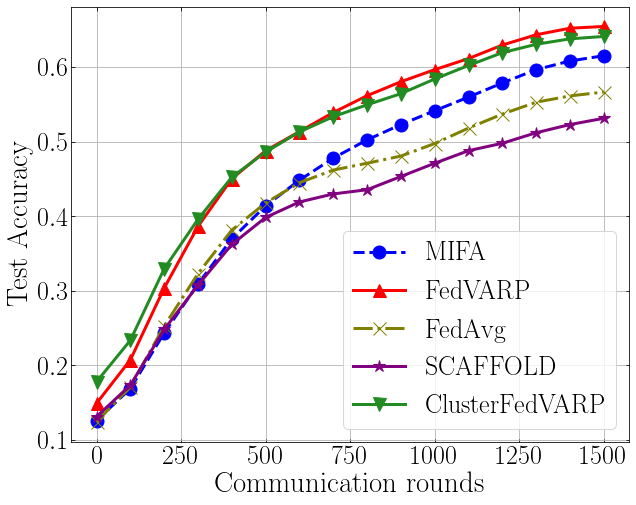

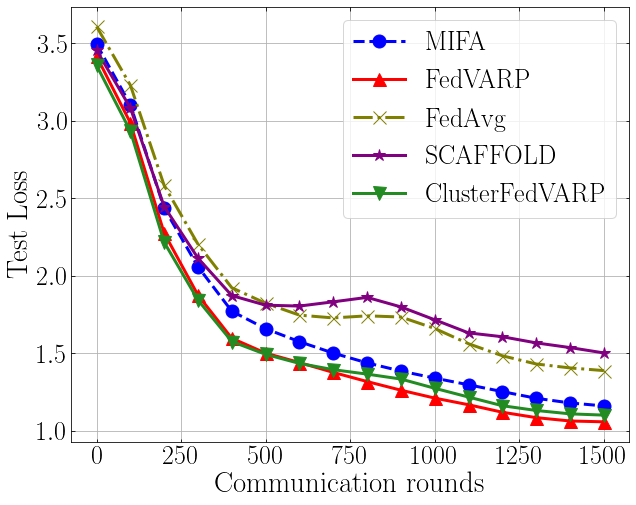

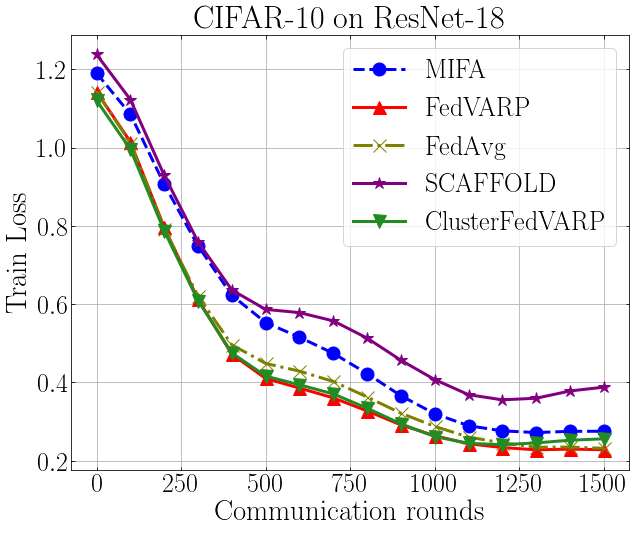

In [ ]:
plot(loss_algo, acc_algo, test_loss_algo,no_of_c[0], '0', algo_lr, 0, global_train_loss_algo = None, n=n, k=k, title = title)


In [ ]:
arr = [2.250185441970825, 2.036592791080475, 1.5368201512098314, 1.0752816233038902, 0.7842651590704918, 0.6840139952301979, 0.8140361189842225, 0.7044646539934911, 0.6070434109866618, 0.5703882758133113, 0.7826706638932228, 0.6582856196910144, 0.5205039769411087, 0.4920514870760962, 0.5987740752939135, 0.6058711806684732, 0.5207625999487936, 0.5628604767471552, 0.377870995849371, 0.5140485446620733]

In [ ]:
def upsa(arr):
  new_arr = []
  for j, i in enumerate(arr):
    new_arr.append(i)
    new_arr.append(i)
    if j%2 == 0:
      new_arr.append(i)
  return new_arr

In [ ]:
loss_algo[0] = upsa(loss_algo[0])
acc_algo[0] = upsa(acc_algo[0])
test_loss_algo[0] = upsa(test_loss_algo[0])
global_train_loss_algo[0] = upsa(global_train_loss_algo[0])

In [ ]:
len(loss_algo[0])

50

CIFAR100

In [ ]:
from torchvision import datasets, transforms

In [ ]:
dataset_train = datasets.CIFAR100('./data/cifar100', train=True, download=True)
dataset_test = datasets.CIFAR100('./data/cifar100', train=False, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified


In [ ]:
dataset_train

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data/cifar100
    Split: Train

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
test_data=unpickle('/content/data/cifar100/cifar-100-python/test')
train_data=unpickle('/content/data/cifar100/cifar-100-python/train')

In [ ]:
test_data.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
train_data.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
len(train_data[b'coarse_labels'])

50000

In [ ]:
len(train_data[b'data'])

50000

In [ ]:
cluster_ids = {}
num_clusters = 0
for i in range(100):
  cluster_ids.setdefault(i,)

In [ ]:
train_data[ b'coarse_labels']